<p align="center">
  <span style="font-size: 50px;"><strong>Final Project - Machine Learning</strong></span>
</p> <br>
<p align="center">
  <span style="font-size: 35px;"><strong>By: Dana Braynin and Raz Graider </strong></span>
</p>

# __*About our project:*__

In this project, we were given information about several features of executable files (.exe).<br><br>
We were asked to build a model that predicts what is the chance of a particular file to be malicious through static analysis of the files (analyzing the information about the files without running them).<br>
This project is a binary classification problem in which we will classify files into two categories - is the file malicious (1) or not (0), based on the features in the data set. Some of the features we received are known and some are anonymous.<br><br>
We were given 60,000 observations that were indicated whether a file was malicious or not. We will analyze the given data, process it and pick the best model that will predict the samples in the test data.

## Import libraries

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import List, Dict
import seaborn as sns
import scipy.stats as stats
import category_encoders as ce
from scipy.stats import mstats
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## Load & External data

In [181]:
def load_files(train_file, test_file):
    '''
    input: train file csv and test file csv
    output: train DataFrame, test DataFrame
    '''
    train_data = pd.read_csv(train_file, index_col=0)
    train_data_copy = train_data.copy()
    test_data = pd.read_csv(test_file, index_col=0)
    test_data_copy = test_data.copy()
    return train_data_copy, test_data_copy

In [182]:
train_data, test_data_copy = load_files("train.csv", "test.csv")

# __*Part 1- Exploring the Data*__

First, we would like to check with there is any duplicate data.
We will check the size of the data, remove duplicates and check if the size changed.

In [183]:
train_data.shape

(60000, 23)

In [184]:
def drop_duplicates_train(data):
    '''
    input: train data
    output: train data after dropping duplicates
    '''
    droped_data = data.drop_duplicates()
    return droped_data

In [185]:
train_data = drop_duplicates_train(train_data)

In [186]:
train_data.shape

(59947, 23)

As we can see, the number of rows in the train data has decreased due to the removal of duplicate rows. We want to remove them in order to avoid bias.

### Glimpse and information about the data

In this section, we want to see the basic information about each feature, for example minimum, maximum, mean, std and more. 

The features names are:

In [187]:
list(train_data.columns)

['size',
 'vsize',
 'imports',
 'exports',
 'has_debug',
 'has_relocations',
 'has_resources',
 'has_signature',
 'has_tls',
 'symbols',
 'numstrings',
 'paths',
 'urls',
 'registry',
 'MZ',
 'printables',
 'avlength',
 'file_type_trid',
 'file_type_prob_trid',
 'A',
 'B',
 'C',
 'label']

In [188]:
train_data.describe()

size         vsize       imports       exports     has_debug  \
count  5.994700e+04  5.801300e+04  58208.000000  57854.000000  57020.000000   
mean   1.502246e+06  1.967168e+06    106.287400     30.831490      0.404139   
std    4.729258e+06  2.018771e+07    213.527394    508.311353      0.490729   
min    2.980000e+02  5.440000e+02      0.000000      0.000000      0.000000   
25%    1.076345e+05  1.228800e+05      1.000000      0.000000      0.000000   
50%    4.845040e+05  4.259840e+05     28.000000      0.000000      0.000000   
75%    1.242716e+06  1.601536e+06    153.000000      0.000000      1.000000   
max    3.253537e+08  4.278288e+09  15047.000000  48840.000000      1.000000   

       has_relocations  has_resources  has_signature       has_tls  \
count     56623.000000   57986.000000   58010.000000  57049.000000   
mean          0.543578       0.861156       0.254422      0.234395   
std           0.498102       0.345787       0.435539      0.423624   
min           0.000000       0.000000       0.000000      0.000000   
25%           0.000000       1.000000       0.000000      0.000000   
50%           1.000000       1.000000       0.000000      0.000000   
75%           1.000000       1.000000       1.000000      0.000000   
max           1.000000       1.000000       1.000000      1.000000   

             symbols  ...         paths          urls      registry  \
count   57294.000000  ...  56287.000000  57598.000000  57422.000000   
mean       40.207526  ...      1.646330     12.512796      0.429679   
std      1240.241923  ...     37.021136     71.663662     11.502160   
min         0.000000  ...      0.000000      0.000000      0.000000   
25%         0.000000  ...      0.000000      0.000000      0.000000   
50%         0.000000  ...      0.000000      0.000000      0.000000   
75%         0.000000  ...      1.000000     10.000000      0.000000   
max    181660.000000  ...   5324.000000   9387.000000   2492.000000   

                 MZ    printables       avlength  file_type_prob_trid  \
count  56859.000000  5.720800e+04   57191.000000         59947.000000   
mean      16.276157  1.208794e+05      32.680866            53.645609   
std       82.229183  6.054898e+05    1095.208065            20.600402   
min        1.000000  5.000000e+00       5.000000            17.500000   
25%        1.000000  6.038750e+03       7.447368            38.400000   
50%        4.000000  2.285800e+04      12.019566            43.300000   
75%       11.000000  7.622325e+04      17.315608            69.100000   
max     7010.000000  5.034687e+07  207990.925620           100.000000   

                  A             B         label  
count  56296.000000  56197.000000  59947.000000  
mean       4.015404      5.810270      0.499558  
std        6.368440      0.641465      0.500004  
min      -17.783199      0.004929      0.000000  
25%       -0.293525      5.469705      0.000000  
50%        3.658333      5.855862      0.000000  
75%        7.863973      6.344719      1.000000  
max       43.926598      6.584937      1.000000  

[8 rows x 21 columns]

The 'describe' function did not show us the information for all the features. Therefore, now we will present this function for the missing features: 'numstrings', 'avlength', 'printables'.

In [189]:
train_data[['numstrings', 'avlength', 'printables']].describe()

numstrings       avlength    printables
count  5.722900e+04   57191.000000  5.720800e+04
mean   7.410662e+03      32.680866  1.208794e+05
std    2.464119e+04    1095.208065  6.054898e+05
min    1.000000e+00       5.000000  5.000000e+00
25%    4.750000e+02       7.447368  6.038750e+03
50%    1.998000e+03      12.019566  2.285800e+04
75%    5.172000e+03      17.315608  7.622325e+04
max    1.572261e+06  207990.925620  5.034687e+07

In addition, we will check the type of each feature.

In [190]:
train_data.dtypes

size                     int64
vsize                  float64
imports                float64
exports                float64
has_debug              float64
has_relocations        float64
has_resources          float64
has_signature          float64
has_tls                float64
symbols                float64
numstrings             float64
paths                  float64
urls                   float64
registry               float64
MZ                     float64
printables             float64
avlength               float64
file_type_trid          object
file_type_prob_trid    float64
A                      float64
B                      float64
C                       object
label                    int64
dtype: object

Here is a glimpse of the first 4 rows in the train data:

In [191]:
train_data.head(4)

size      vsize  \
sha256                                                                   
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...  6744064  6799360.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...    22016    45056.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...   686136   704512.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...     8192    36864.0   

                                                    imports  exports  \
sha256                                                                 
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...    524.0      3.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...      2.0      0.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...    133.0      4.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...      6.0      0.0   

                                                    has_debug  \
sha256                                                          
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...        0.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...        0.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...        1.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...        0.0   

                                                    has_relocations  \
sha256                                                                
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...              1.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...              0.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...              1.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...              0.0   

                                                    has_resources  \
sha256                                                              
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...            1.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...            1.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...            1.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...            0.0   

                                                    has_signature  has_tls  \
sha256                                                                       
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...            0.0      1.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...            0.0      0.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...            1.0      0.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...            0.0      0.0   

                                                    symbols  ...  registry  \
sha256                                                       ...             
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...      0.0  ...       0.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...      0.0  ...       0.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...      0.0  ...       0.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...      NaN  ...       0.0   

                                                      MZ  printables  \
sha256                                                                 
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...  28.0    899075.0   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...   1.0       856.0   
b0b126adc73b980a114e38027b082d149fcf491547452f0...   2.0     32767.0   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...   1.0       678.0   

                                                     avlength  \
sha256                                                          
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...  13.857079   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...   9.617978   
b0b126adc73b980a114e38027b082d149fcf491547452f0...  12.140422   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...   9.549296   

                                                                              file_type_trid  \
sha256                                                                                

The 'head' function did not show us the information for all the features. Therefore, now we will present this function for the missing features: 'numstrings', 'avlength', 'printables', 'paths', 'urls'.

In [192]:
train_data[['numstrings', 'avlength', 'printables', 'paths', 'urls']].head(4)

numstrings   avlength  \
sha256                                                                      
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...     64882.0  13.857079   
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...        89.0   9.617978   
b0b126adc73b980a114e38027b082d149fcf491547452f0...      2699.0  12.140422   
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...        71.0   9.549296   

                                                    printables  paths  urls  
sha256                                                                       
a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd5...    899075.0    0.0   0.0  
ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf016...       856.0    0.0   0.0  
b0b126adc73b980a114e38027b082d149fcf491547452f0...     32767.0    0.0  32.0  
ff6176c53ca9b58040c93870c264843b93b5e290c28e576...       678.0    0.0   0.0

From this section, we can learn few importent things:<br>
- From the features documentation and from the tables above, we can learn that there are few features that appear as float (binary classification) but in reality they represent classification to 2 groups and do not have a numeric meaning.<br>
The features are: 'has_debug', 'has_relocations', 'has_resources', 'has_signature' and 'has_tls'.
- We can see that there are few columns with missing values (NaN). We will keep that in mind and deal with it in part 2.
- Although we do not have any information about features 'A' and 'B', we can learn the difference between the two.<br>
Feature 'B' has very little varience (the mean is 5.81 and std is 0.64), compared to feature 'A' that has very wide varience (the mean is 4.01 and the std is 6.36).<br>
Therefore, feature 'A' has negative values but feature 'B' does not.
- It is important to note that although we see that for the 4 first examples, the 'paths' is 0, the std of this feature is very large. Therefore, we learn that there are examples that have a large number in the 'paths' feature.
- We can see that the features 'sha256', 'file_type_trid' and 'C' have a lot of categories.<br>
The diversity of the feature 'sha256' is understood since each file has its own name, but for the two other features it can be problematic, and we will deal with it in Part 2.

We want to see how many catagories and the frequencies there are in 'file_type_trid' and 'C':

In [193]:
file_type_trid_counts = train_data['file_type_trid'].value_counts()
print(file_type_trid_counts)

file_type_trid
Win64 Executable (generic)                   10083
Win32 Executable MS Visual C++ (generic)      8963
Win32 Executable (generic)                    8781
Win32 Dynamic Link Library (generic)          4010
Generic CIL Executable (.NET, Mono, etc.)     3804
                                             ...  
MS Flight Simulator Gauge                        1
Photoshop filter plug-in                         1
VirtualDub Filter Plug-in                        1
GIMP Plugin (Win)                                1
WinArchiver Mountable compressed Archive         1
Name: count, Length: 89, dtype: int64


In [194]:
categories_with_one_example = (file_type_trid_counts == 1).sum()
print("There are", categories_with_one_example, "catagories in 'file_type_trid' that appear only once.")

There are 12 catagories in 'file_type_trid' that appear only once.


As we can see, there are 89 catagories in 'file_type_trid'. In this case, creating dummy variables for each category can lead to a high-dimensional feature space and potential issues such as the curse of dimensionality. 

In [195]:
train_data['C'].value_counts()

C
vh     23197
er     11567
cs      5946
bf      5784
gow     5650
mc      5150
vr       602
Name: count, dtype: int64

In 'C' feature, there are only 7 catagories. Because of that, and because this is an anonymous feature, this situation is not problematic for us. We will create dummy variables for this feature.

## Visualizations

In [196]:
colors=['springgreen', 'teal','firebrick', 'orangered', 'lightsalmon','salmon', 'chocolate', 'crimson', 'darkorchid','orchid','mediumaquamarine','deepskyblue', 'skyblue', 'lightseagreen','yellowgreen', 'darkcyan','steelblue', 'dodgerblue', 'cornflowerblue', 'royalblue', 'plum', 'darkcyan', 'gray', 'rosybrown', 'red', 'aqua', 'olive', 'coral', 'teal' ]

### 1. Feature distribution

We will see how each numeric feature distributed. It will help us to examine if each distribution is close to normal distibution.

In [197]:
def plot_distribution (data, color):
    """
    input: the train data and a color
    output: plots the feature distribution 
    """
    pd.concat([data],axis=1).hist(figsize=(15,15), color  = color)
    plt.show()

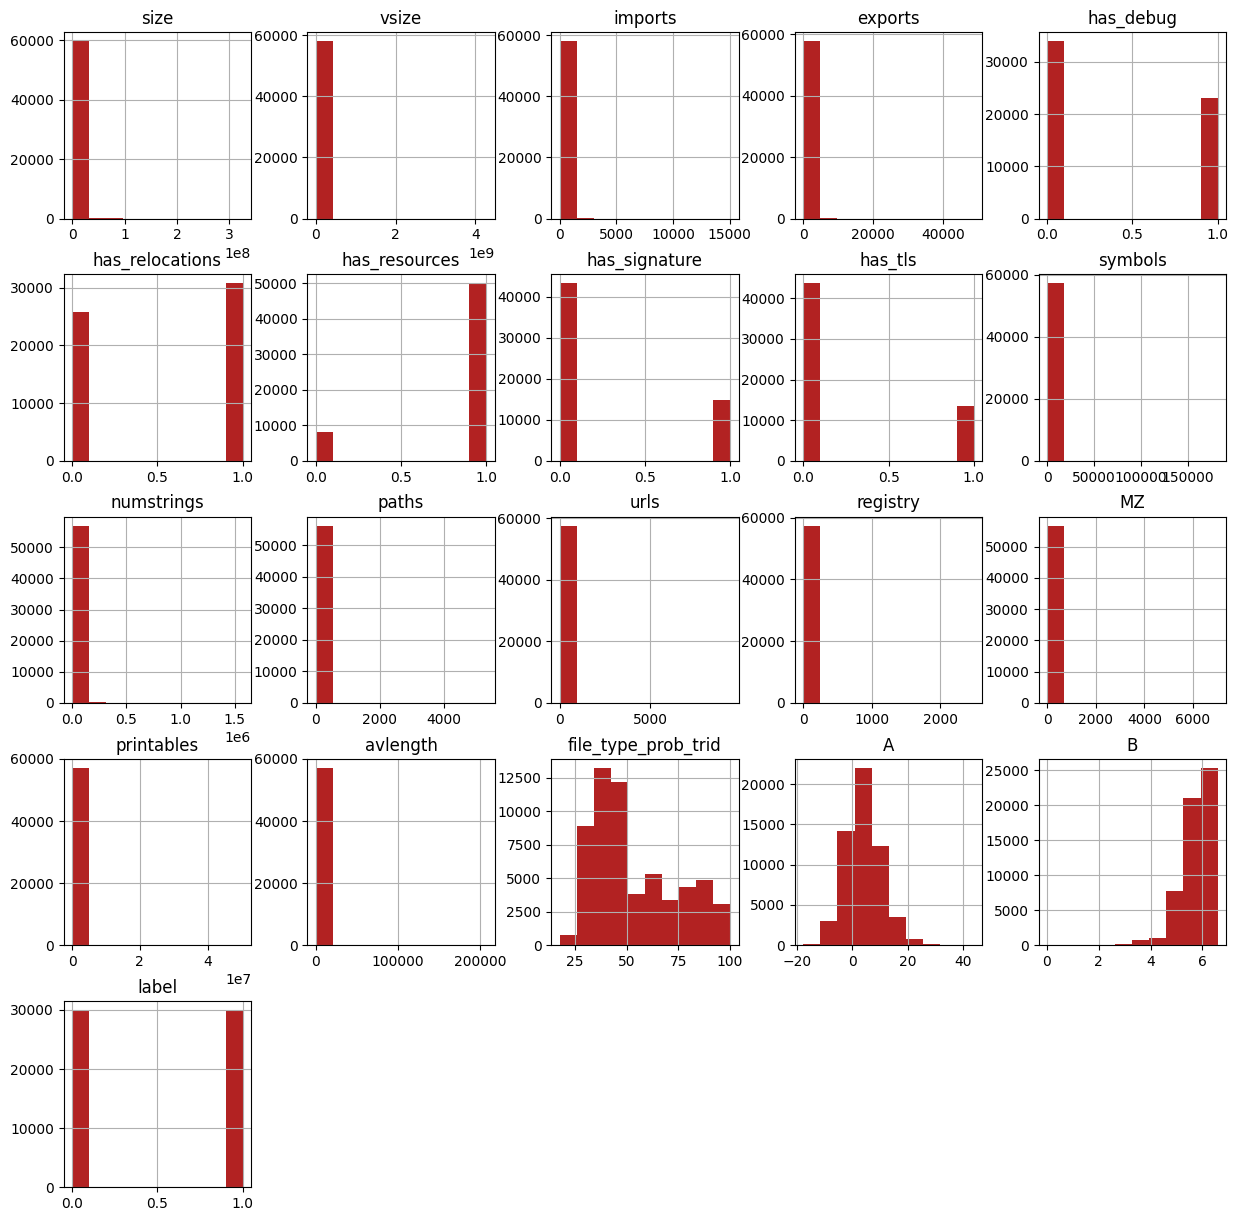

In [198]:
plot_distribution(train_data, colors[2])

After this, we will show the density of each feature:

In [199]:
def plot_density (data, colors):
     """
     input: the train data and a list of colors
     output: plots the feature density 
     """
     for x, column in enumerate(data.select_dtypes(include=[float,int])):
    
          # Get the color for the current plot
          color = colors[x % len(colors)]

          # Plot the density using kdeplot
          sns.kdeplot(data=data[column], fill=True, color=color)
    
          # Set title and labels
          plt.title(f"Density Plot - {column}")
          plt.xlabel(column)
          plt.ylabel("Density")
    
          # Display the plot
          plt.show()

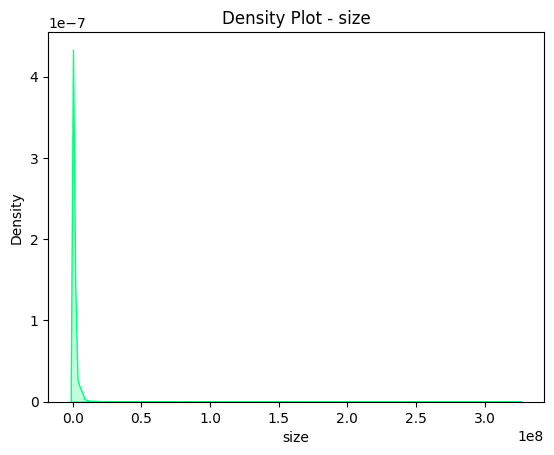

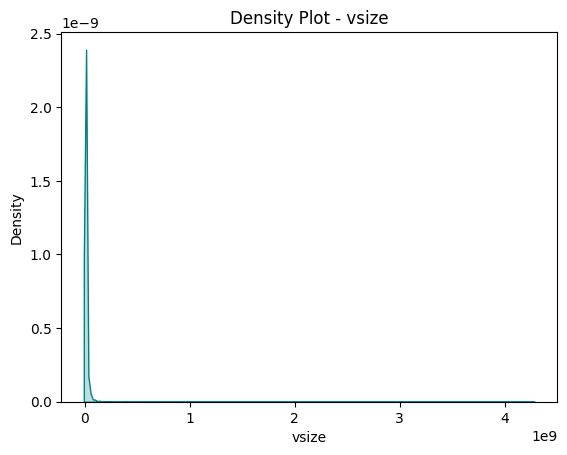

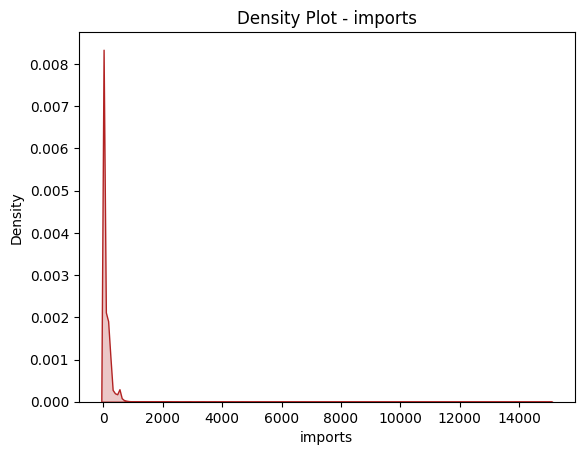

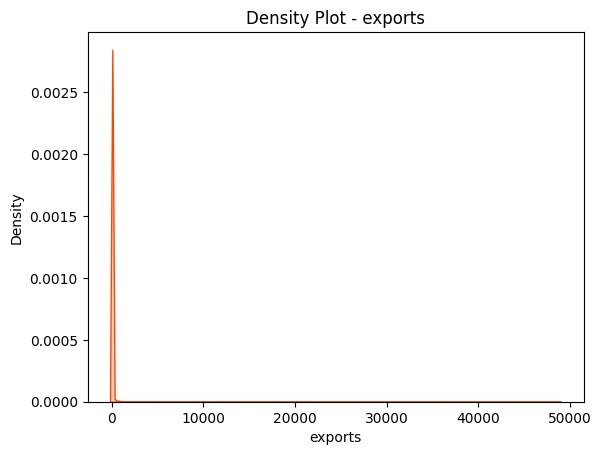

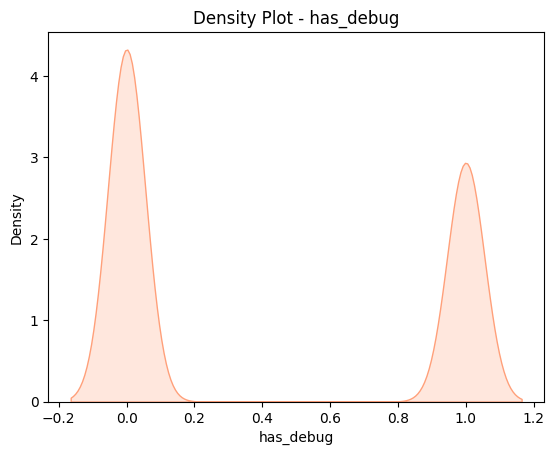

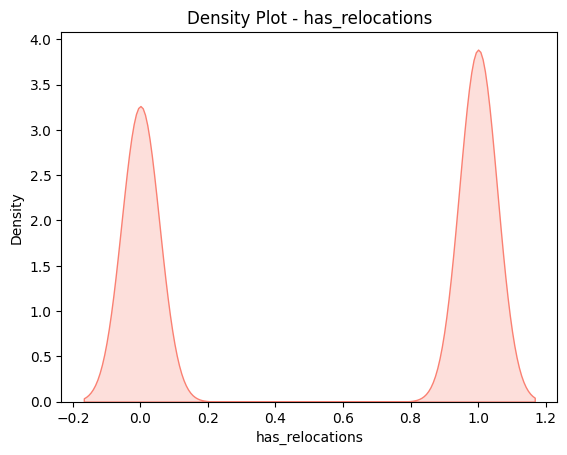

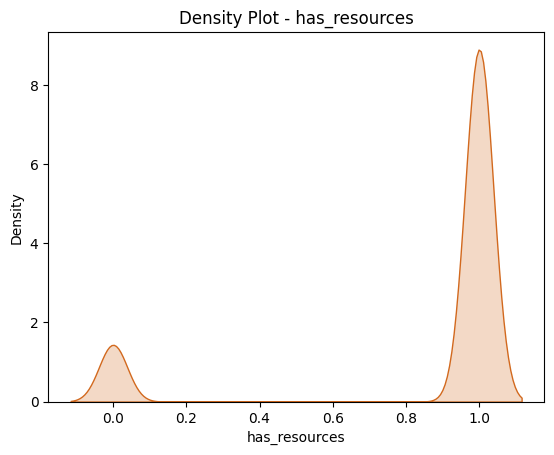

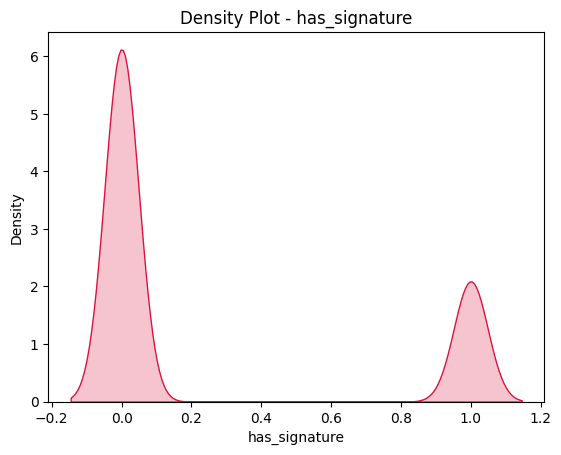

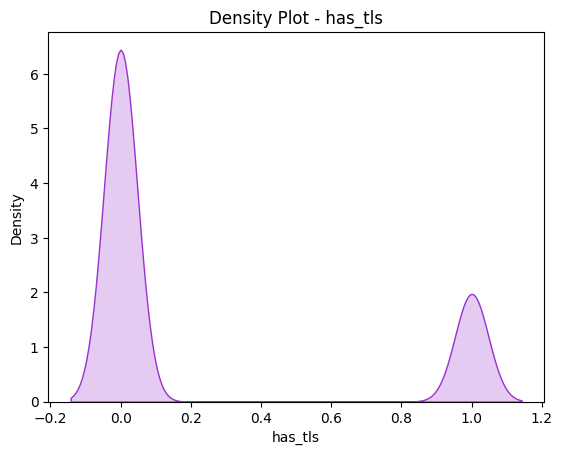

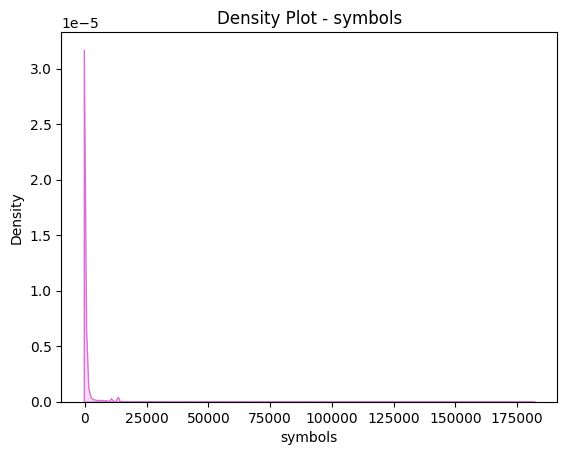

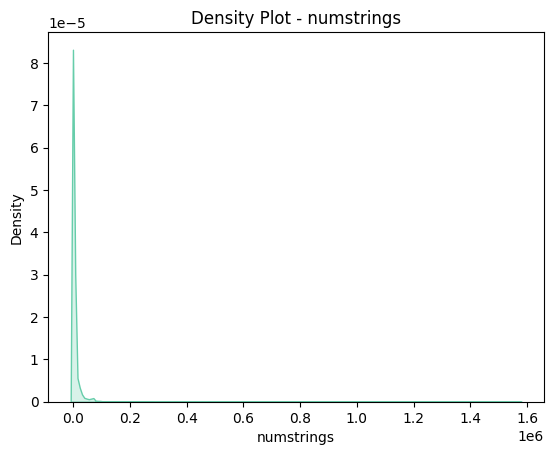

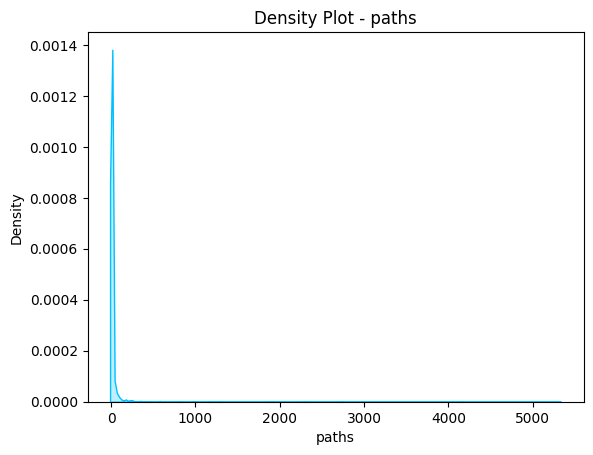

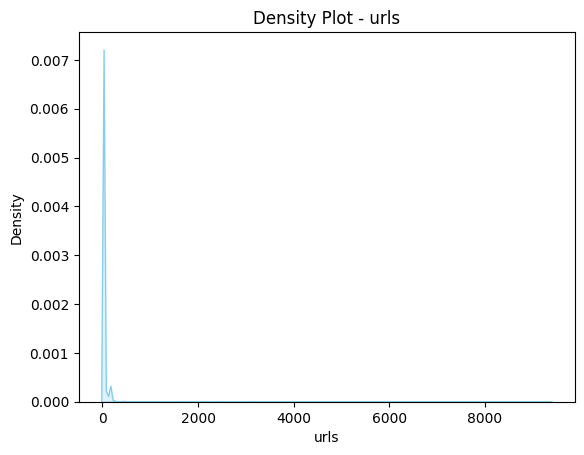

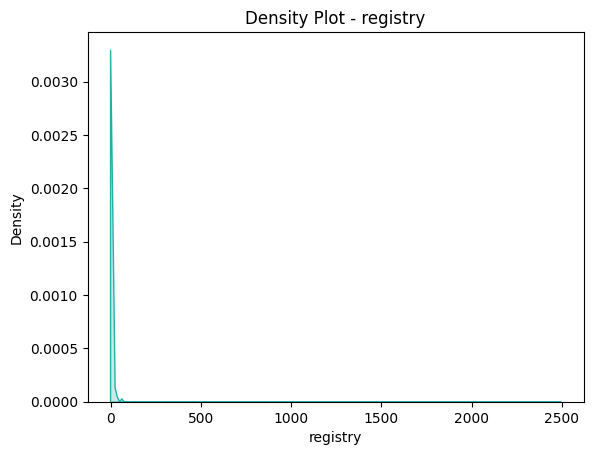

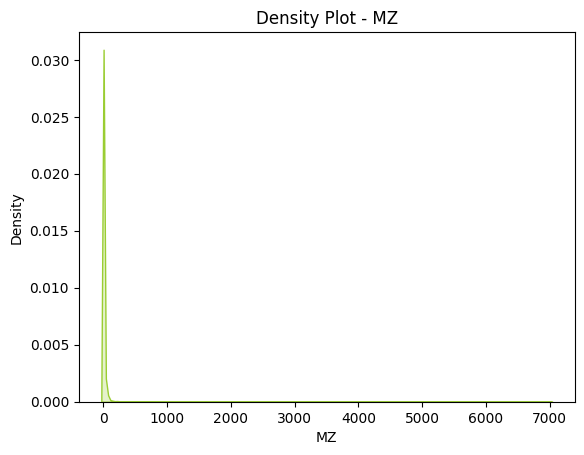

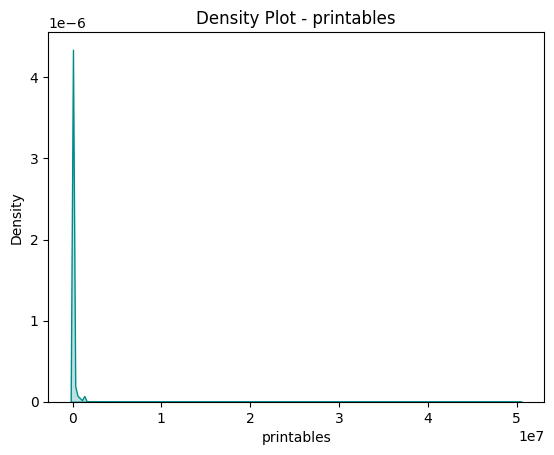

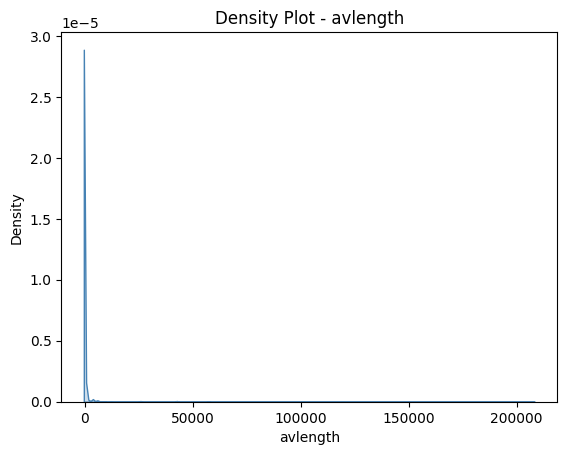

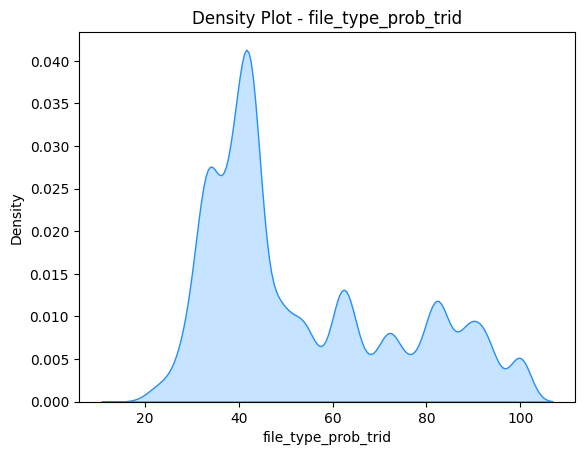

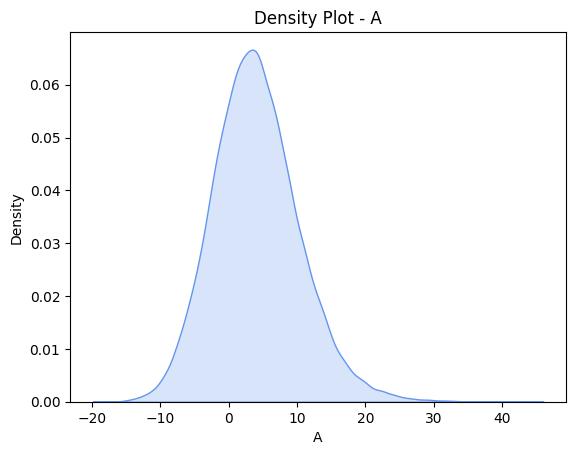

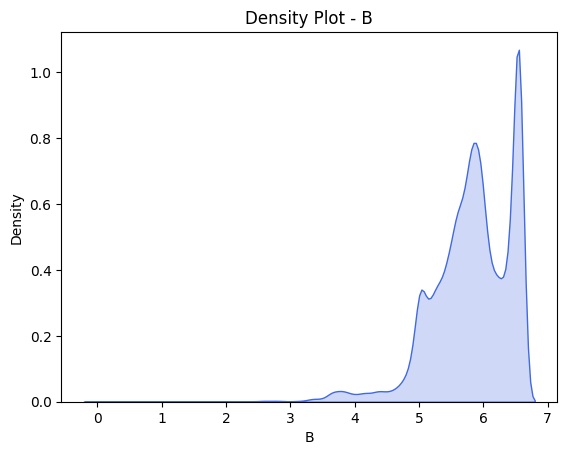

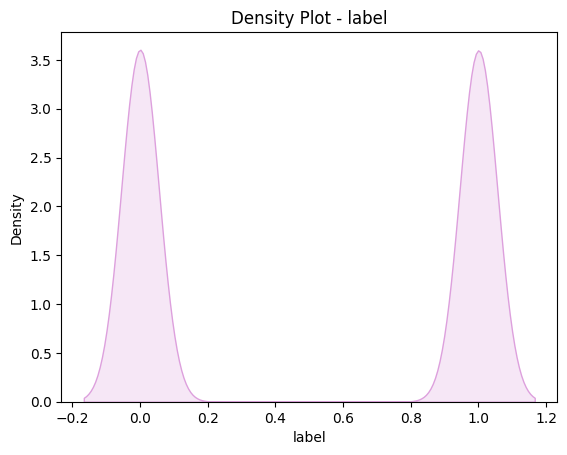

In [200]:
plot_density(train_data, colors)

The binary features ('has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature', 'label') are also shown like this in the plots. They are distributed around "0" and "1".

There are some features that have very extreme examples, that disturb the density plot. The features are: 'file_size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength'. Going forward, we will check how many outliers there are in each feature and we will consider if we want to remove them.

As we can see, feature 'A' is the only one that is close to gaussian distribution, therefore we will assume that this feature is normally distributed. We will present this feature by using "Boxplot":

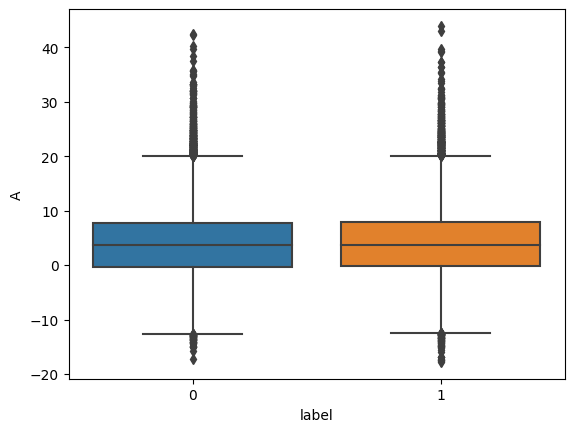

In [201]:
sns.boxplot(x='label', y='A', data=train_data)
plt.show()

This plot confirms the claim that feature 'A' is normally distributed because the boxes appear near the center of the graph and there is a symmetry between label "0" and label "1". Also, it seems that there are a lot of outliers but the amount of them seems relatevly equal between the two kinds of the label.

Now, we will show how each categorical feature distributs:

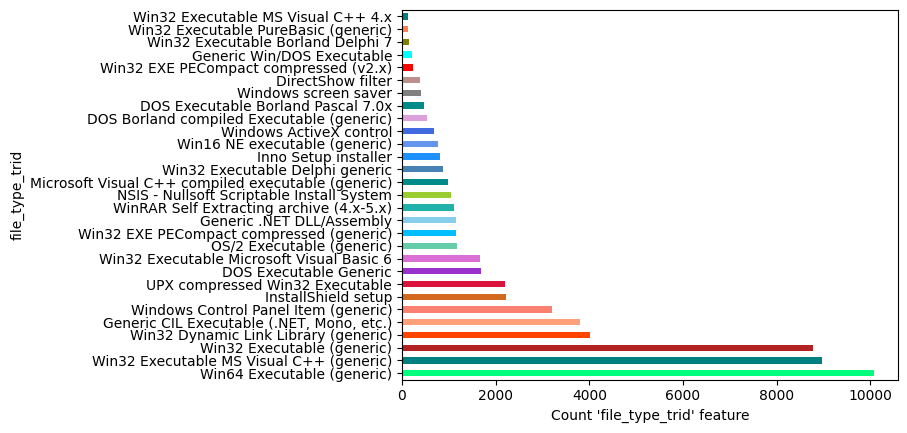

There are 60 catagories in 'file_type_trid' that appear less than 100 times and 29 catagories that appear more than or exactly 100 times.


In [202]:
filtered_value_counts = file_type_trid_counts[file_type_trid_counts >= 100]
filtered_value_counts.plot.barh(color=colors).set_xlabel("Count 'file_type_trid' feature")
plt.show()
print("There are", (file_type_trid_counts < 100).sum(), "catagories in 'file_type_trid' that appear less than 100 times and", (file_type_trid_counts >= 100).sum(), "catagories that appear more than or exactly 100 times.")

Originally, there were 89 catagories in 'file_type_trid' feature. As we explained, there is a risk of dimetionality in turning this catagories to dummies, therefore we would like to reduce the number of catagories. We decided to remove the catagories that appear less than 100 times because it is negligble in relation to the number of the given examples (60,000). After this analysis, we will later remove the 60 categories that appear less then 100 times. We assume that this catagories have a minor effect since their small apperance.

In [203]:
def count_categories_C (data, colors):
    """
    input: the train data and a list of colors
    output: plots the quantity from each category in feature 'C'
    """
    data['C'].value_counts().plot.barh(color=colors).set_xlabel("Count 'C' feature")
    plt.show()

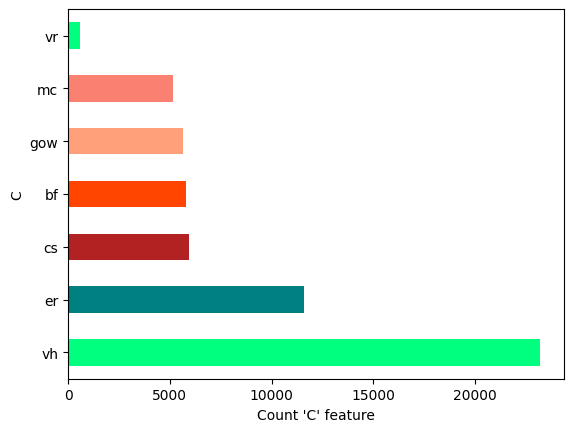

In [204]:
count_categories_C(train_data, colors[:6])

From the plot, we can see that the category "VR" appears significantly less than the other catagories. This feature is unknown, therefore we cannot predict if this category is important or not. Later, we will check the corelation between this catagory and the label/the rest of the features and decide if to remove it or not.

### 2. Feature correlation

First, we will check the correlation between each two of the numeric features and the label:

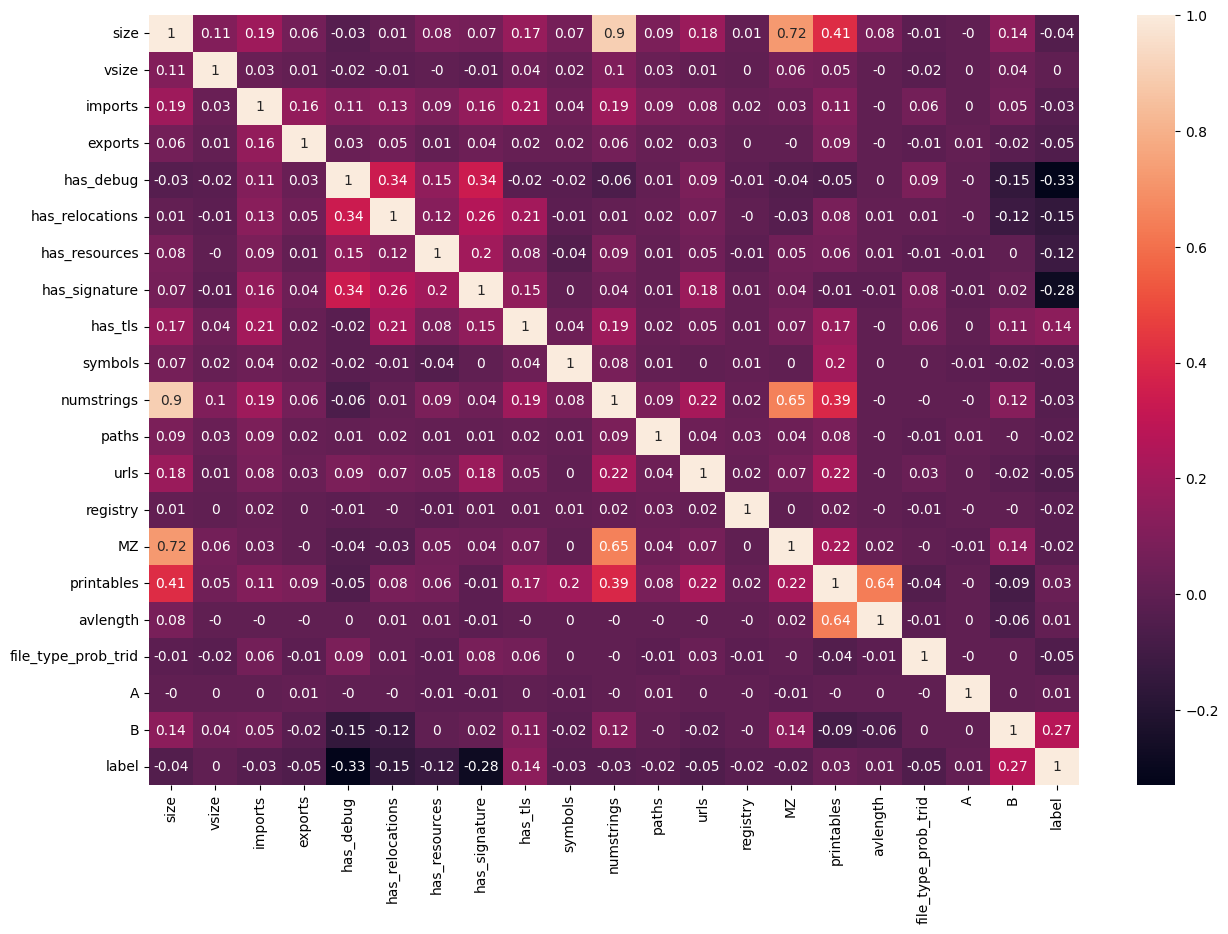

In [205]:
no_catagory_feature = train_data.select_dtypes(include=[float,int])
corr_mat = no_catagory_feature.corr().round(2)
plt.figure(figsize = (15,10))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, annot=True)
plt.show()

As we can see, overall there are not many strong correlations between the numeric features and the label. But, there are few significant correlations that we would like to check in depth.<br>
Usually, strong positive correlation is between 0.7 and 0.99. In this analysis, we will analyze the strong correlations and the moderate positive correlations that are between 0.6 and 0.69 (although usually moderate positive correlations are between 0.3 and 0.69 because we assume that this correlations are not strong enough to be analized indevidually). For the rest, we assume that the relationship between the features/label is weak and therefore it is not significant.

The strongest correlation is 0.9 between 'size' and 'numstrings'. It makes sence, that the more strings in the file, the bigger the file. We will show it in this plot:

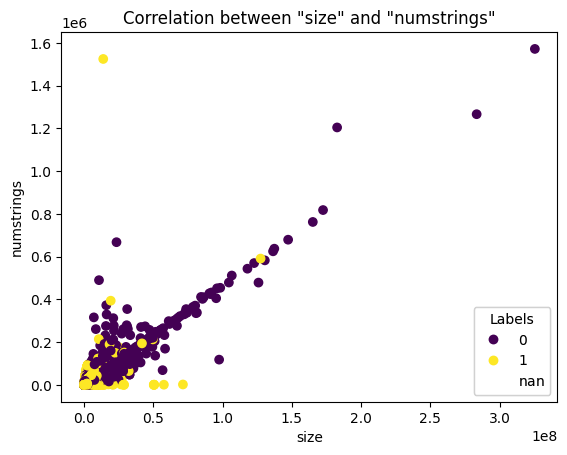

In [206]:
scatter = plt.scatter(x = train_data['size'], y = train_data['numstrings'], c = train_data['label'])
plt.xlabel('size')
plt.ylabel('numstrings')
plt.title('Correlation between "size" and "numstrings"')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title='Labels')
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

Conclusions: In most of the cases, the file is malicious (label=1) when the number of strings and the file size are small. As these two features increase, most of the examples are classified as not malicious files. We can see that there are some radical outliers. We will check them and consider to remove these examples.

The second strongest correlation is 0.72 between 'size' and 'MZ'. The 'MZ' feature counts the number of occurrences of the short string MZ that may provide weak evidence of a Windows PE dropper or bundled executables. Windows PE droppers or bundled executables are typically associated with malicious or suspicious activities. They may be used to deliver malware, execute unauthorized actions, or disguise the true nature of the file. By the corraletion, we can understand that usually the bugger the size of the file, the more 'MZ' strings, therefore a large file is more likely to tend to be malicious.

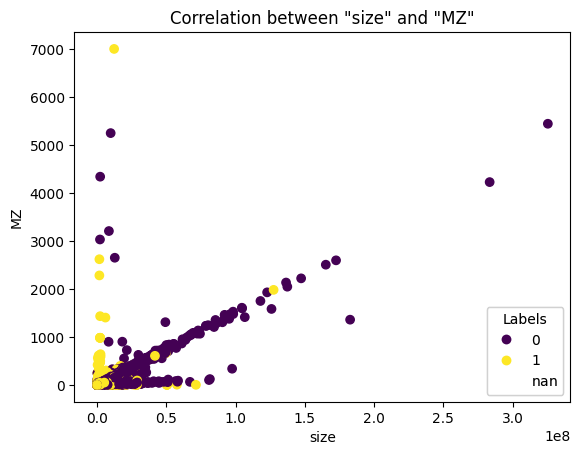

In [207]:
scatter = plt.scatter(x = train_data['size'], y = train_data['MZ'], c = train_data['label'])
plt.xlabel('size')
plt.ylabel('MZ')
plt.title('Correlation between "size" and "MZ"')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title='Labels')
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

By the graph, we can see that there are few outliers that may distrupt the correlation between the two features. Also, we can notice that in contrust of what we assumed, it seems that most of the malicious files are grouped in an area where the size is small. We will consider removing the example that is placed in MZ=7000 because it is an outlier and does not represent most of the malicious files.

The third strongest correlation is 0.65 between 'numstrings' and 'MZ'. We assume that the more strings in a file, the bigger the possibility that the string "MZ" will appear.

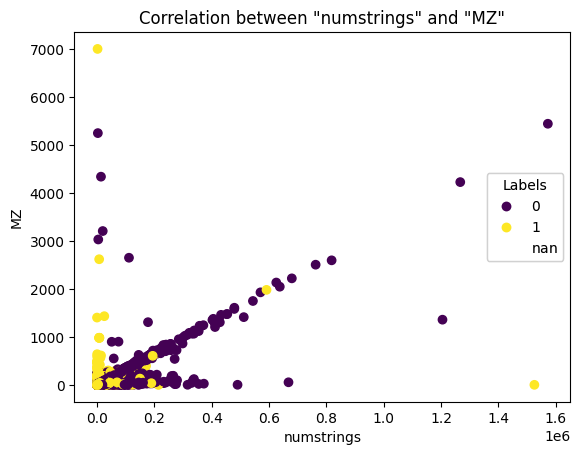

In [208]:
scatter = plt.scatter(x = train_data['numstrings'], y = train_data['MZ'], c = train_data['label'])
plt.xlabel('numstrings')
plt.ylabel('MZ')
plt.title('Correlation between "numstrings" and "MZ"')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title='Labels')
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

We can see that the graph is very simillar to the correlation plot between "size" and "MZ". It is not surprising due to the strong correlation between "size" and "numstrings". The same outlier that distrupted in the correlation between "size" and "MZ" appears also here. This is an explanation to the contrust to our expactations that the bigger the "numstrings" the higher "MZ".

The last strong correlation is 0.64 between "avlength" (average string length) and "printables" (number of printable characters). We assume that it makes sence that the larger the number of printable characters, the larger the average string length.

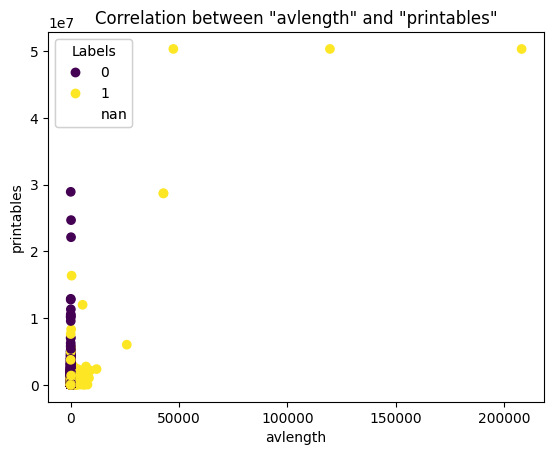

In [209]:
scatter = plt.scatter(x = train_data['avlength'], y = train_data['printables'], c = train_data['label'])
plt.xlabel('avlength')
plt.ylabel('printables')
plt.title('Correlation between "avlength" and "printables"')

# Create a legend
legend1 = plt.legend(*scatter.legend_elements(), title='Labels')
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

We can see that the 3 yellow outliers on the top distrupt the correlation, so we will consider to remove them. In the other corraletions, there was only one outlier but here it is more drustic because there are 3.

#### correlations with the label- 

We can see that the corraletions with the label are not very high, which can be a problem for the model. A possible solution can be to unite between highly correlated features and to check if the new corraletion with the label has increased significantly.

### 2. Outliers

In this part, we will check if the numeric non-binary features have any outliers. 

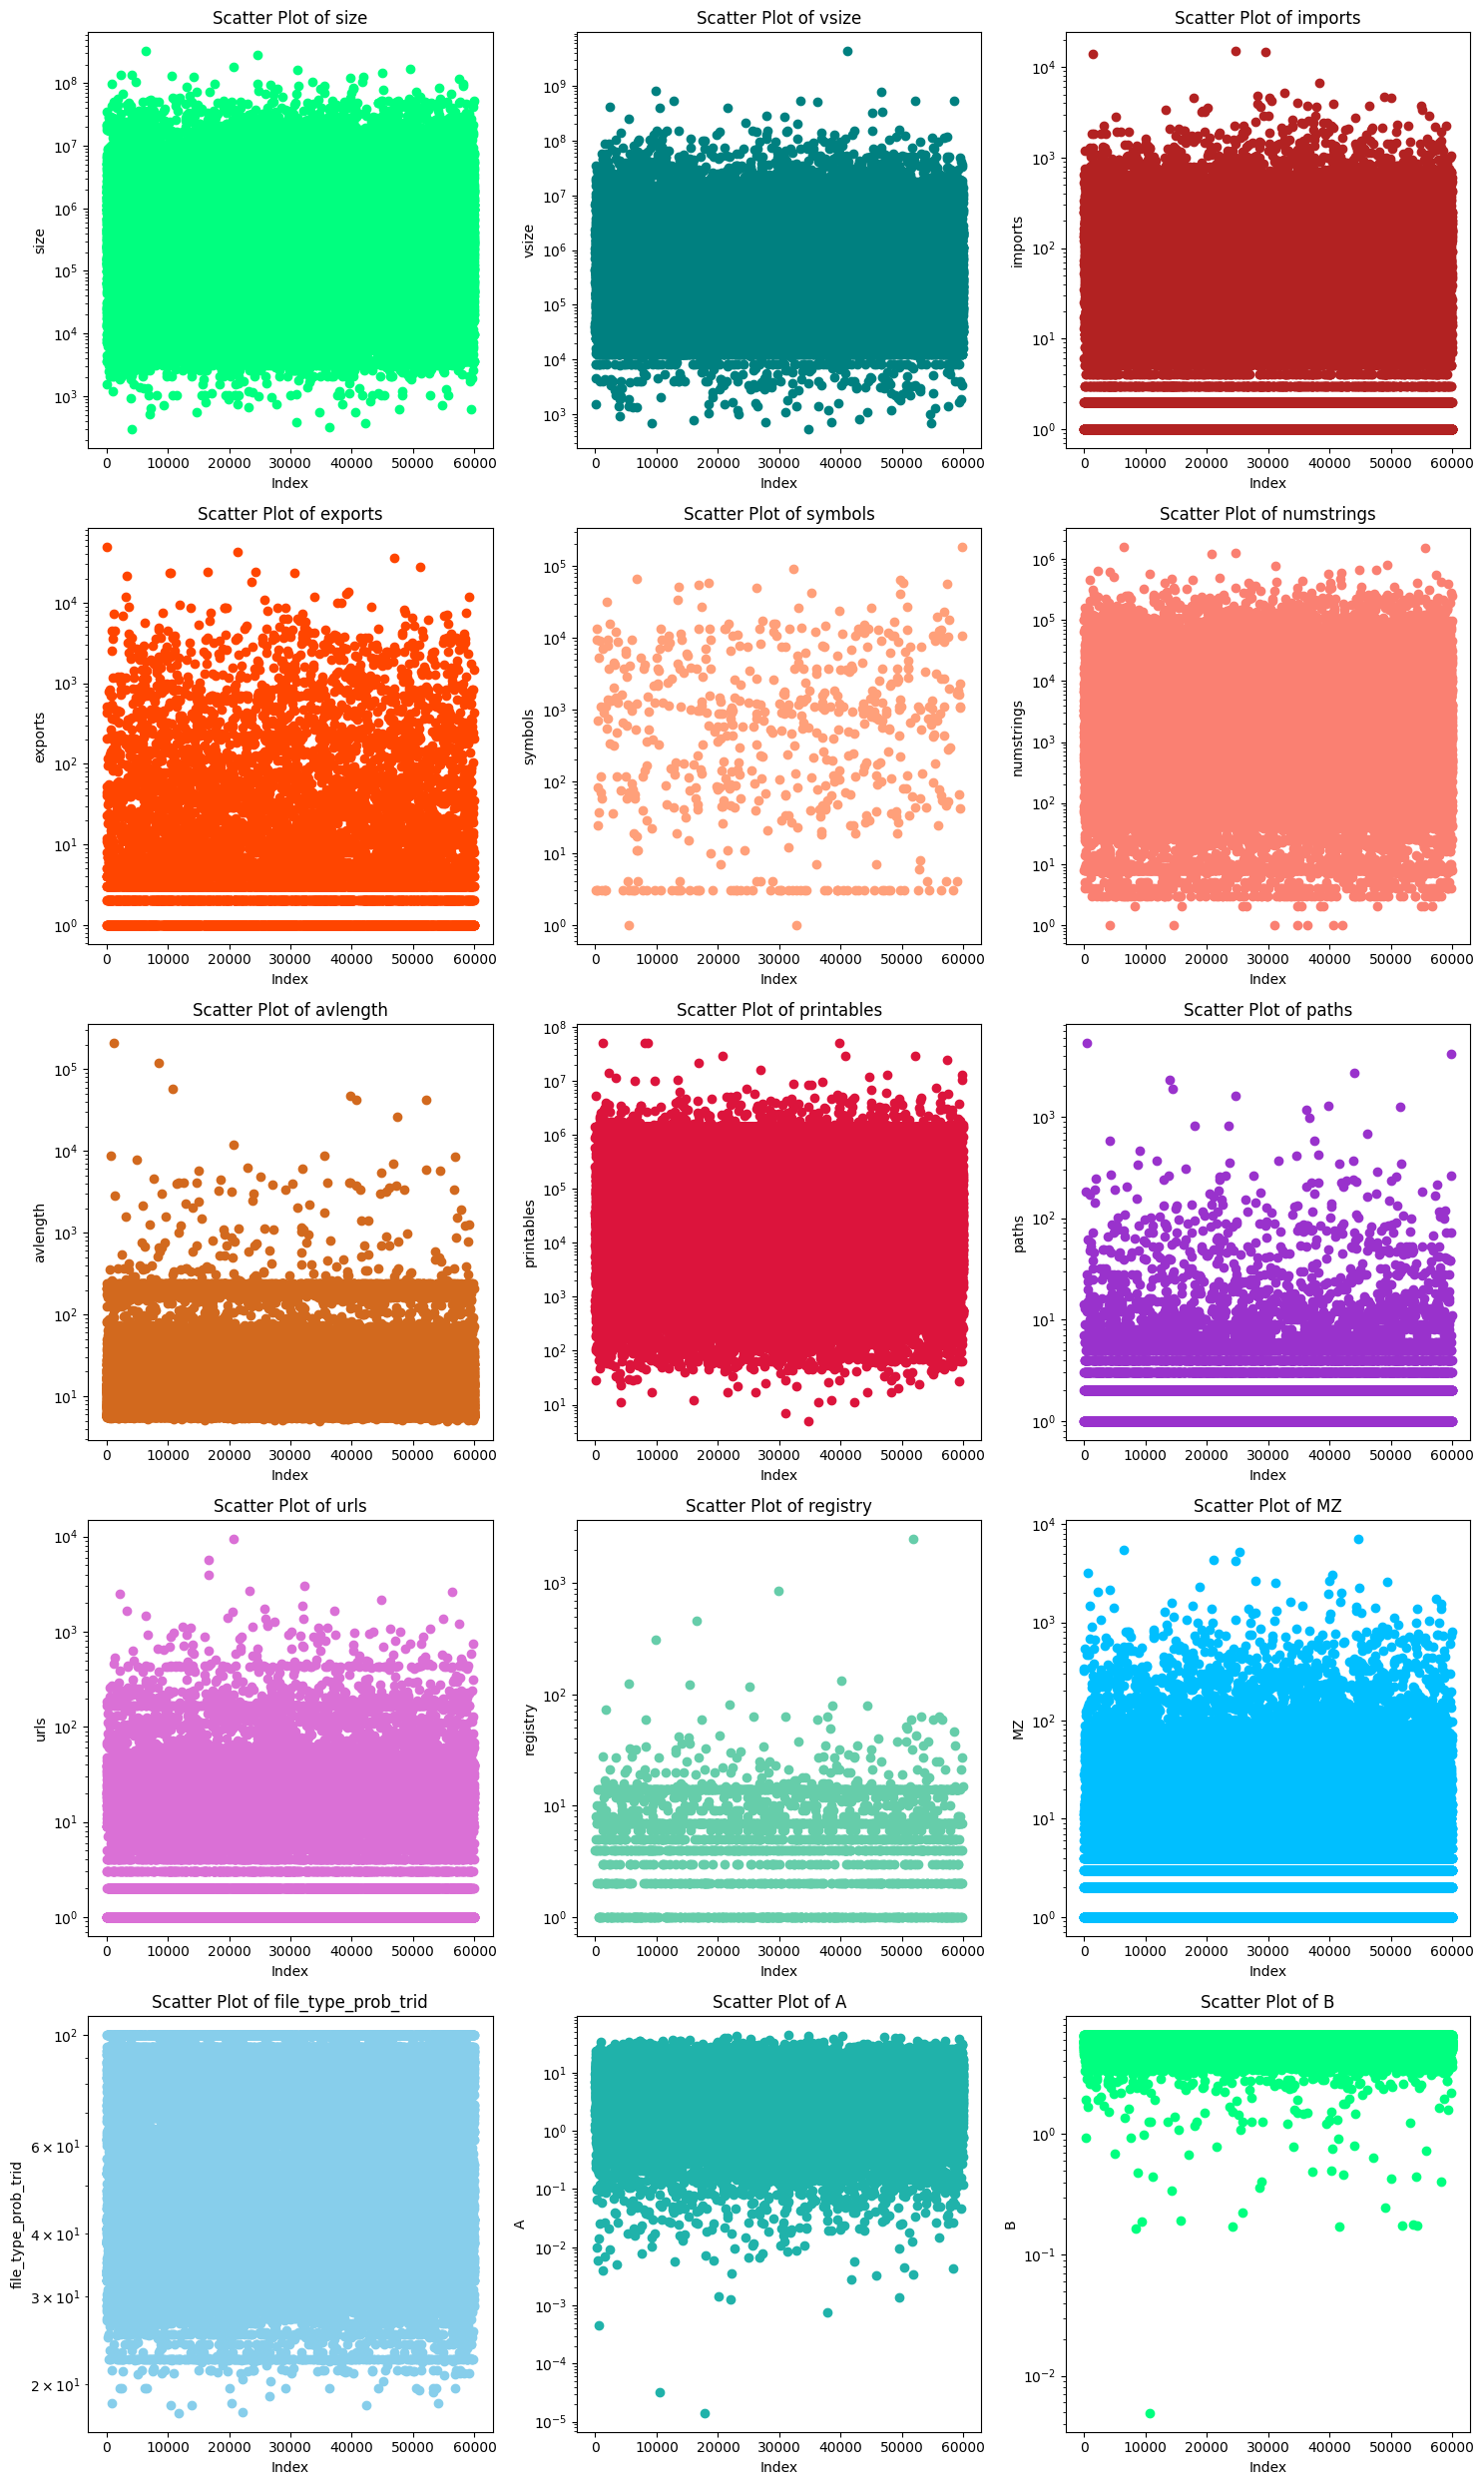

In [210]:
non_binary_features = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'file_type_prob_trid', 'A', 'B']

def visualize_outliers (data, colors):
    """
    input: a data and a list of colors
    output: a plot that shows the value of each sample in every feature in order to look for outliers
    """

    num_plots = len(non_binary_features)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    
    # Create individual plots for each feature with different colors
    for i, feature in enumerate(non_binary_features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row][col]

        # Get the corresponding color from the list
        color = colors[i % len(colors)]

        # Customize the plot as per your requirements
        ax.scatter(range(len(data)), data[feature], color=color)
        ax.set_yscale("log")
        ax.set_title(f'Scatter Plot of {feature}')
        ax.set_xlabel('Index')
        ax.set_ylabel(feature)

    plt.tight_layout()
    plt.show()

visualize_outliers(train_data, colors[:len(non_binary_features)-1])

As we can see, all the numeric features have outliers. This can be an issue because the model can learn from them and its gerenalizaion will not be as good. In part 2, we will deal with these outliers and probably remove them if it will improve the correlation with the label.

### 3. Missing values

In [211]:
train_data.isna().sum()

size                      0
vsize                  1934
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2653
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3088
printables             2739
avlength               2756
file_type_trid            0
file_type_prob_trid       0
A                      3651
B                      3750
C                      2051
label                     0
dtype: int64

For most of the features, there are thousands of missing values. This information will be more useful if we would know the percentage of the missing values in each feature.

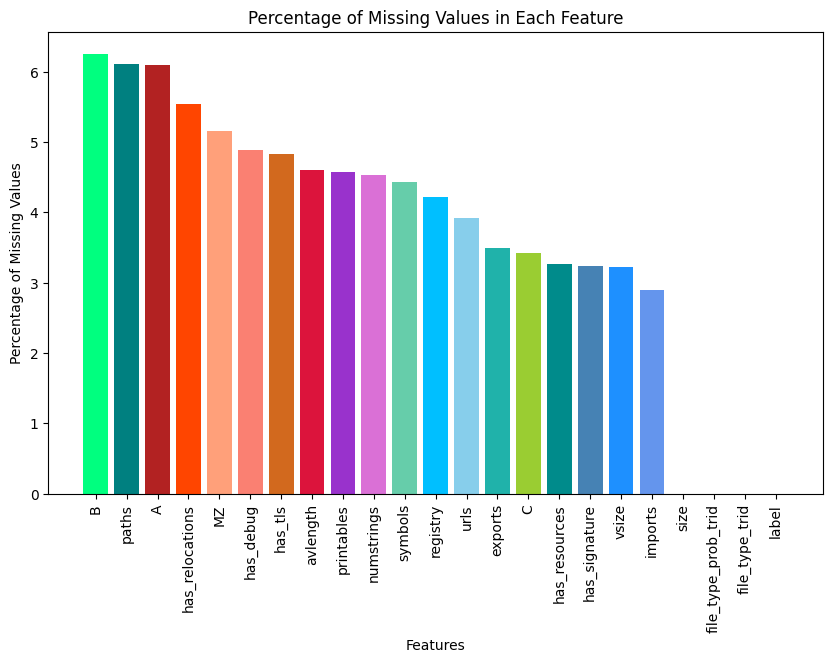

In [212]:
# Calculate the percentage of missing values in each feature
missing_percentage = (train_data.isnull().sum() / len(train_data)) * 100

# Sort the features based on their missing percentage in descending order
sorted_features = missing_percentage.sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_features.index, sorted_features.values, color=colors[:len(sorted_features)])

# Set labels and title
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values in Each Feature')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.show()

The 3 anonymous features have a high percentage of missing values (especially "A" and "B"). This further strengthens the uncertainty regarding these features so we would like to later find a good method to fill the missing values in order to increase the correlation with the label.

As we saw, most of the features have missing values. Later, in part 2, we will take care of all the missing values and fill them.

### 3. Correlation with the label

In [213]:
# Calculate the correlation matrix
no_catagory_feature = train_data.select_dtypes(include=[float,int])
corr_mat = no_catagory_feature.corr().round(2)

# Get the correlation of each feature with the label
correlation_with_label = corr_mat['label'].drop('label')

# Create a table with the correlation of each feature with the label
correlation_table = pd.DataFrame({'Feature': correlation_with_label.index, 'Correlation': correlation_with_label.values})

# Print the correlation table
print(correlation_table)

                Feature  Correlation
0                  size        -0.04
1                 vsize         0.00
2               imports        -0.03
3               exports        -0.05
4             has_debug        -0.33
5       has_relocations        -0.15
6         has_resources        -0.12
7         has_signature        -0.28
8               has_tls         0.14
9               symbols        -0.03
10           numstrings        -0.03
11                paths        -0.02
12                 urls        -0.05
13             registry        -0.02
14                   MZ        -0.02
15           printables         0.03
16             avlength         0.01
17  file_type_prob_trid        -0.05
18                    A         0.01
19                    B         0.27


From this analysis, we can see that there is no feature with high correlation with the label. A reason for that may be that as we saw, most of the features have missing values.<br>
Later, in part 2, we will try to fill the missing values in order to increase the coreelations with the label.

# __*Part 2- Pre Processing*__

In this part, we will use the analysis we did in part 1 and make changes in the train data in order to improve the results of the model.

Before we start with the pre processing, we will split the train data to train and validation. This is an important step because the validation set allows us to evaluate the performance of our models on the test data.<br>
The common choice is to split the train data to 80% train and 20% validation. In our project, we take into considiration that we have a large number of samples (59,947), therefore we will give the validation 25% of the original train data because it allows for a more robust evaluation of the model.

In [214]:
X_train, X_Validation, y_train, y_Validation = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1], test_size=0.25,random_state = 42,shuffle = True)

## **1. Dealing with outliers**

The first step for dealing with outliers is identifying and understanding the outliers in the train data. We visualized the data using scatter plots in part 1, to identify any data points that lie far away from the majority of the data. This will help us to choose the appropriate approach to handle them.

We will use the **Winsorization technique**. It is used to address outliers in non-normal features by capping or truncating extreme values at a predefined threshold. Instead of completely removing outliers, Winsorization replaces them with less extreme values. This approach retains the information provided by the outliers while reducing their impact on the analysis.<br>
In our project, we decided that the threshold will be 5%, meaning that all the samples in each feature that lie at the 5% (top and bottom) will be replaced by minimum amd maximum values within the specified limits.

In [215]:
def deal_with_outliers_winsorization (data, features):
    """
    input: a data and a list of non-binary features
    output: performing winsorization technique to deal with outliers
    """
    # Convert feature names to indices
    new_data = data.copy()
    all_features_list = data.columns.tolist()
    relevent_features_indices = []
    for i in features:
        relevent_features_indices.append(all_features_list.index(i))
    # Apply Winsorization to the relevant features
    for feature_index in relevent_features_indices:
        feature_data = data.iloc[:,feature_index]
        winsorized_data = mstats.winsorize(feature_data, limits = [0.05,0.05])
        new_data.iloc[:,feature_index] = winsorized_data
    return new_data

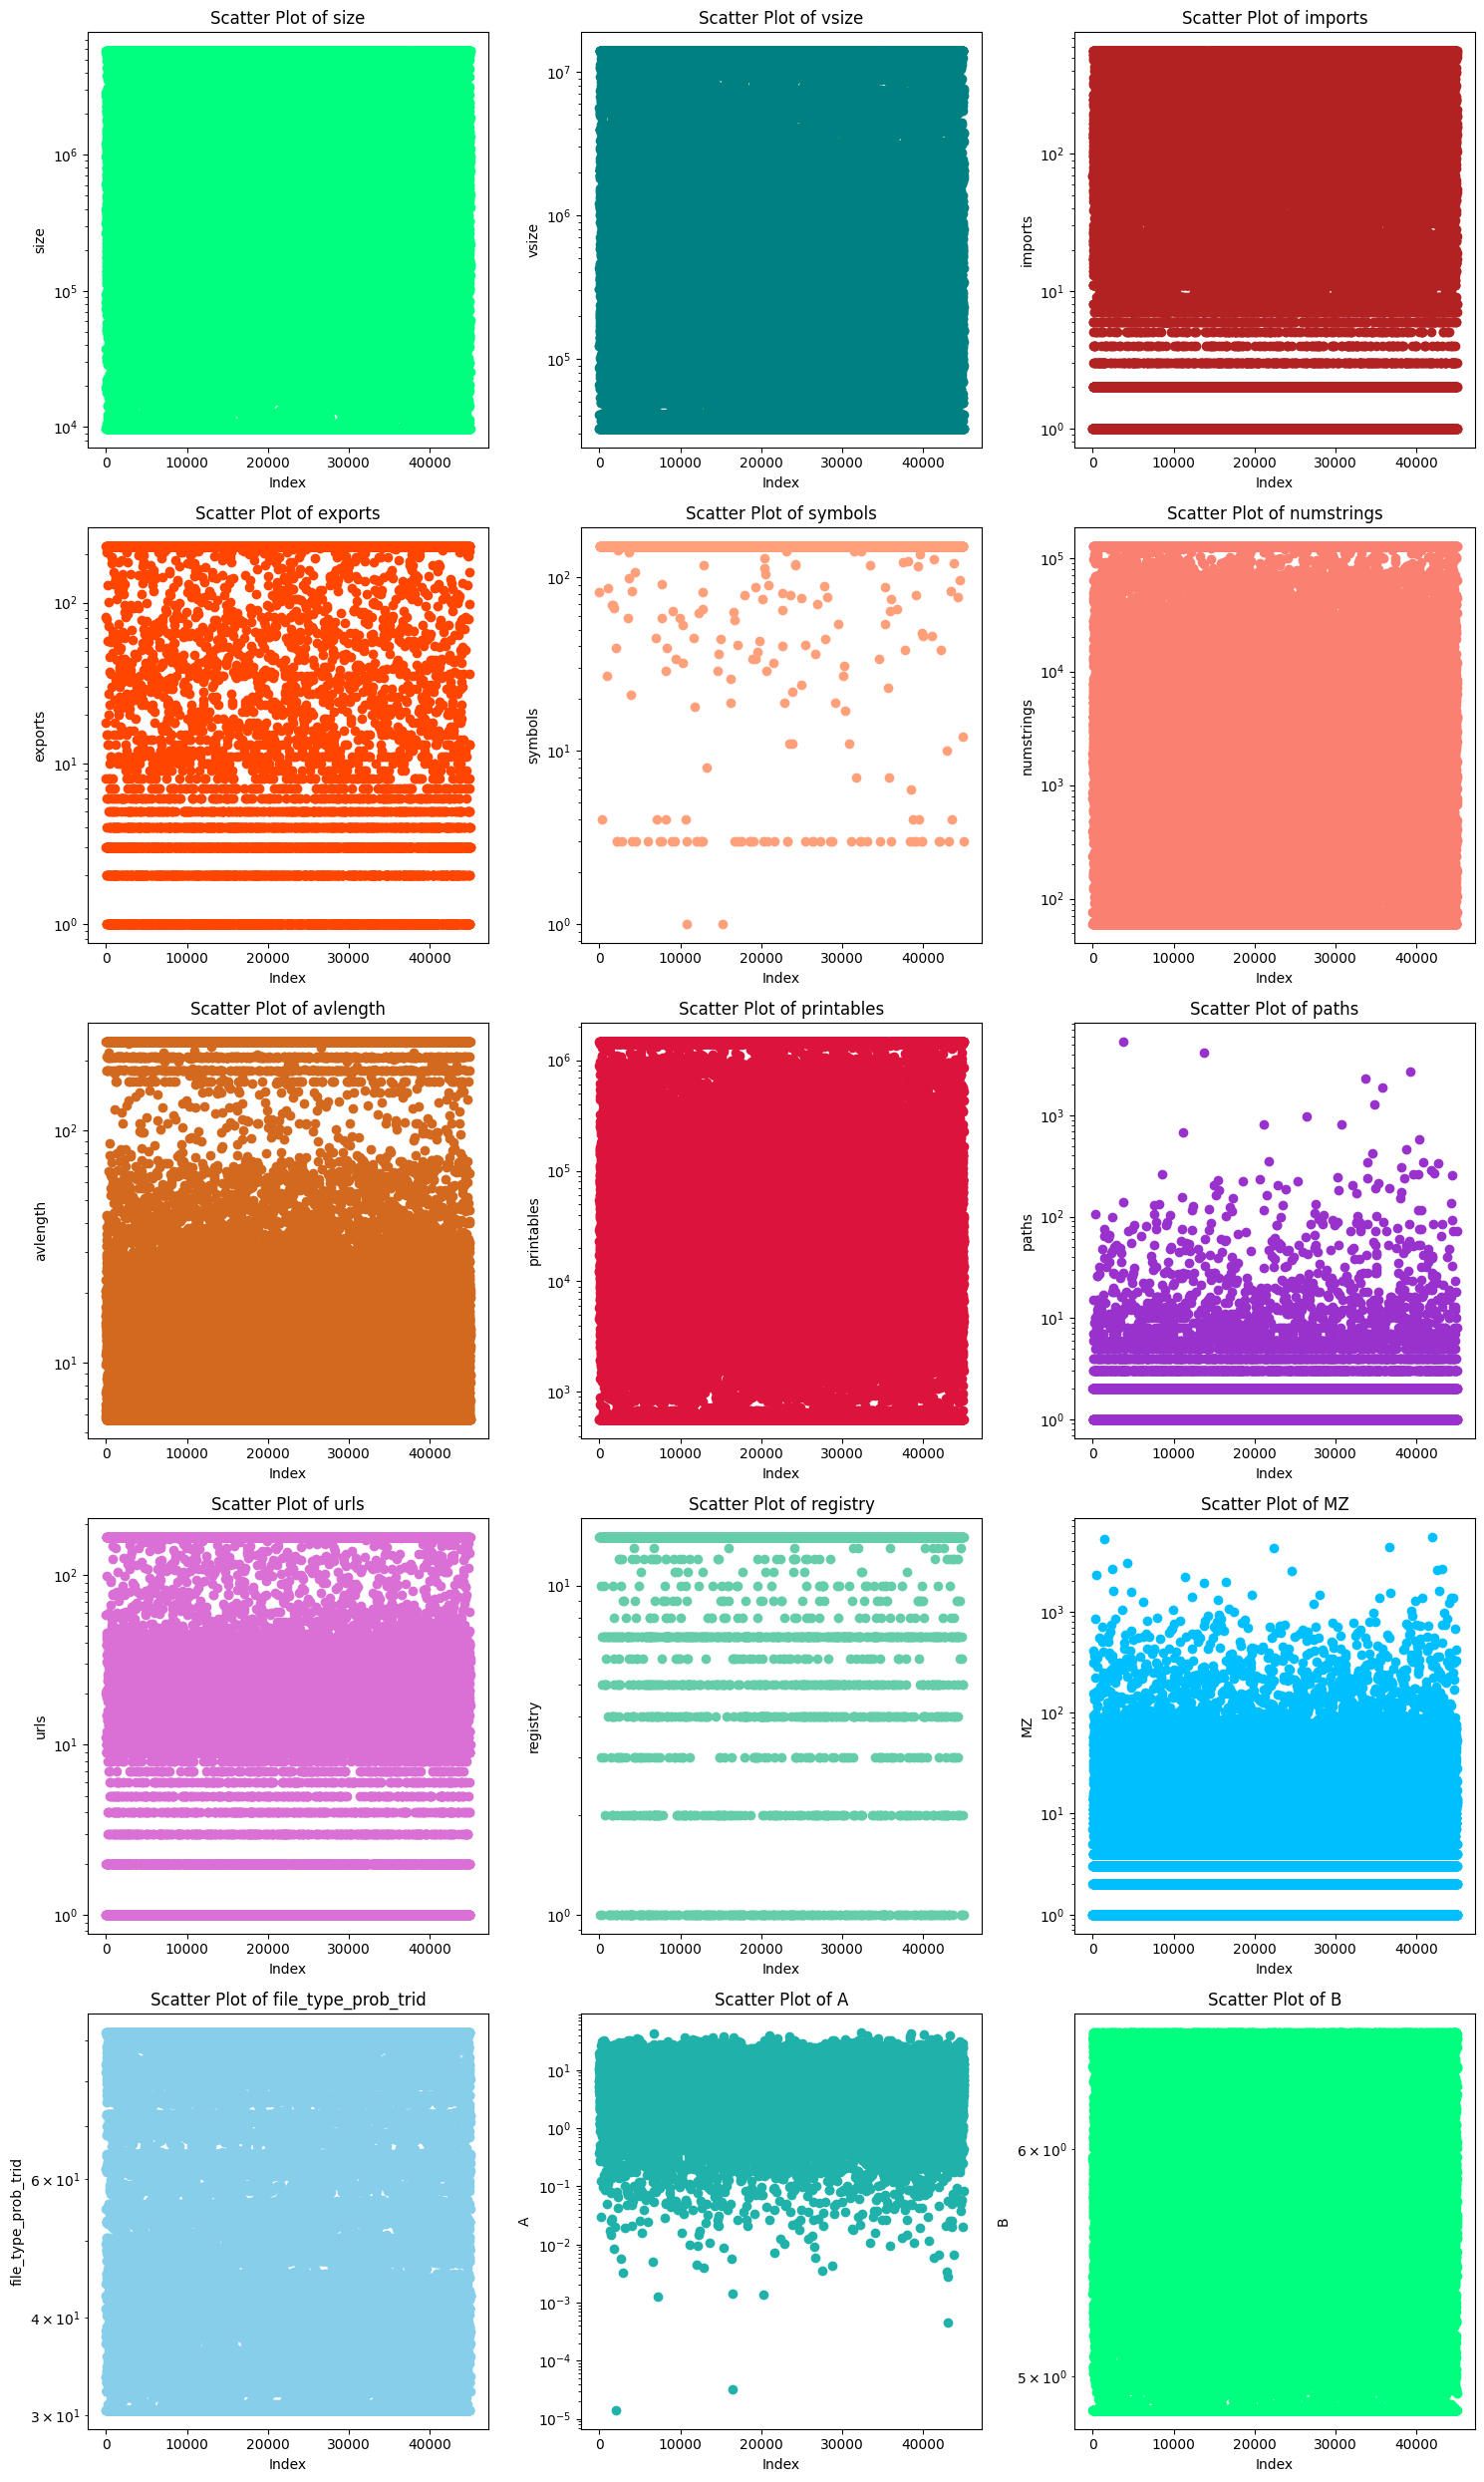

In [216]:
X_train_after_outliers = deal_with_outliers_winsorization(X_train, non_binary_features)

visualize_outliers(X_train_after_outliers, colors[:len(non_binary_features)-1])

After the Winsorization technique, we can notice that for most of the features, the distibution of the samples has drasticlly changed. This result is what we wanted to achive because we do not want the outliers to interupt the final model.

After this process, we want to see the new distribution of the features:

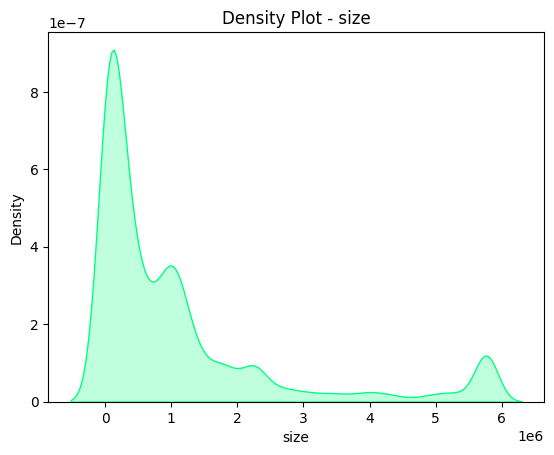

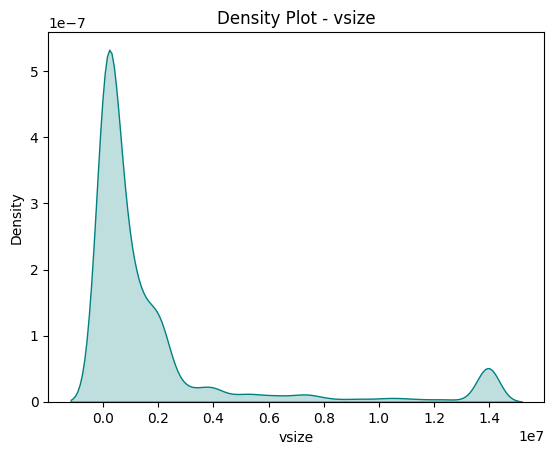

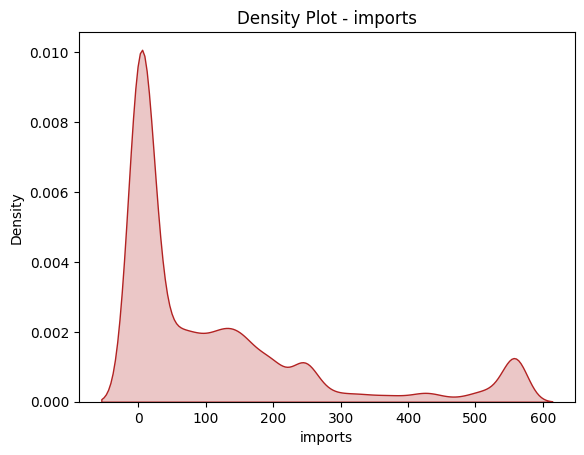

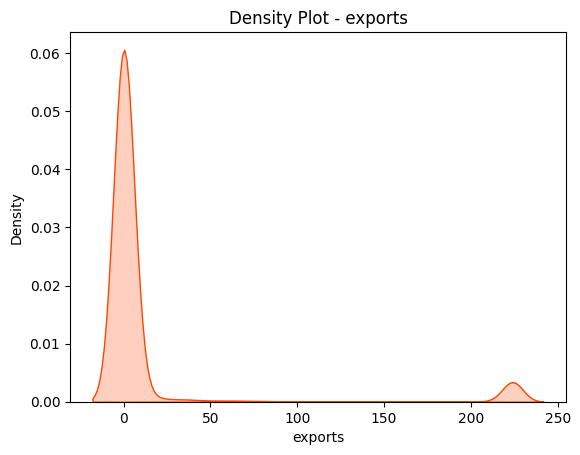

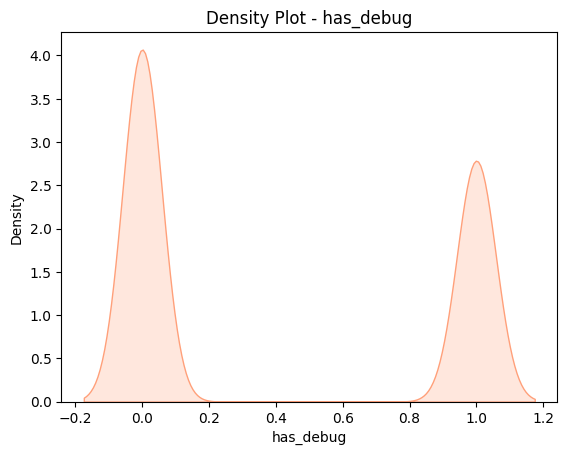

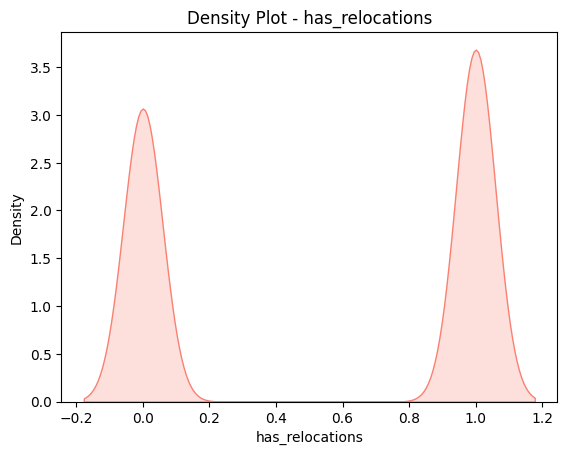

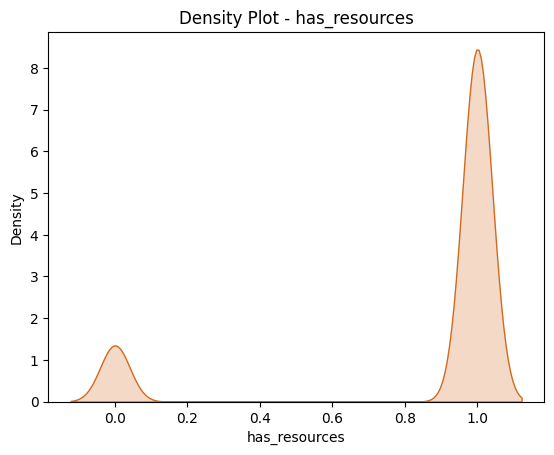

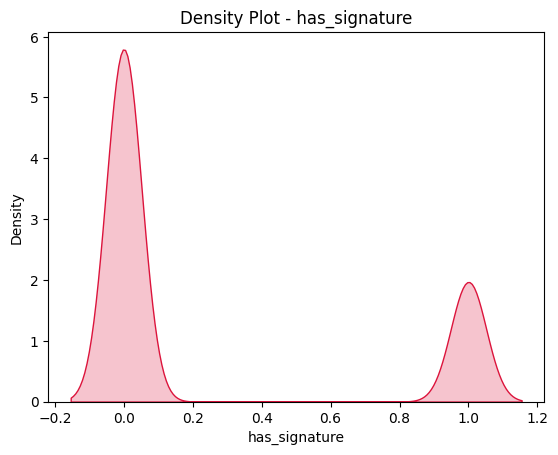

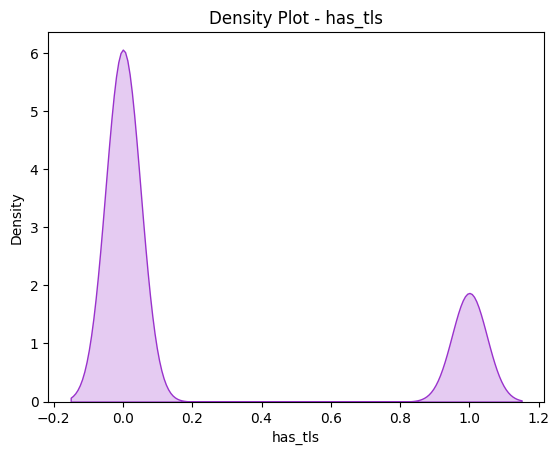

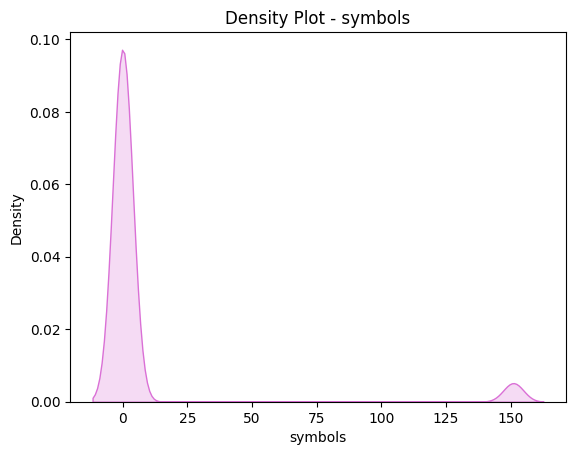

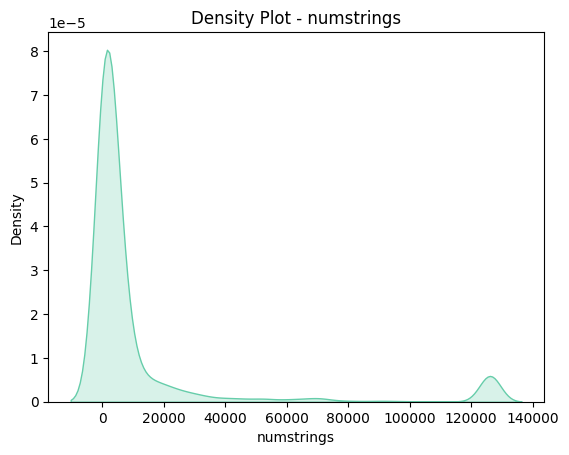

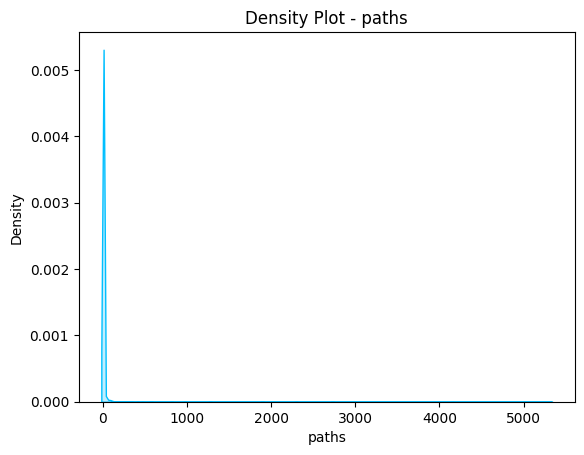

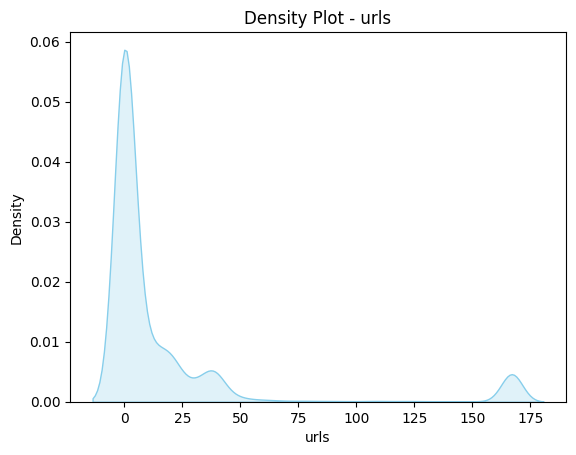

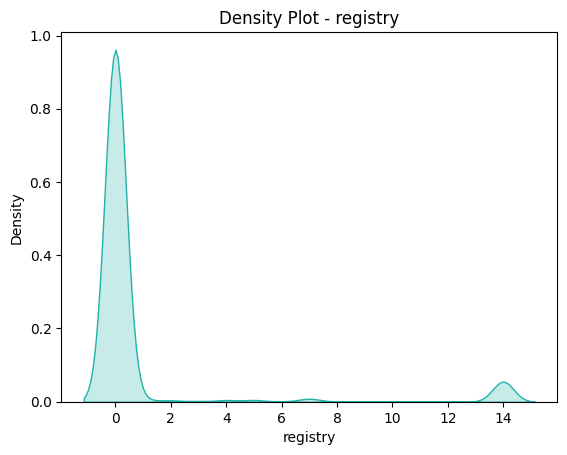

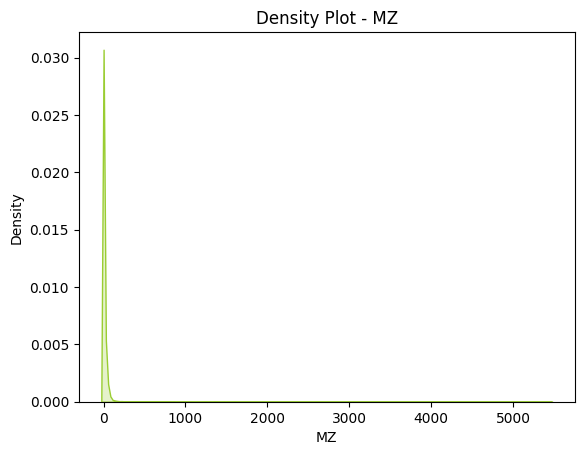

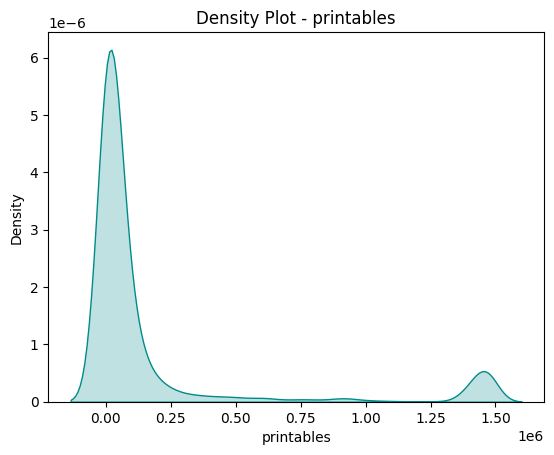

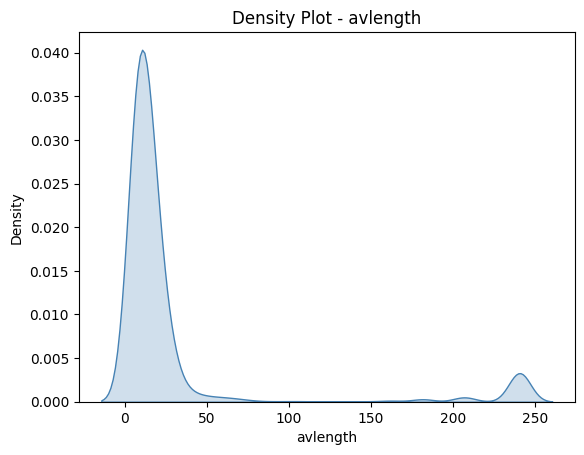

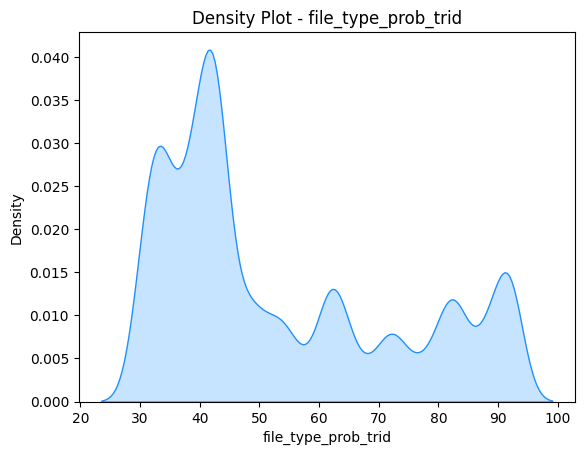

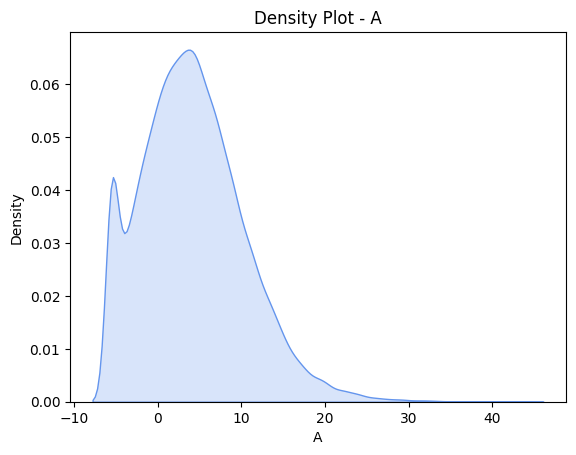

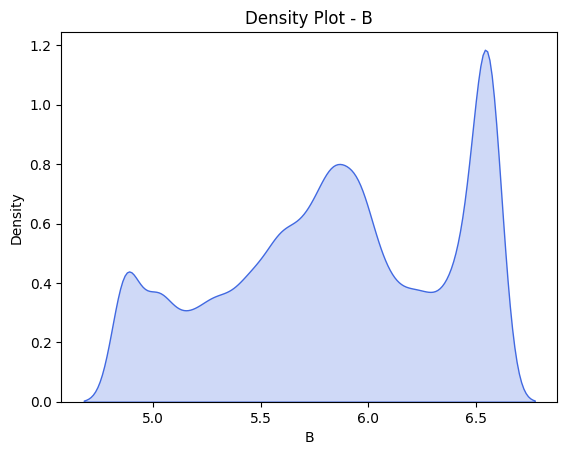

In [217]:
plot_density(X_train_after_outliers, colors)

## **2. Are the features normally distributed?**

As we saw in part 1, the only feature that is close to be normally distributed is feature 'A'.<br>
Later in this part, we will normalize the other features in order to benifit from it in the modeling part.<br>

There are a few importances when the features in Machine Learning project are normally distibuted:<br>
1. Some statistical models, such as linear regression, assume that the features are normally distributed. Deviations from normality may affect the model's performance and the validity of the results.<br>
2. Normality in features can simplify the interpretation of model results. Normally distributed features tend to have well-defined and intuitive interpretations.

However, it is important to note that not all machine learning algorithms or models require normally distributed features. Yet, we will make data transformations in order to achieve normal distribution because we would like to try variaty of models without having the restriction of non-normal features.

## **3. Dealing with missing values**

Dealing with missing values is an important step in a machine learning project because if missing values are not handled properly, they can introduce bias in the analysis and modeling process. By filling in missing values or using appropriate techniques to handle missingness we can reduce noise and improve the predictive power of the models.

As we saw in part 1, except for 'size', 'file_type_trid' and 'file_type_prob_trid', the rest of the features have missing values. We would like to verify the analisis we did for the missing values because we made changes in the train data when dealing with outliers:

In [218]:
X_train_after_outliers.isna().sum()

size                      0
vsize                     0
imports                   0
exports                   0
has_debug              2182
has_relocations        2476
has_resources          1460
has_signature          1432
has_tls                2217
symbols                   0
numstrings                0
paths                  2743
urls                      0
registry                  0
MZ                     2323
printables                0
avlength                  0
file_type_trid            0
file_type_prob_trid       0
A                      2729
B                      2826
C                      1538
dtype: int64

The new data, after dealing with outliers, has changed and therefore also the missing values changed. Now, we have less missing values and we will deal with them in this part.

One approach, is to delete samples with many missing values. High percentages of missing values in certain samples could potentially introduce bias or impact the reliability of our results.<br>
We decided to check if there are samples with over than 50% of missing values.

In [219]:
def check_missing_values_in_samples (data):
    """
    input: a data
    output: number of samples with more than 50% missing values
    """
    threshold = 50  # Define the threshold percentage of missing values

    # Calculate the percentage of missing values for each sample
    missing_percentages = np.mean(data.isna(), axis=1) * 100

    # Identify samples that exceed the threshold
    samples_with_many_missing_values = np.where(missing_percentages > threshold)[0]

    return samples_with_many_missing_values


In [220]:
samples_with_many_missing = check_missing_values_in_samples(X_train_after_outliers)
if len(samples_with_many_missing) > 0:
    print(f"The following samples have more than 50 precent missing values:")
    for sample_idx in samples_with_many_missing:
        print(f"Sample {sample_idx + 1}")
else:
    print("No samples have more than 50 precent of missing values.")

No samples have more than 50 precent of missing values.


We do not have any samples with over than 50% missing values, therefore we will not delete any of the samples in this step.

Another approach, is to delete features with many missing values.

In [221]:
def check_max_num_missing_values_in_features (data):
    max_num_missing_values = data.isna().sum().max()
    num_samples = data.shape[0]
    print(f"The largest number of missing values in a certain feature is {max_num_missing_values} out of total {num_samples} samples.")

In [222]:
check_max_num_missing_values_in_features(X_train_after_outliers)

The largest number of missing values in a certain feature is 2826 out of total 44960 samples.


We can see that the largest number of missing values in a certain feature is 2,826. In this point, we have a total of 44,960 samples, therefore no feature has many missing values. We decided not to delete any features in this step.

The next step in dealing with missing values is to fill them. We will adress this issue by deviding the features to 3 groups and filling the missing values accordingly:<br>
1. Numeric binary features.
2. Numeric non-binary features.
3. Categorical features.

### Filling missing values in numeric binary features

We decided to use the most frequent approach to fill the missing values.<br>
As we can see in part 1 where we checked the distribution of each feature. In each binary feature ('has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature') there is one category that dominates on the other category. Using the most frequent approach can help maintain the distribution and balance of the data by imputing missing values with the dominant category.

In [223]:
def missing_values_binary_freq (data, features_to_fill):
    """
    input: a data and a list binary features
    output: data with filled missing values by the dominate category
    """
    new_data = data.copy()
    # Get the frequent values in each binary feature
    freq_values = {}
    for feature in features_to_fill:
        freq_values[feature] = data[feature].mode().iloc[0]
    # Fill missing values using the frequent approach in the train data
    new_data[features_to_fill] = new_data[features_to_fill].fillna(new_data[features_to_fill].mode().iloc[0])
    return new_data, freq_values

In [224]:
binary_features = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']
X_train_after_binary_missing_values, freq_values_binary_features = missing_values_binary_freq(X_train_after_outliers, binary_features)
X_train_after_binary_missing_values.isna().sum()

size                      0
vsize                     0
imports                   0
exports                   0
has_debug                 0
has_relocations           0
has_resources             0
has_signature             0
has_tls                   0
symbols                   0
numstrings                0
paths                  2743
urls                      0
registry                  0
MZ                     2323
printables                0
avlength                  0
file_type_trid            0
file_type_prob_trid       0
A                      2729
B                      2826
C                      1538
dtype: int64

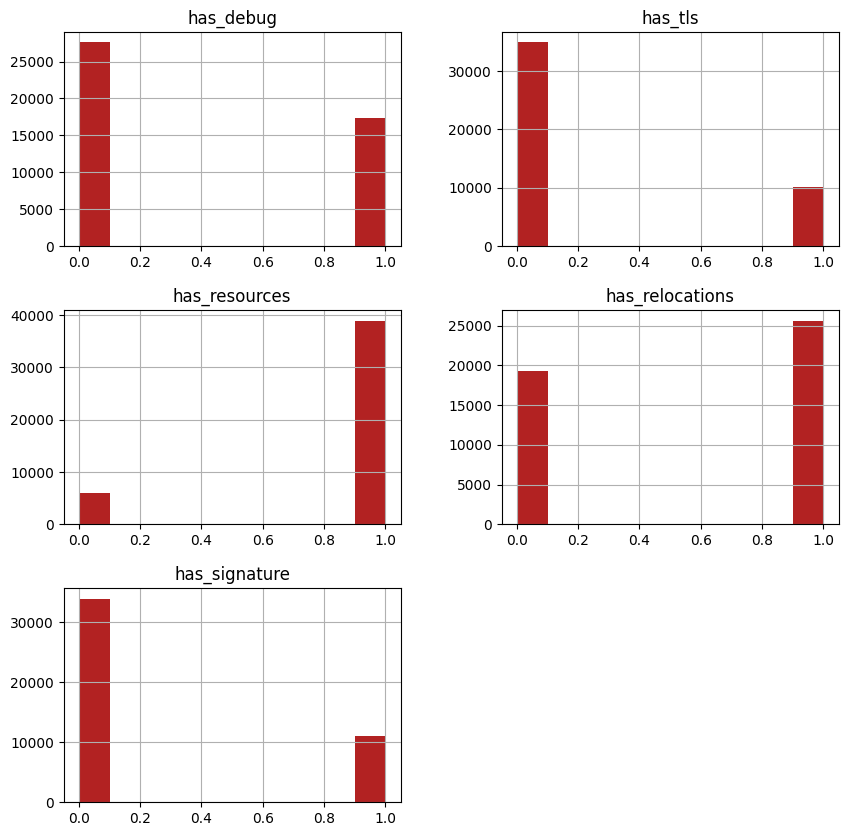

In [225]:
subset_data = X_train_after_binary_missing_values[binary_features]
subset_data.hist(figsize=(10, 10), color=colors[2])
plt.show()

From this method, we achived binary features without any missing values. In addition, if we compare the distribution of each binary feature before (in part 1) and after filling the missing values, we can notice that the dominante category did not change, so the distribution and balance of the data maintained.

The following function will be used to fill missing values in the numeric binary features in the validation and test data:

In [226]:
def missing_values_binary_freq_validation_test (data, features_to_fill, values_to_fill):
    """
    Input: validation/test data, list of binary features, and dictionary of frequent values
    Output: validation data with missing values in the numeric binary features filled by the frequent values
    """
    new_data = data.copy()
    for feature in features_to_fill:
        new_data[feature] = new_data[feature].fillna(values_to_fill[feature])
    return new_data

### Filling missing values in numeric non-binary features

After dealing with outliers, we are left with 4 numeric non-binary features that have missing values: 'paths', 'MZ', 'A', 'B'.<br>
One common approach is to fill the missing values with the median or the mean. In general, if the numeric feature has a roughly symmetric distribution without outliers, using the mean for imputation may be appropriate. On the other hand, if the feature is skewed or contains outliers, using the median can be a more reliable choice.<br>
From the density and the scatter plot we showed after dealing with the outliers, we can notice that except for feature 'B', the rest contain outliers and are not roughly symmetric. Therefore, we will use the median technique for 'paths', 'MZ' and 'A', and the mean technique for 'B'. 

Although these are the only numeric non-binary features that have missing values in the train data, we cannot be sure that there will not be anymore features in the validaion or the test data. Therefore, we will get the values to fill from the functions below, just in case we will need to use them for the validation or test.<br>
We notice from the density and scatter plot, that the rest of the numeric non-binary features ('size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'urls', 'registry', 'printables', 'avlength'). Therefore, if they have missing values in the validaion or test data, we will fill them with their median values in the train data.

In [227]:
def missing_values_numeric_mean (data, features_to_fill):
    """
    input: a data and a list of non binary features that are distributed symmetrically
    output: a data with filled missing values by the mean
    """
    new_data = data.copy()
    mean_values = {}
    for feature in features_to_fill:
        mean = data[feature].mean()
        mean_values[feature] = mean
        new_data[feature].fillna(mean, inplace=True)
    return new_data, mean_values

In [228]:
def missing_values_numeric_median (data, features_to_fill):
    """
    input: a data and a list of non binary features that are not distributed symmetrically
    output: a data with filled missing values by the median
    """
    new_data = data.copy()
    median_values = {}
    for feature in features_to_fill:
        median = data[feature].median()
        median_values[feature]= median
        new_data[feature].fillna(median, inplace=True)
    return new_data, median_values

In [229]:
def missing_values_numeric (data, features_for_mean, features_for_median):
    """
    input: a data, a list of non binary features that are distributed symmetrically and a list of non binary features that are not distributed symmetrically
    output: a data with filled missing
    """
    new_data, mean_values = missing_values_numeric_mean(data, features_for_mean)
    new_data, median_values = missing_values_numeric_median(new_data, features_for_median)
    return new_data, mean_values, median_values

In [230]:
numeric_non_binary_features_symmetric = ['B']
numeric_non_binary_features_non_symmetric = ['paths', 'MZ', 'A', 'size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'urls', 'registry', 'printables', 'avlength']
X_train_after_non_binary_missing_values, mean_values_to_fill, median_values_to_fill = missing_values_numeric(X_train_after_binary_missing_values, numeric_non_binary_features_symmetric, numeric_non_binary_features_non_symmetric)
X_train_after_non_binary_missing_values.isna().sum()

size                      0
vsize                     0
imports                   0
exports                   0
has_debug                 0
has_relocations           0
has_resources             0
has_signature             0
has_tls                   0
symbols                   0
numstrings                0
paths                     0
urls                      0
registry                  0
MZ                        0
printables                0
avlength                  0
file_type_trid            0
file_type_prob_trid       0
A                         0
B                         0
C                      1538
dtype: int64

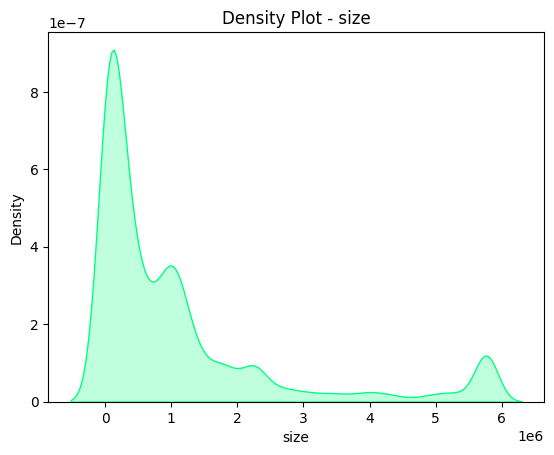

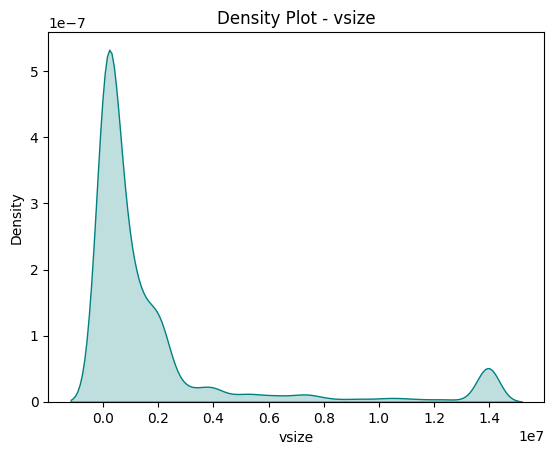

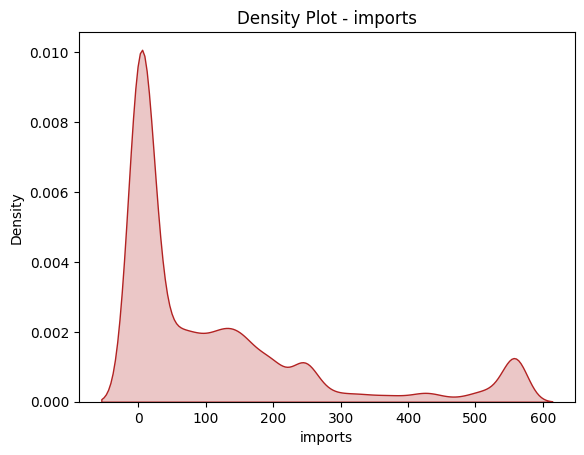

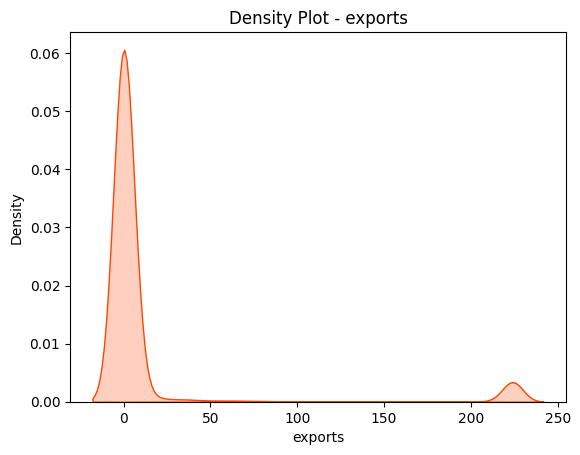

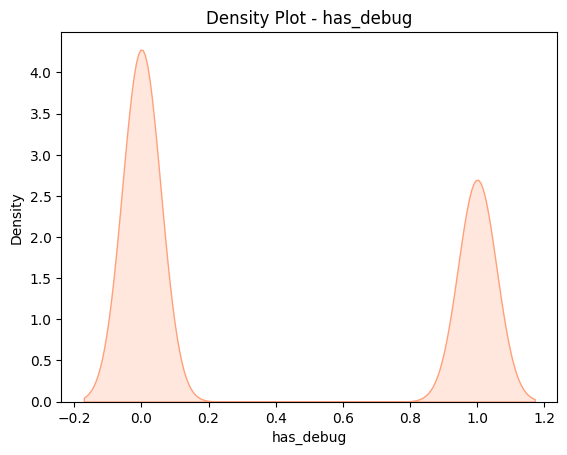

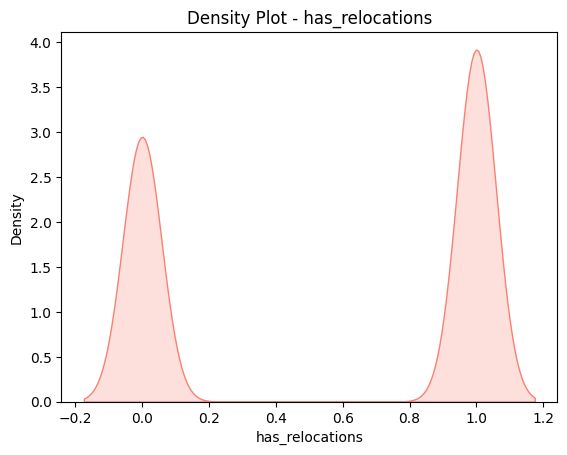

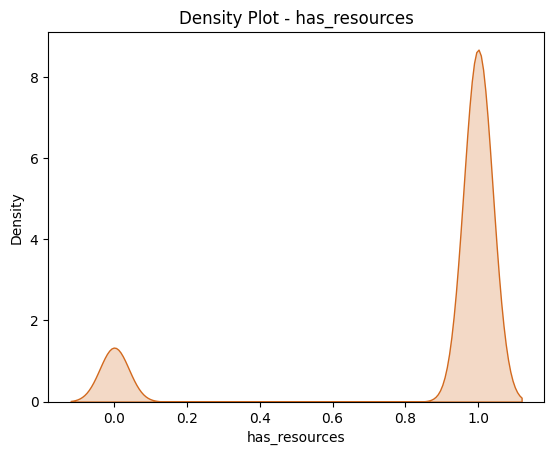

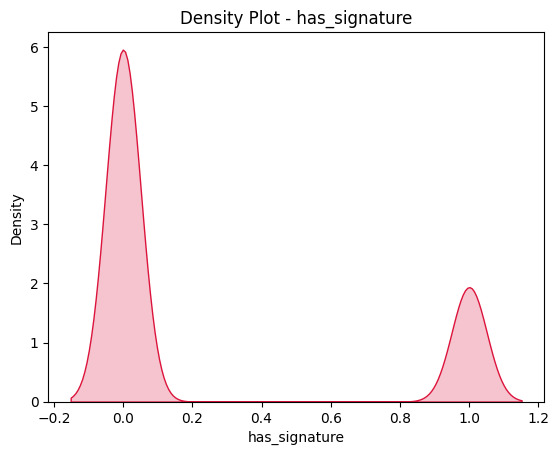

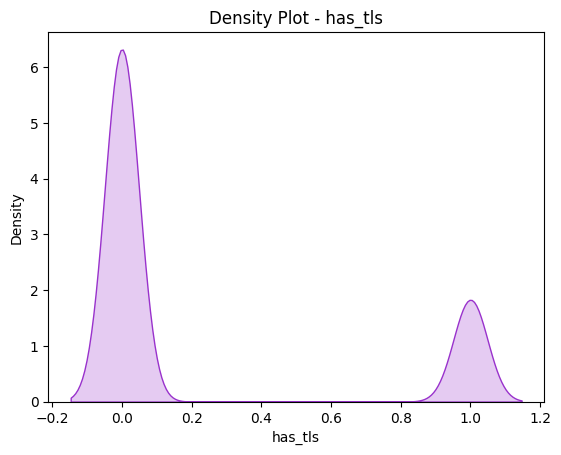

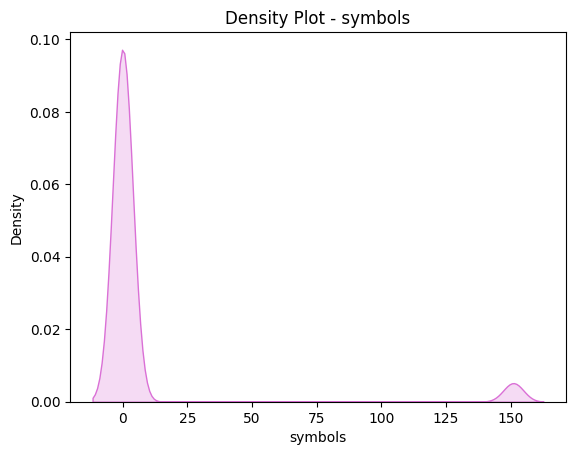

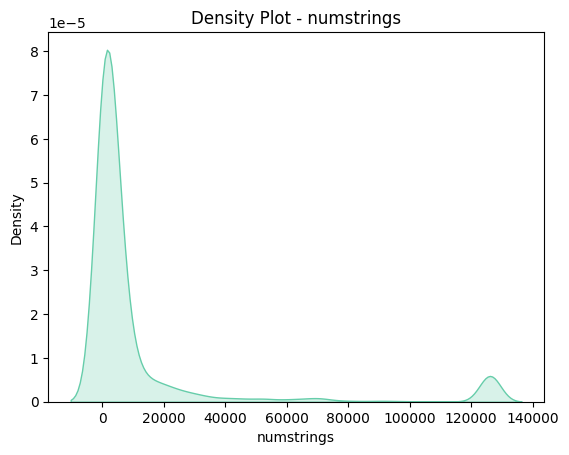

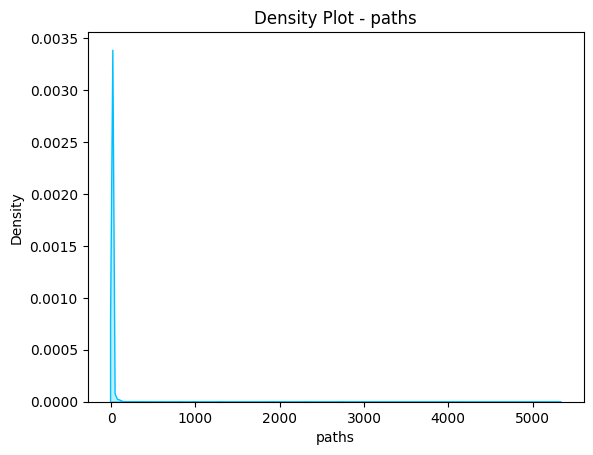

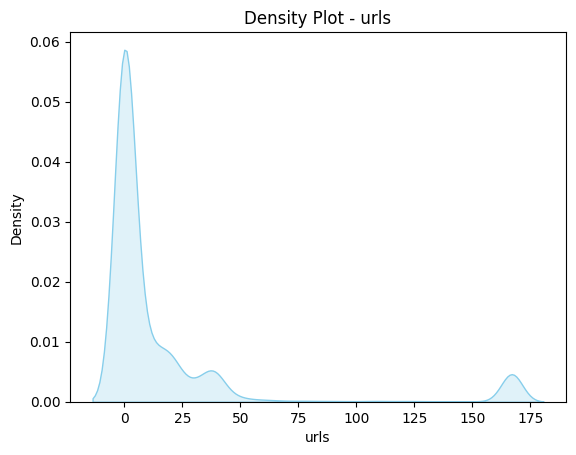

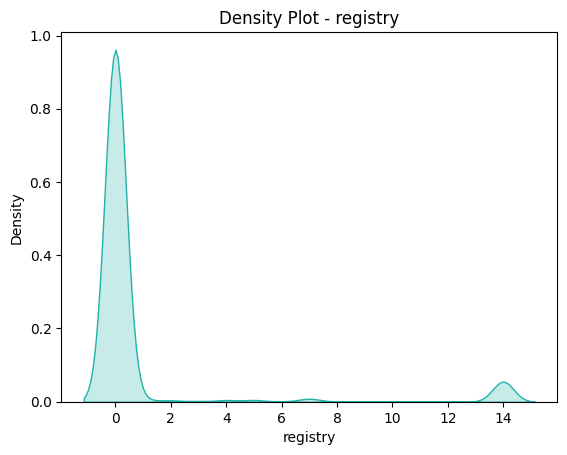

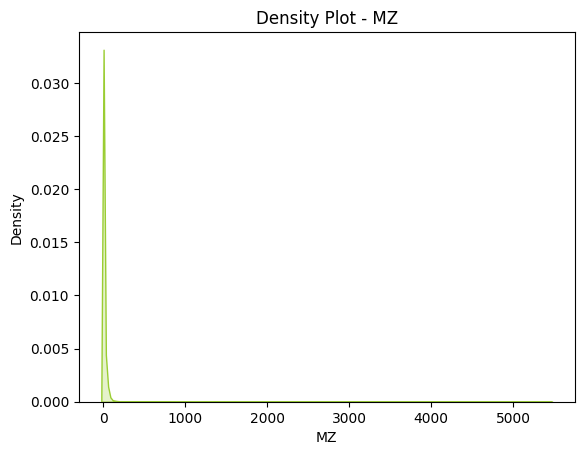

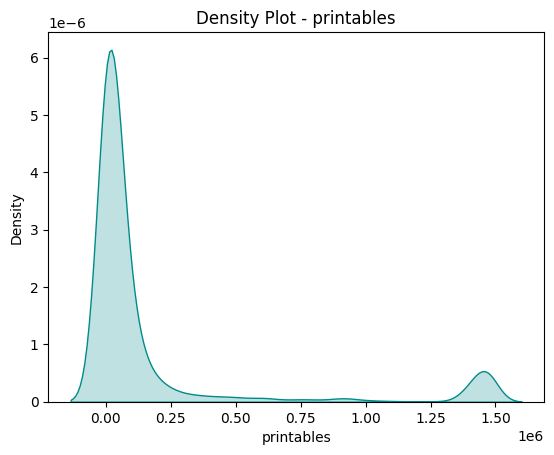

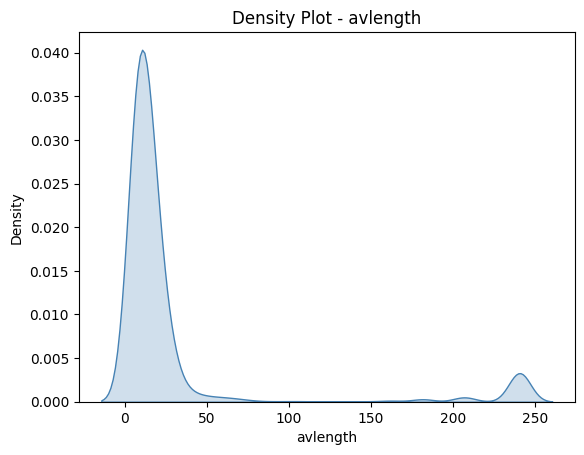

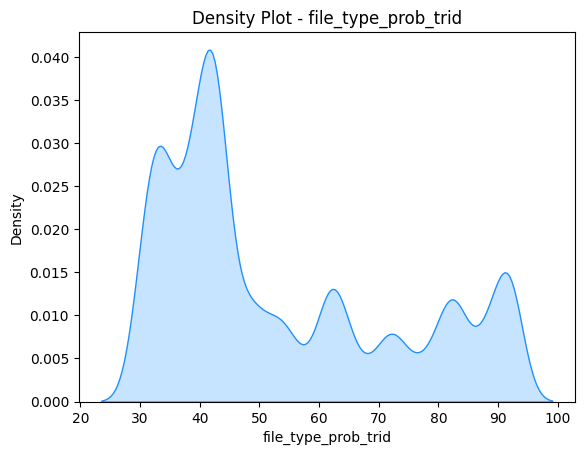

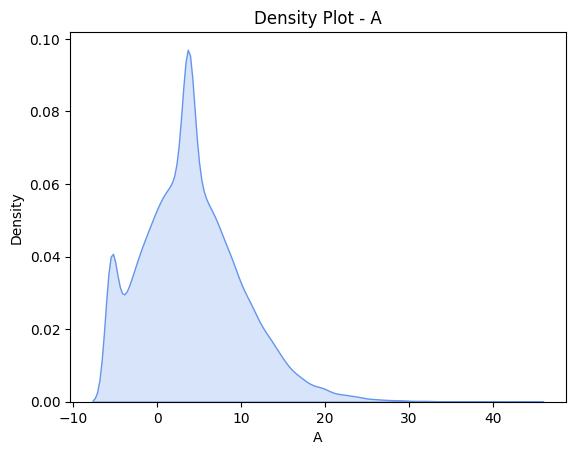

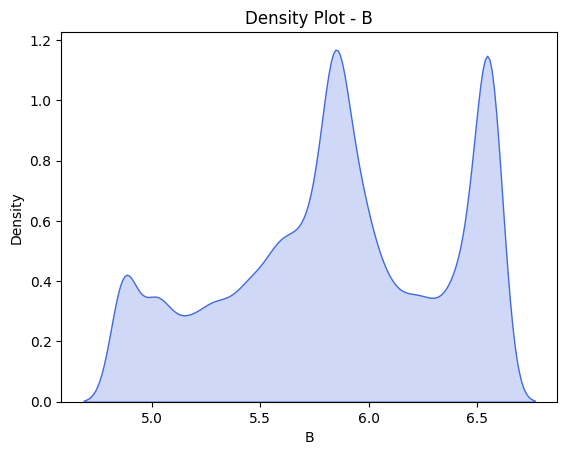

In [231]:
plot_density(X_train_after_non_binary_missing_values, colors)

From the density plots for all the numeric features, we can see that overall the density of each feature did not change drastically.

The functions below will be used to fill the missing values of the numeric non-binary features in the validaion and test data, using the values learned from the train data:

In [232]:
def missing_values_numeric_mean_validaion_test (data, features_to_fill, mean_values_to_fill):
    """
    input: a data and a list of non binary features that are distributed symmetrically and the mean values to fill
    output: a data with filled missing values by the mean
    """
    new_data = data.copy()
    for feature in features_to_fill:
        new_data[feature].fillna(mean_values_to_fill[feature], inplace=True)
    return new_data

In [233]:
def missing_values_numeric_median_validaion_test (data, features_to_fill, median_values_to_fill):
    """
    input: a data and a list of non binary features that are not distributed symmetrically and the values to fill
    output: a data with filled missing values by the median
    """
    new_data = data.copy()
    for feature in features_to_fill:
        new_data[feature].fillna(median_values_to_fill[feature], inplace=True)
    return new_data

In [234]:
def missing_values_numeric_validaion_test (data, features_for_mean, features_for_median, values_for_mean, values_for_median):
    """
    input: a data, a list of non binary features that are distributed symmetrically, a list of non binary features that are not distributed symmetrically and the values to fill with mean and median
    output: a data with filled missing
    """
    new_data = missing_values_numeric_mean_validaion_test(data, features_for_mean, values_for_mean)
    new_data = missing_values_numeric_median_validaion_test(new_data, features_for_median, values_for_median)
    return new_data

We successfully filled the missing values in all the numeric features, and now the last feature we need to deal with is feature 'C'.

### Filling missing values in categorical features

Overall in our train data, there are 2 categorical features ('file_type_trid' and 'C'). In part 1 we noticed that only 'C' has missing values.<br>
We decided to fill the missing values with the Forward-fill method.<br>
The forward-fill method carries forward the last observed category to fill in the missing values. It assigns the value of the previous non-missing entry to the missing entries in the column.<br>
Forward-fill imputation preserves the distribution of the observed values in the column. It does not introduce any new categories or alter the relative frequencies of existing categories.  Forward-fill is a straightforward method to implement and computationally efficient, particularly for large datasets like ours.

In [235]:
def missing_values_categorical_freq (data, features_to_fill):
    """
    input: a data and categorical features
    output: data with filled missing values by forward-fill method
    """
    new_data = data.copy()
    new_data.loc[:,features_to_fill] = new_data.loc[:,features_to_fill].fillna(method = 'ffill')
    return new_data

In [236]:
categorical_features = ['C']
X_train_after_missing_values = missing_values_categorical_freq(X_train_after_non_binary_missing_values, categorical_features)
X_train_after_missing_values.isna().sum()

size                   0
vsize                  0
imports                0
exports                0
has_debug              0
has_relocations        0
has_resources          0
has_signature          0
has_tls                0
symbols                0
numstrings             0
paths                  0
urls                   0
registry               0
MZ                     0
printables             0
avlength               0
file_type_trid         0
file_type_prob_trid    0
A                      0
B                      0
C                      0
dtype: int64

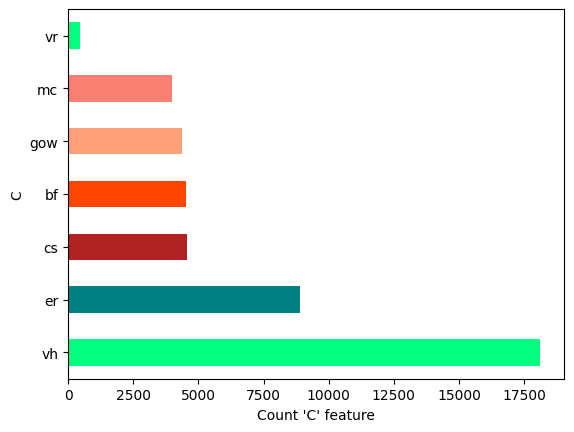

In [237]:
count_categories_C(X_train_after_missing_values, colors[:6])

Finally, we filled the last feature with missing values. As we can notice, the scale of the number of samples in 'C' feature has changed due to filling the missing values, but the dominant category remains the same. In addition, the order of the frequent categories in this feature did not change.

## **4. Dealing with categorical features**

### 'file_type_trid' feature

As we saw in part 1, there are 60 categories that appear less than 100 times. We would like to remove all the samples that have these categories in the 'file_type_trid' feature before encoding. The reason for removing them is that if a category occurs very rarely or has very few instances, it may not provide enough information for the model to learn meaningful patterns. In such cases, removing these categories might help prevent overfitting and improve model generalization.

In [238]:
def remove_samples_file_type_trid_less_than_100_appearences (data):
    """
    input: a data
    output: filtered data including only samples that their category in 'file_type_trid' feature appear more than 100 times
    """
    min_threshold = 100

    # Count the occurrences of each category in the categorical feature
    category_counts = data['file_type_trid'].value_counts()

    # Get the categories that appear less than the minimum threshold
    infrequent_categories = category_counts[category_counts < min_threshold].index.tolist()

    # Filter out samples with infrequent categories
    filtered_data = data[~data['file_type_trid'].isin(infrequent_categories)]

    return filtered_data

In [239]:
X_train_with_label = X_train_after_missing_values.copy()
X_train_with_label['label'] = y_train.values

filtered_X_train_with_label = remove_samples_file_type_trid_less_than_100_appearences(X_train_with_label)

In [240]:
num_categories = filtered_X_train_with_label['file_type_trid'].nunique()
print("After filtering, there are", num_categories, "categories in 'file_type_trid' feature.")

After filtering, there are 28 categories in 'file_type_trid' feature.


After we filter the data, we need to encode the feature in order to make it numeric.

We will use the Binary Encoding. Binary encoding represents each category with binary code. It first encodes each category as an integer, then converts the integer to binary code, and finally creates binary features based on the binary representation. If there are n unique categories, then binary encoding results in the only $\log_2(n)$ features.<br>
In our case, 'file_type_trid' has 28 categories and we would like to avoid a situtaion of large dimesionality. Large dimesionality can happen if we use the standard technique of dummies (that will give us 28-1=27 categories). Binary encoding is useful for categorical features with high cardinality (a large number of unique categories) as it can reduce the dimensionality.

To use the function "BinaryEncoder", we need to import the library "category_encoders" (imported in the start of the project). Also, we imported in the Anaconda: "pip install category_encoders".

In [241]:
def binary_encode_file_type_trid (data):
    """
    input: a data
    output: data after performing binary encoder on the 'file_type_trid' feature
    """
    encoder = ce.BinaryEncoder(cols=['file_type_trid'])
    dfbin = encoder.fit_transform(data['file_type_trid'])
    df = pd.concat([data, dfbin], axis=1)
    df.drop('file_type_trid', axis=1, inplace=True)
    
    # Move 'label' column to the last column position
    columns = df.columns.tolist()
    columns.remove('label')
    columns.append('label')
    df = df[columns]
    return df, encoder

In [242]:
X_train_with_label_encode_file_type_trid, encoder_file_type_trid = binary_encode_file_type_trid(filtered_X_train_with_label)
print("Now in the train data there are", X_train_with_label_encode_file_type_trid.shape[0], "samples and", X_train_with_label_encode_file_type_trid.shape[1], "features.")

Now in the train data there are 44173 samples and 27 features.


The following code uses the encoders we used in the train data for 'file_type_trid' on the validation and test data:

In [243]:
def binary_encode_file_type_trid_validation_test (data, encoder, is_it_test = None):
    """
    Input: validation/test data, the encoder obtained from training data and a flag indicates if the data is test data
    Output: validation data after performing binary encoding on the 'file_type_trid' feature
    """
    new_data = data.copy()
    dfbin = encoder.transform(new_data['file_type_trid'])
    df = pd.concat([new_data, dfbin], axis=1)
    df.drop('file_type_trid', axis=1, inplace=True)

    # Move 'label' column to the last column position if it is a validation data
    if is_it_test == None:
        columns = df.columns.tolist()
        columns.remove('label')
        columns.append('label')
        df = df[columns]
    return df

### 'C' feature

In this feature, there are only 7 categories. Since this number is significantly smaller than the original number of categories in 'file_type_trid' feature, we will consider a different method to encode the 'C' feature without adding new features.

For encoding, we will use frequency encoding. Frequency encoding is a technique used to encode categorical variables based on the frequency (or occurrence) of each category in the dataset. It replaces each category with the percentage of times it appears in the data. This method does not add any new features. Because we added 5 new features in the encoding of 'file_type_trid', we want a method that does not add any new features for this small number of categories feature.

In [244]:
def freq_encoding_C (data):
    """
    input: a data
    output: data after performing frequency encoder on the 'C' feature
    """
    data_new = data.copy()
    category_frequencies = (data_new['C'].value_counts() / len(data)).to_dict()
    fe = data_new.groupby('C').size() / len(data)
    encoded_feature = 'C_freq_encode'
    data_new[encoded_feature] = data_new['C'].map(fe)
    data_new.drop('C', axis=1, inplace=True)

    # Move 'label' column to the last column position
    columns = data_new.columns.tolist()
    columns.remove('label')
    columns.append('label')
    data_new = data_new[columns]
    
    return data_new, category_frequencies

In [245]:
X_train_with_label_after_categorical, encoding_C = freq_encoding_C(X_train_with_label_encode_file_type_trid)
print("Now in the train data there are", X_train_with_label_after_categorical.shape[0], "samples and", X_train_with_label_after_categorical.shape[1], "features.")

Now in the train data there are 44173 samples and 27 features.


The function below, uses the frequencies of each category in 'C' to encode the 'C' feature in the validaion and test data:

In [246]:
def freq_encoding_C_validation_test (data, values_to_encode, is_it_test = None):
    """
    Input: validation/test data, the category frequencies obtained from training data and a flag indicates if the data is test data
    Output: validation/test data after performing frequency encoding on the 'C' feature
    """
    data_new = data.copy()
    encoded_feature = 'C_freq_encode'
    data_new[encoded_feature] = data_new['C'].map(values_to_encode)
    data_new.drop('C', axis=1, inplace=True)

    if is_it_test == None:
        columns = data_new.columns.tolist()
        columns.remove('label')
        columns.append('label')
        data_new = data_new[columns]

    return data_new

#### How do the categorical features distribute?

Now that we have numeric features instead of the categorical features ('file_type_trid' and 'C'), we would like to see how do they distribute:

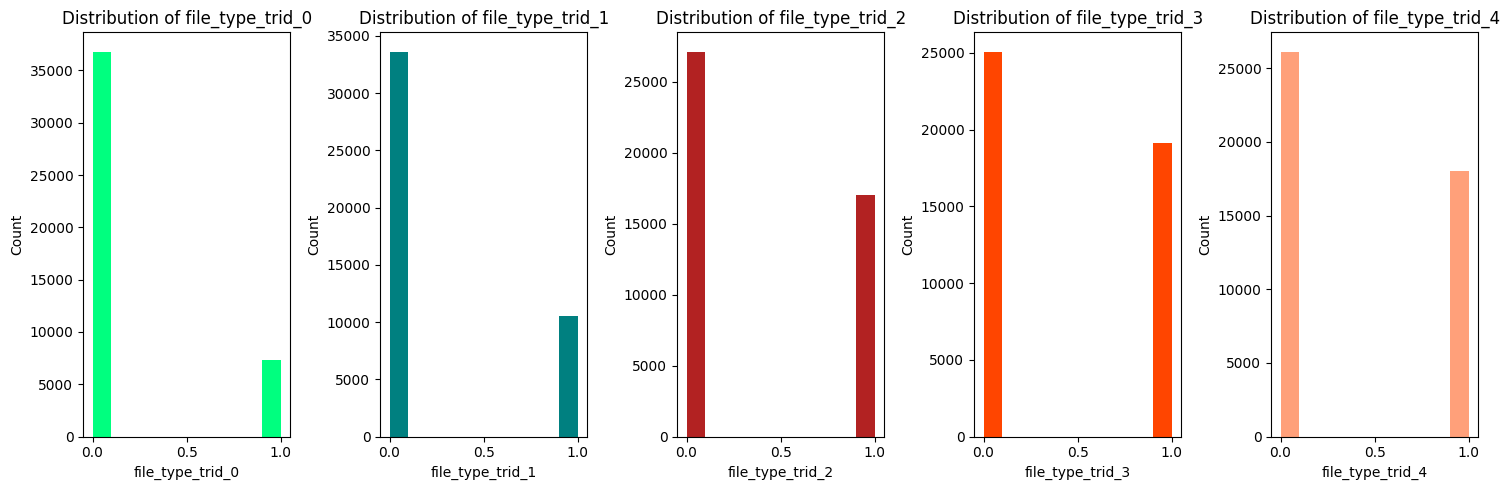

In [247]:
encoded_features = ['file_type_trid_0', 'file_type_trid_1', 'file_type_trid_2', 'file_type_trid_3', 'file_type_trid_4']
num_features = len(encoded_features)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(15, 5))

for i, feature in enumerate(encoded_features):
    axes[i].hist(X_train_with_label_after_categorical[feature], color=colors[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of {feature}')
    
plt.tight_layout()
plt.show()

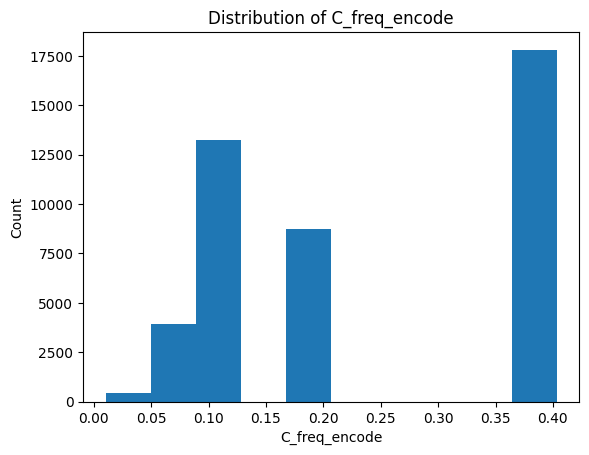

In [248]:
plt.hist(X_train_with_label_after_categorical['C_freq_encode'])
plt.xlabel('C_freq_encode')
plt.ylabel('Count')
plt.title('Distribution of C_freq_encode')
plt.show()

'C_freq_encode" is non-binary numeric feature, so we want to see it's density:

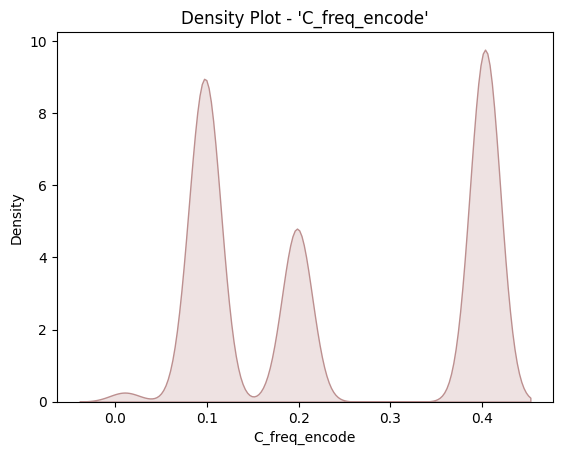

In [249]:
# Plot the density using kdeplot
sns.kdeplot(data=X_train_with_label_after_categorical['C_freq_encode'], fill=True, color=colors[-6])
    
# Set title and labels
plt.title("Density Plot - 'C_freq_encode'")
plt.xlabel('C_freq_encode')
plt.ylabel("Density")
    
# Display the plot
plt.show()

As we can notice, neither 'file_type_trid' feature or 'C_freq_encode' feature distribute normally, because the encoded features of 'file_type_trid' are binary and 'C_freq_encoded' has usually only frequences of 0.1, 0.2, 0.4.

Let's see if the numerical 'C_freq_encode' feature has any outliers:

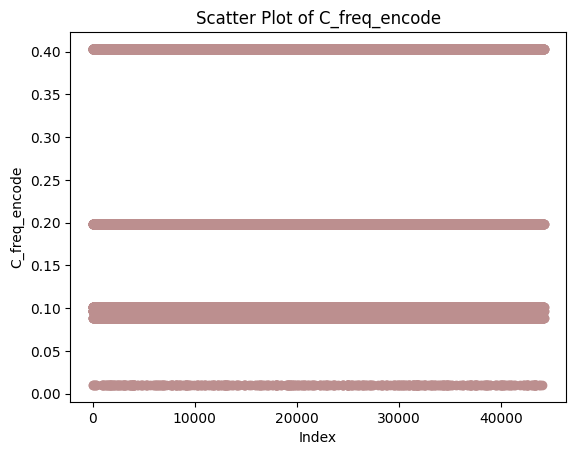

In [250]:
plt.scatter(range(len(X_train_with_label_after_categorical['C_freq_encode'])), X_train_with_label_after_categorical['C_freq_encode'], color=colors[-6])
plt.xlabel('Index')
plt.ylabel('C_freq_encode')
plt.title('Scatter Plot of C_freq_encode')
plt.show()

Because the new feature is based on frequencies, there are no outliers.

Now that all of our features are numeric, we want to check again the correlation map:

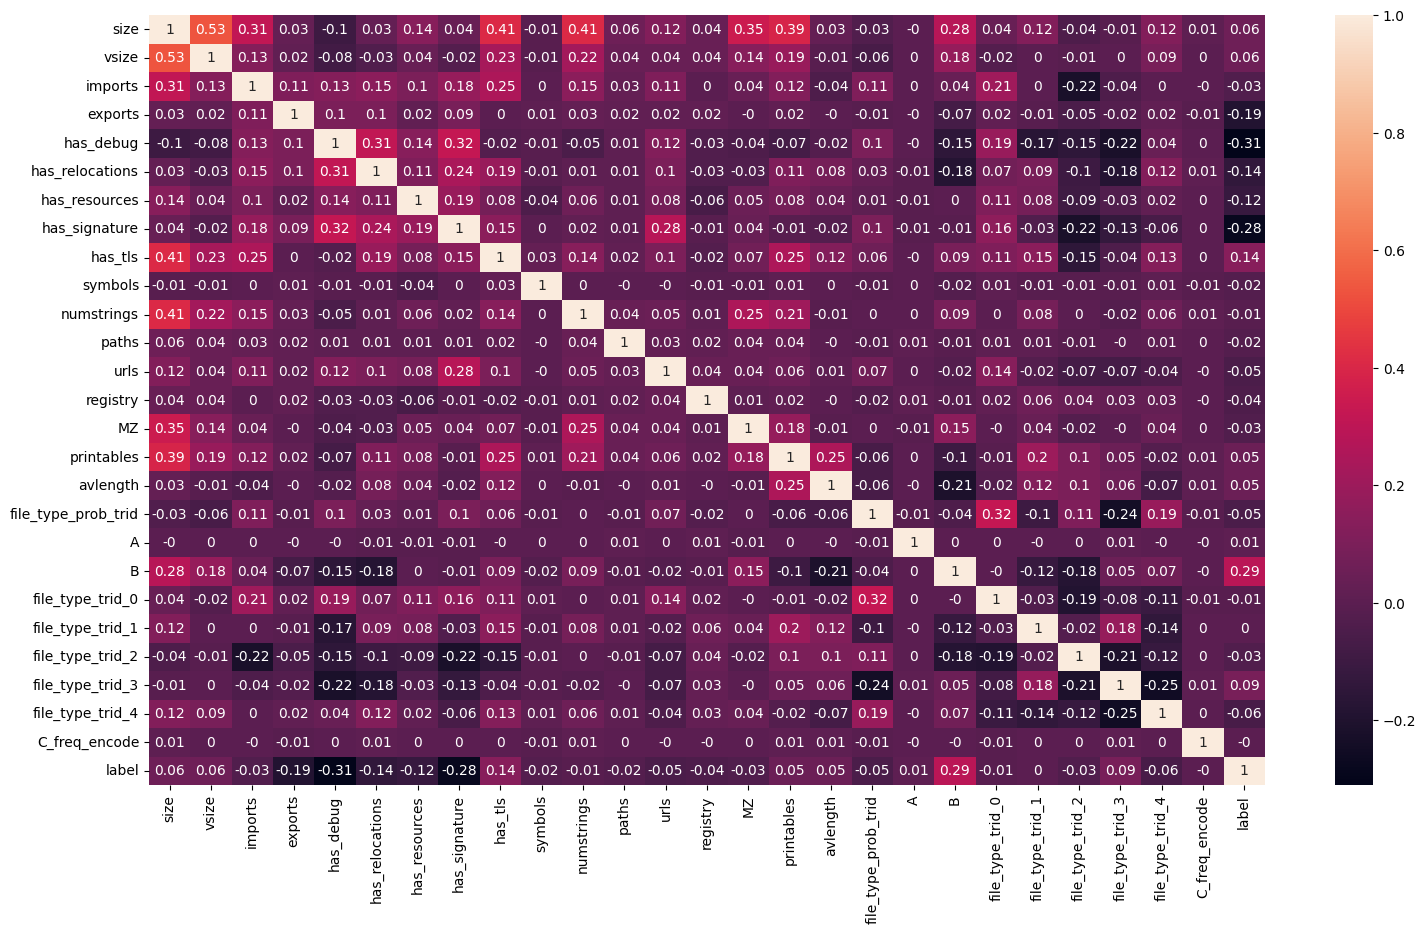

In [251]:
corr_mat = X_train_with_label_after_categorical.corr().round(2)
plt.figure(figsize = (18,10))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, annot=True)
plt.show()

We can see that there are no new strong correlation added and the new features do not have a strong correlation with the label. In addition, the strong correlations we had in part 1 (before the pre-prossecing) reduced and therefore we do not have any strong correlations that are above 0.53 (between 'size' and 'vsize').

## **5. Dimension reducation**

Now that we dealt with the outliers, missing values and categorical features in the train data, we want to ask ourselves: **Is the dimensionality of the train data is too large?**<br>
If the number of features is significantly larger than the number of observations, it indicates a high-dimensional dataset. In our case, there are 26 features and 59,058 observations. Therefore, **we do not have high-dimansional train data**.

**Why can high-dimentional data create a problem?**<br>
1. Bias-Variance tradeoff-  In high dimensional data, the number of potential relationships and patterns increases exponentially with the number of features. This can lead to an increase in model variance, as the model becomes more susceptible to capturing noise in the training data.
2. Overfitting- High dimensionality increases the risk of overfitting, where a model becomes too complex and starts to memorize the noise or idiosyncrasies of the training data instead of learning generalizable patterns. Overfitting can result in poor generalization to the tset data, leading to reduced model performance on test or real-world examples.
3. Interpretability and Understanding- High dimensional models are often more difficult to interpret and understand. When the number of features is large, it becomes challenging to explain the relationships and interactions between variables.
4. Feature Redundancy and Irrelevance- High dimensionality often leads to the presence of redundant and irrelevant features. Redundant features provide redundant information, contributing little to the predictive power of the model. Irrelevant features introduce noise and can mislead the model.
5. Training models on high dimensional data requires more computational resources (memory and processing power). This can lead to longer training times and slower model inference, making the overall process inefficient.

In this part, we will show and use 2 common methods for dimensionality reduction: **PCA and feature selection**. Later, we will choose the method that will provide the better performance.

PCA needs each column to have zero mean. In addition, it works better when all features share the same variance. We decided to use variance 1.

In [252]:
def split_for_dimentional_reduction(data):
    """
    input: a data
    output: X train, y train, X test and y test after splitting & X train and y train after normalizing
    """
    #split to train and test
    X, y = data.values[:,:-1], data.values[:, -1]
    X_train_raw ,X_test_raw ,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state= 42, shuffle=True)

    # normalize to have 0 mean and 1 variance (according to train distribution)
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train_raw)
    X_test_normalized = scaler.transform(X_test_raw)

    return X_train_raw ,X_test_raw, X_train_normalized, X_test_normalized, y_train, y_test

In [253]:
X_train_raw ,X_test_raw, X_train_normalized, X_test_normalized, y_train, y_test = split_for_dimentional_reduction(X_train_with_label_after_categorical)

### PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique widely used in machine learning and data analysis. Its primary goal is to transform a high-dimensional dataset into a lower-dimensional space while retaining as much information as possible. Its ability to reduce dimensionality while preserving important information makes it a valuable tool for improving the efficiency and interpretability of machine learning models.

*How does it work?*

PCA typically begins with standardizing the input data by subtracting the mean and scaling the features to have unit variance. The next step involves calculating the covariance matrix of the standardized data. After diagonalizing the matrix, the technique sorts the eigenvectors and eigenvalues in descending order. Typically, the top r eigenvectors are chosen, where r is the desired number of dimensions for the lower-dimensional space. The matrix $\hat{V}$ is made out of thouse vectors. Finally, for every new sample **x**, PCA uses $\hat{V}^\intercal$(**x** - **μ**).

In the PCA function, the main hyper-parameter is 'n_components'- the number of components to keep. We will use the cross-validation technique to try and find the best number for 'n_components'. This method evaluates the performance of the model with different numbers of components. This can help assess how the performance varies across different values of 'n_components' and choose the one that provides the best trade-off between simplicity and performance.

We want a certain number for features to explain at least 99% of train data. We will use the following code:

In [254]:
def pca(data: np.array, p: float, feature_names: list) -> np.array:
    """
    input: data, float in the range (0,1] and features list
    output: array of principal components explaining (100*p)% of the variance
    """
    new_data = data.copy()
    pca = PCA()
    pca.fit(new_data)
    var_explain = pca.explained_variance_ratio_
    var_combo = np.cumsum(var_explain)
    min_components = np.argmax(var_combo > p) + 1
    pca = PCA(n_components=min_components)
    transformed_data = pca.fit_transform(new_data)
    selected_feature_indices = np.argsort(pca.components_)[::-1][:min_components]
    selected_feature_names = [feature_names[i] for i in selected_feature_indices.flatten()]
    return pca.components_, selected_feature_names

In [255]:
components, selected_features_pca = pca(X_train_normalized,0.99, list(X_train_with_label_after_categorical.columns[:-1]))
n_components = len(components)
print(f'Number of components which preserve at least 99% of the variance: {n_components}.')

Number of components which preserve at least 99% of the variance: 26.


In this case, we are left with the same number of features. This does not help us to reduce dimensionality, therefore **we will not use the PCA method**.

### Feature selection

Feature selection is a process in machine learning that involves selecting a subset of relevant features or variables from the original set of available features. The goal of feature selection is to improve model performance, reduce overfitting, enhance interpretability, and reduce computational complexity by focusing on the most informative and influential features.

*How does it work?*

There are 2 common strategies to acchive feature selection:<br>
1. Forward selection- Start with an empy feature set and add features at each step.
2. Backward selection- Start with a full feature set and discard features at each step.

In order to choose the strategy we want to apply on our data, we will try them both and compare the two.

Our features are already on a similar scale, therefore normalization is necessary for feature selection. In this case, the relative importance of each feature can be assessed without the need for normalization.

The following codes (get_sigma_hat_squared and get_mallows_cp_score) needed in both backward and forward selection:

In [256]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    """
    input: data and labels
    output: float - the sigma hat squared.
    """
    X_copy = X.copy()
    y_copy = y.copy()
    model = LinearRegression()
    model.fit(X_copy, y_copy)
    RSS = np.sum((y_copy - model.predict(X_copy))**2)
    n = X_copy.shape[0]
    features = X_copy.shape[1]
    sigma_hat_squared = (RSS) / (n - features - 1)
    return sigma_hat_squared

In [257]:
def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    """
    input: data, labels and the estimate for noise variance
    output: mallow cp score for given data
    """
    X_copy = X.copy()
    y_copy = y.copy()
    n = X_copy.shape[0]
    d = X_copy.shape[1]
    model = LinearRegression()
    model.fit(X_copy, y_copy)
    mse = mean_squared_error(y, model.predict(X_copy))
    Cp = mse + 2 * ((d+1)/n) * sigma_hat_squared
    return Cp

**Backward selection:**

In [258]:
def remove_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict: #delete- returns a list with one feature less. How? check the score without every feature and delete the feature that gives the best score without it
    """
    input: data, labels, list of indexes which represent the features which are already included and the estimate for noise variance
    output: dictionary with list of features including the best subset of features and the cp score of the model for that subset
    """
    best_score = np.inf
    index_to_delete=0
    
    for feature in range(len(current_features)):
        X_copy = X.copy()
        current_features_copy = current_features.copy()
        current_features_remove = current_features_copy[:feature] + current_features_copy[feature+1:]
        sub_X = X_copy[ : , current_features_remove]
        Cp = get_mallows_cp_score(sub_X, y.copy(), sigma_hat_squared)
        if Cp < best_score:
            best_score = Cp
            index_to_delete = feature
    best_features_lst = current_features[:index_to_delete] + current_features[index_to_delete+1:]
    return {'features':sorted(best_features_lst),'score':best_score}

In [259]:
def backward_selection(X: np.array, y: np.array) -> List[int]:
    """
    input: data and labels
    output: a sorted list containing the indexes of the selected features
    """
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    # set initial features to all features
    current_features = list(range(X.shape[1]))
    models_lst = []
    #perform backward selection
    while len(current_features) > 1:
        # remove feature
        model = remove_feature(X, y, current_features, sigma_hat_squared)
        #update
        current_features = model['features']
        models_lst.append(model)

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

**Forward selection:**

In [260]:
def add_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    """
    input: data, labels, list of indexes which represent the features which are already included and the estimate for noise variance
    output: dictionary with list of features including the best subset of features
    """
    best_score = np.inf
    index_to_add=0
    
    for feature in range(X.shape[1]):
        if feature not in current_features:
            X_copy = X.copy()
            current_features_copy = current_features.copy()
            current_features_copy.append(feature)
            sub_X = X_copy[:, current_features_copy]
            Cp = get_mallows_cp_score(sub_X, y.copy(), sigma_hat_squared)
            if Cp < best_score:
                best_score = Cp
                index_to_add = feature
    
    best_features_lst = current_features + [index_to_add]
    return {'features': sorted(best_features_lst), 'score': best_score}

In [261]:
def forward_selection(X: np.array, y: np.array) -> List[int]:
    """
    input: data and labels
    output: list of indexes for the selected features
    """
    # Calculate error on model with no features
    sigma_hat_squared = get_sigma_hat_squared(X, y)
    # Set initial features to an empty list
    current_features = []
    models_lst = []
    # Perform forward selection
    while len(current_features) < X.shape[1]:
        # Add feature
        model = add_feature(X, y, current_features, sigma_hat_squared)
        # Update current features
        current_features = model['features']
        models_lst.append(model)
    
    # Returning features of best model, based on mcp score
    best_model = min(models_lst, key=lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

**Comparison between backward and forward selection:**

In [262]:
selected_features_backward_index = backward_selection(X_train_raw, y_train)
print(f'number of selected features by backward: {len(selected_features_backward_index)}')

selected_features_forward_index = forward_selection(X_train_raw, y_train)
print(f'number of selected features by forward: {len(selected_features_backward_index)}')

number of selected features by backward: 20
number of selected features by forward: 20


In [263]:
# calculate the test MSE for each reduced dataset for backward
x_backward_reduced_train = X_train_raw[:,selected_features_backward_index]
x_backward_reduced_test = X_test_raw[:,selected_features_backward_index]

# calculate the test MSE for each reduced dataset for forward
x_forward_reduced_train = X_train_raw[:,selected_features_forward_index]
x_forward_reduced_test = X_test_raw[:,selected_features_forward_index]

model_backward = LinearRegression()
model_forward = LinearRegression()

model_backward.fit(x_backward_reduced_train, y_train)
model_forward.fit(x_forward_reduced_train, y_train)

test_mse_backward = mean_squared_error(y_test, model_backward.predict(x_backward_reduced_test))
test_mse_forward = mean_squared_error(y_test, model_forward.predict(x_forward_reduced_test))
train_mse_backward =  mean_squared_error(y_train, model_backward.predict(x_backward_reduced_train))
train_mse_forward = mean_squared_error(y_train, model_forward.predict(x_forward_reduced_train))

print(f'MSE train - backward: {round(train_mse_backward,4)}')
print(f'MSE test - backward: {round(test_mse_backward,4)}')
print(f'MSE train - forward: {round(train_mse_forward,4)}')
print(f'MSE test - forward: {round(test_mse_forward,4)}')

MSE train - backward: 0.1808
MSE test - backward: 0.1832
MSE train - forward: 0.1808
MSE test - forward: 0.1832


As we can see, the backward and forward selections gave us the same number of features and the same test MSE and train MSE. 

**We decided to complete the process with the backward selection method.**

In [264]:
def features_backward (selected_features_index, data):
    """
    input: index of features to keep
    output: list of features to keep
    """
    features_names = list(data.columns[:-1])
    selected_features_backward = []
    for i in selected_features_index:
        selected_features_backward.append(features_names[i])
    return selected_features_backward

In [265]:
selected_features_backward = features_backward(selected_features_backward_index, X_train_with_label_after_categorical)
print("The features selected by the backward selection method are:", selected_features_backward,"\n")
print("The features not selected by the backward selection method are:")
for i in list(X_train_with_label_after_categorical.columns[:-1]):
    if i not in selected_features_backward:
        print(i)

The features selected by the backward selection method are: ['size', 'exports', 'has_debug', 'has_resources', 'has_signature', 'has_tls', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'B', 'file_type_trid_0', 'file_type_trid_1', 'file_type_trid_2', 'file_type_trid_3', 'file_type_trid_4'] 

The features not selected by the backward selection method are:
vsize
imports
has_relocations
file_type_prob_trid
A
C_freq_encode


After looking at the correlation matrix we did after dealing with categorical features, we can notice that the six features deleted have very low correlation with the label. This is a possible reason that the feature selection method decided to remove them. 

We can benefit from reducing the number of features and therefore reducing dimentionality in several ways:<br>
1. Reduced overfitting- Backward selection can help mitigate overfitting issues by removing features that may introduce noise or unnecessary complexity to the model. Overfitting occurs when the model becomes too closely fitted to the train data and performs poorly on unseen data.
2. Improved computational efficiency- With fewer features, the computational burden of training and evaluating the model is reduced. Removing irrelevant or redundant features can speed up the training process and make predictions faster, especially when dealing with large datasets.

Although we gain important things from reducing dimentionality, there is a potential loss of information. While backward selection can help identify irrelevant features, it is important to note that removing variables can also result in a loss of information. If a feature that is truly important for predicting the target variable is eliminated during the selection process, the model's performance may suffer.

Now we will apply the dimensional reduction on the train data:

In [266]:
def dimentional_reduction_with_backward_selection (data):
    """
    input: data
    output: list of features to keep
    """
    X, y = data.values[:,:-1], data.values[:, -1]
    selected_features_backward_index = backward_selection(X, y)
    selected_features_backward = features_backward(selected_features_backward_index, data)
    return selected_features_backward

In [267]:
selected_features_reduce_dimention = dimentional_reduction_with_backward_selection(X_train_with_label_after_categorical)
X_train_with_label_after_dimentional_reduction = X_train_with_label_after_categorical.loc[:,selected_features_reduce_dimention]
X_train_with_label_after_dimentional_reduction['label'] = X_train_with_label_after_categorical['label']

In [268]:
X_train_with_label_after_dimentional_reduction.shape

(44173, 21)

The new train data has the same number of samples (44,173) and has the new reduced number of features (instead of 26, there are now 20 features). The last column is the label.

Before we proceed, we want to work on the previous of the data- when there is a 'X' (the data itself) and 'y' (the label).

In [269]:
X_train_after_dimentional_reduction = X_train_with_label_after_dimentional_reduction.iloc[:,:-1]
y_train = X_train_with_label_after_dimentional_reduction.iloc[:,-1]

## **6. Feature engineering**

Feature engineering is an essential step in a machine learning project. In this step we can create new features for the existing ones (instead or on top of them). <br>
By providing the model with more informative and relevant features, we can potentially improve the performance and accuracy of the model. When creating new features instead of the existing ones, it can reduce dimentionality.<br>
When dealing with feature engineering, we will relly on domain knowledge and the meaning of each feature. By incorporating domain knowledge and relevant information into the features, we can enhance the model's ability to make accurate predictions. Feature engineering can contribute to model interpretability by creating features that are easier to understand and interpret. By transforming the data into meaningful representations, it becomes easier to explain the model's predictions.

Let's remind ourselves the features we have after feature selection:

In [270]:
print("The feature are:", selected_features_backward)

The feature are: ['size', 'exports', 'has_debug', 'has_resources', 'has_signature', 'has_tls', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'MZ', 'printables', 'avlength', 'B', 'file_type_trid_0', 'file_type_trid_1', 'file_type_trid_2', 'file_type_trid_3', 'file_type_trid_4']


#### Creating a new feature out of 'has_debug' and 'has_signature'

- **'has_debug'**- Whether a file has a debug section.<br>
Malicious files may attempt to disguise their true nature by masquerading as legitimate files. One way they can do this is by omitting or removing the debug section, as it is typically unnecessary for the execution of the malicious payload. Thus, the absence of a debug section may raise suspicions that a file could be malicious.<br>
With this information, we can learn that a file that has '0' in 'has_debug' has a high chance of being classified as malicious file ('1').
- **'has_signature'**- Whether a file has a signature.<br>
Digital signatures are cryptographic mechanisms used to verify the authenticity and integrity of files. Legitimate software developers often sign their files with digital signatures to ensure that the files have not been tampered with and can be trusted. Therefore, the presence of a digital signature in a file can indicate that it has been verified by the software developer and is more likely to be non-malicious.<br>
We can learn that a file that has '0' in 'has_signature' has a high chance of being classified as malicious file ('1').

From this information, we can notice that a file that has '0' both in 'has_debug' and 'has_signature' will probably be classified as a malicious file ('1'). Therefore, we understand that these two features have similar affect on the classification, based on domain knowledge.<br>

We decided to create a new feature 'has_reliability':<br>
If a file has a debug section and a signature, it means that this file's reliability is high. Therefore the file's value in the new feature will be 1.<br>
In any other case, we assume that the file is not reliable, therefore the file's value in the new feature will be 0.

In [271]:
def feature_engineering_has_reliability(data, feature1, feature2):
    """
    input: data and two features
    output: data after creating a new feature and removing the two input features
    """
    data_copy = data.copy()
    data_copy['has_reliability'] = (data_copy[feature1] == 1.0) & (data_copy[feature2] == 1.0)
    data_copy['has_reliability'] = data_copy['has_reliability'].astype(float)
    data_drop = data_copy.drop([feature1, feature2], axis=1)
    return data_drop

In [272]:
X_train_after_feature_engineering_has_reliability = feature_engineering_has_reliability(X_train_after_dimentional_reduction, 'has_debug', 'has_signature')

In [273]:
print("New number of features is:", X_train_after_feature_engineering_has_reliability.shape[1])

New number of features is: 19


We can see that by performing feature engineering we also reduced the number of features, meaning we reduce the possibility of dimensionality problems.

After performing the models in part 3, we noticed that when applying this feature engineering, the validation AUC is lower than when not applying it. Therefore, we decided not to use this step.

#### Creating a new feature out of 'numstrings' and 'printables'

- **'numstrings'**-The number of printable strings that are at least five printable characters long.<br>
Malicious files often contain specific strings that are indicative of malicious behavior. By analyzing the number of printable strings that meet a certain length threshold, such as at least five characters, we can identify potentially malicious files that exhibit a higher frequency of such strings.
- **'printables'**- Number of printable characters.<br>
This feature can provide insights into the level of obfuscation and readability within a file.

We want to create a new feature 'numstrings_percentage' that will be ('numstrings' &#247; 'printables'). This will show the percentage of 'numstrings' in 'printables', meaning the percentage of printables string that are at least 5 printable characters long, out of all the printables in the file.

In [274]:
def feature_engineering_numstrings_percentage(data, feature1, feature2):
    """
    input: data and two features
    output: data after creating a new feature and removing the two input features
    """
    data_copy = data.copy()

    # Create the 'numstrings_percentage' feature as float
    data_copy['numstrings_percentage'] = data_copy[feature1] / data_copy[feature2]
    data_copy['numstrings_percentage'] = data_copy['numstrings_percentage'].astype(float)

    # Drop the 'numstrings' and 'printables' features
    data_drop = data_copy.drop([feature1, feature2], axis=1)

    return data_drop

In [275]:
X_train_after_feature_engineering_numstrings_percentage = feature_engineering_numstrings_percentage(X_train_after_dimentional_reduction, 'numstrings', 'printables')

In [276]:
X_train_after_feature_engineering_numstrings_percentage.shape

(44173, 19)

We can see that also in this feature engineering we reduced the number of features, meaning we reduce the possibility of dimensionality problems.

After performing the models in part 3, we noticed that when applying this feature engineering, like in the previous one, the validation AUC is lower than when not applying it. Therefore, we decided not to use this step.

## **7. Data transformation**

Data transformation refers to the process of modifying and manipulating the original data to make it more suitable for modeling. The goal of data transformation is to improve the quality and structure of the data, normalize distributions, or transform variables to meet the assumptions of statistical models. Data transformation is an essential step in the data preprocessing pipeline as it helps in improving the quality, interpretability, and performance of machine learning models.

Data transformation methods can be broadly categorized into two types:<br>
1. Feature-wise transformations- methods that operate on individual features or variables in the dataset.
2. Dataset-level transformations- methods that consider the dataset as a whole and may involve combining, aggregating, or encoding variables.

We chose to transform the data using feature-wise transformations because we have a large variety of features types. In our project, we would like to handle each feature independently of the other features.

### Min-Max scaling

In this step, we will transform the data using "Min-Max scaling". This data transformation method scales numerical features to a specific range, typically between 0 and 1. It preserves the relative relationships between data points while ensuring that the scaled values fall within the desired range.

In [277]:
def transformation_min_max (data):
    """
    input: data
    output: data after performing min-max scaling
    """
    data_copy = data.copy()
    # Initialize the scaler
    min_max_scaler = MinMaxScaler()
    #fit the scaler
    min_max_scaler.fit(data_copy)
    #transform the data using the scaler
    scaled_data = min_max_scaler.transform(data_copy)
    # Convert the scaled data to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
    return scaled_df

In [278]:
X_train_after_transformation_min_max = transformation_min_max(X_train_after_dimentional_reduction)

#### Standardizaion (Z-score normalization)

Standardization, also known as Z-score normalization, is a technique used to transform numerical data to have a mean of 0 and a standard deviation of 1. This normalization process is useful when working with features that have different scales or units.

In [279]:
def transformation_standardizaion (data):
    """
    input: data
    output: data after performing standardizaion
    """
    data_copy = data.copy()
    # Initialize the scaler
    standard_scaler = StandardScaler()
    # Fit the scaler
    standard_scaler.fit(data_copy)
    #transform the data using the scaler
    scaled_data = standard_scaler.transform(data_copy)
    # Convert the scaled data to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
    return scaled_df

In [280]:
X_train_after_transformation_standardizaion = transformation_standardizaion(X_train_after_dimentional_reduction)

After performing the models, we noticed that min-max scaling method gave a better validation AUC score. Therefore, we will use min-max scaling and not standardization.

## **Pre Prossesing Functions**

We want to gather all the pre processing function we decided to use in one main function to apply it in a convenient and efficient way on the train data.

In [281]:
def pre_prossesing_on_train(data, label):
    """
    input: data and labels
    output: data and labels after performing all pre prossesing functions and features to remove
    """

    # Lists made based on the type of the features
    non_binary_features = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'file_type_prob_trid', 'A', 'B']
    binary_features = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']
    numeric_non_binary_features_symmetric = ['B']
    numeric_non_binary_features_non_symmetric = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'avlength', 'printables', 'MZ', 'file_type_prob_trid', 'A']
    categorical_features = ['file_type_trid', 'C']

    # Dealing with outliers
    data_after_outliers = deal_with_outliers_winsorization(data, non_binary_features)

    # Dealing with missing values
    data_after_binary_missing_values, values_to_fill_binary_features = missing_values_binary_freq(data_after_outliers, binary_features) # Filling missing values in numeric binary features
    data_after_non_binary_missing_values, values_to_fill_mean, values_to_fill_median = missing_values_numeric(data_after_binary_missing_values, numeric_non_binary_features_symmetric, numeric_non_binary_features_non_symmetric) # Filling missing values in numeric non-bunary features
    data_after_missing_values = missing_values_categorical_freq(data_after_non_binary_missing_values, categorical_features) # Filling missing values in categorical features

    # Combine the data with it's label
    data_with_label = data_after_missing_values.copy()
    data_with_label['label'] = label.values

    # Dealing with categorical features
    data_with_label_after_removing_samples_file_type_trid = remove_samples_file_type_trid_less_than_100_appearences(data_with_label) # Filtered data including only samples that their category in 'file_type_trid' feature appear more then 100 times
    data_with_label_encode_file_type_trid, encoder_file_type_trid = binary_encode_file_type_trid(data_with_label_after_removing_samples_file_type_trid) # Encode the feature 'file_type_trid'
    data_with_label_after_categorical, encoder_C = freq_encoding_C(data_with_label_encode_file_type_trid) # Encode the feature 'C'

    # Dimension reducation
    selected_features_reduce_dimention = dimentional_reduction_with_backward_selection(data_with_label_after_categorical)
    data_with_label_after_dimentional_reduction = data_with_label_after_categorical.loc[:,selected_features_reduce_dimention]
    data_with_label_after_dimentional_reduction['label'] = data_with_label_after_categorical['label'] # Add the column 'label' with the values

    # Split the data with label to data and label separately
    data_after_dimentional_reduction = data_with_label_after_dimentional_reduction.iloc[:,:-1]
    updated_label = data_with_label_after_dimentional_reduction.iloc[:,-1]

    # Data transformation
    X_train_after_transformation = transformation_min_max(data_after_dimentional_reduction)

    return X_train_after_transformation, updated_label, selected_features_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C

Now that we have all the relevant functions we want to use from the pre processing part, we want to apply them on the train data.

In [282]:
X_train, X_Validation, y_train, y_Validation = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1], test_size=0.25,random_state = 42,shuffle = True)
X_train_after_pre_prossesing, y_train_after_pre_prossesing, features_to_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C = pre_prossesing_on_train(X_train, y_train)

### **Applying Pre Prossesing on validation and test data**

Before we continue to the models, we apply the relevant functions from the pre processing on both the validation data and the test data.

In [283]:
def pre_prossesing_functions (data, features_to_reduce, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C, label = None, is_it_test = None):
    """
    input: data, features to remove, a flag indicating if there are labels and a flag indicating if the data is test data
    output: data and labels after performing all pre prossesing functions or data after performing all pre prossesing functions and samples names
    """
    # Lists made based on the type of the features
    non_binary_features = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'file_type_prob_trid', 'A', 'B']
    binary_features = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']
    numeric_non_binary_features_symmetric = ['B']
    numeric_non_binary_features_non_symmetric = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'avlength', 'printables', 'MZ', 'file_type_prob_trid', 'A']
    categorical_features = ['file_type_trid', 'C']

    # Dealing with outliers
    data_after_outliers = deal_with_outliers_winsorization(data, non_binary_features)

    # Dealing with missing values
    data_after_binary_missing_values = missing_values_binary_freq_validation_test(data_after_outliers, binary_features, values_to_fill_binary_features) # Filling missing values in numeric binary features
    data_after_non_binary_missing_values = missing_values_numeric_validaion_test(data_after_binary_missing_values, numeric_non_binary_features_symmetric, numeric_non_binary_features_non_symmetric, values_to_fill_mean, values_to_fill_median) # Filling missing values in numeric non-bunary features
    data_after_missing_values = missing_values_categorical_freq(data_after_non_binary_missing_values, categorical_features) # Filling missing values in categorical features

    # Combine the data with it's label only if dealing with the validation data
    full_data = data_after_missing_values.copy()
    if is_it_test == None:
        full_data['label'] = label.values

    # Dealing with categorical features
    if is_it_test == None:
        full_data_after_encode_file_type_trid = binary_encode_file_type_trid_validation_test(full_data, encoder_file_type_trid) # Encode the feature 'file_type_trid' validaion
        full_data_after_categorical = freq_encoding_C_validation_test(full_data_after_encode_file_type_trid, encoder_C) # Encode the feature 'C' validaion
    else:
        full_data_after_encode_file_type_trid = binary_encode_file_type_trid_validation_test(full_data, encoder_file_type_trid, 1) # Encode the feature 'file_type_trid' test
        full_data_after_categorical = freq_encoding_C_validation_test(full_data_after_encode_file_type_trid, encoder_C, 1) # Encode the feature 'C' test

    # Dimension reducation
    full_data_after_dimentional_reduction = full_data_after_categorical.loc[:,features_to_reduce]
    if is_it_test == None:
        full_data_after_dimentional_reduction['label'] = full_data_after_categorical['label'] # Add the column 'label' with the values
    
    # Split the full data to data and label separately if dealing with train data
    if is_it_test == None:
        data_after_dimentional_reduction = full_data_after_dimentional_reduction.iloc[:,:-1]
        updated_label = full_data_after_dimentional_reduction.iloc[:,-1]
    else:
        data_after_dimentional_reduction = full_data_after_dimentional_reduction.copy()

    # Data transformation
    data_after_transformation = transformation_min_max(data_after_dimentional_reduction)

    # If dealing with validation data- return the data and the label, if dealing with test data- return only the data
    if is_it_test == None:
        return data_after_transformation, updated_label
    else:
        return data_after_transformation, data_after_dimentional_reduction.index

In [284]:
X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing = pre_prossesing_functions(X_Validation, features_to_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C, y_Validation)
test_data_after_pre_prossesing, test_data_file_names = pre_prossesing_functions(test_data_copy, features_to_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C, None, 1) 

# __*Part 3- Modeling*__

In order to compare between the models, we need to find the AUC for each one. To do so, the following function will calculate the AUC and plot the ROC curve.

In [285]:
def model_examination(model, X_train, label_train, X_validation, label_validation):
    """
    input: a model, train data, train labels, validation data and validation labels
    output: train AUC, validation AUC, false positive score for train, true positive score for train, false positive score for validaion, true positive score for validaion and the model's predictions on the validation
    """
    # Copy the data
    X_train_copy, label_train_copy = X_train.copy(), label_train.copy()
    X_validation_copy, label_validation_copy = X_validation.copy(), label_validation.copy()

    # Fit the model on the train data
    model.fit(X_train_copy, label_train_copy)

    # Predict the model on the train data and the validation data
    # From 'predict_proba' we will take the second column because 'roc_curve' needs to receive the predicted probabilities for the positive class (1)
    pred_train = model.predict_proba(X_train_copy)[:, 1]
    pred_validation = model.predict_proba(X_validation_copy)[:, 1]

    # From 'roc_curve' receive for the train and validation data: false positive rates, true positive rates and thresholds
    false_positive_train, true_positive_train, threshold_train = roc_curve(label_train_copy, pred_train)
    false_positive_validation, true_positive_validation, threshold_validation =roc_curve(label_validation_copy, pred_validation)

    # AUC for train data and validation data
    auc_train= auc(false_positive_train, true_positive_train)
    auc_validation= auc(false_positive_validation, true_positive_validation)

    # Print the AUC for the train data and the validation data
    print(f"The train AUC is {auc_train}")
    print(f"The validation AUC is {auc_validation}")

    # Plot the roc_curve
    plt.subplots(1, figsize=(9,7))
    plt.plot(false_positive_validation, true_positive_validation, color='salmon', linewidth=1.5)
    plt.plot([0, 1], ls="--", color='lightseagreen', linewidth=1.5)
    plt.title(model.__class__.__name__)
    plt.plot([0, 0], [1, 0], c=".6"), plt.plot([1, 1], c=".6", linewidth=1.5)
    plt.ylabel('True Positive')
    plt.xlabel('False Positive')
    plt.show()

    return auc_train, auc_validation, false_positive_train, true_positive_train, false_positive_validation, true_positive_validation, model.predict(X_validation_copy)

## **Initial models**

In this part, we apply 2 initial models on our data. The model selection is: Naïve Bayes Classifier, KNN and Logistic Regression.

### **Logistic Regression**

Logistic Regression is a commonly used model for binary classification tasks, in our case to classify if a file is malicious (1) or not malicious (0).

Before applying this model, we need to choose the parameters.<br>
The default is: penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None.

We decided to use the default penalty='l2' because l2 gives us a unique solution and generally is more stable then 'l1'.<br>
The rest of the parameters we decided to leave as default, instead of: 'C' and 'solver' and 'max_iter'.<br>
1. **'C'**- Inverse of regularization strength.<br>
A smaller value of C increases the regularization strength, which can increase the bias of the model. It encourages the model to generalize more and reduces the risk of overfitting by placing more emphasis on simpler models.<br>
A larger value of C reduces the regularization strength, allowing the model to fit the training data more closely. This can increase the variance of the model since it has a higher tendency to overfit the training data and capture noise.<br>
We will choose the optimal C from the following values: 0.1, 1, 10, 100.
2. **'solver'**- Algorithm to use in the optimization problem.<br>
We will decide between 'lbfgs', 'sag' and 'saga'. The last two are faster and more efficient for large datasets, like in our case.<br>
'lbfgs'- Tends to have low bias and a high variance.<br>
'sag'- Can have low bias since it uses a large amount of data to estimate the gradients. Therefore, 'sag' tends to have a high variance.<br>
'saga'- Has a similar approach to bias and variance as 'sag'.
3. **'max_iter'**- Maximum number of iterations taken for the solvers to converge.<br>
Increasing the maximum number of iterations can provide more opportunities for the model to converge, potentially reducing bias. Therefore in this case the variance will be high.<br>
The default is 100 but we changed it to 200. Our dataset is large and larger datasets may require more iterations to converge, as there is more data to learn from.

We will perform grid search to identify the best parameters for 'C' and 'solver'.<br>
Using the best parameters for the model, we will find the train and validation AUC:

In [286]:
def logistic_reg_grid_search(X, y):

    # Copy the train data
    X_copy = X.copy()
    y_copy = y.copy()

    # Set the parameters to choose from
    logistic_reg_parameters = {'C': [0.1, 1, 10, 100], 'solver':['lbfgs', 'sag', 'saga'], 'max_iter':[200]}

    # Run Grid Search
    grid_search_logistic_reg = GridSearchCV(LogisticRegression(), logistic_reg_parameters)

    # Fit the train data using logistic regression with the best parameters
    grid_search_logistic_reg.fit(X_copy, y_copy)

    # Get the best parameters
    best_param_logistic_reg = grid_search_logistic_reg.best_params_

    # Logistic Regression Model with the best parameters
    logistic_reg = LogisticRegression().set_params(**best_param_logistic_reg)
    
    return logistic_reg, best_param_logistic_reg

The best parameters are: 'C': 100, 'solver': sag.
The train AUC is 0.8120100225396033
The validation AUC is 0.8057799612277432


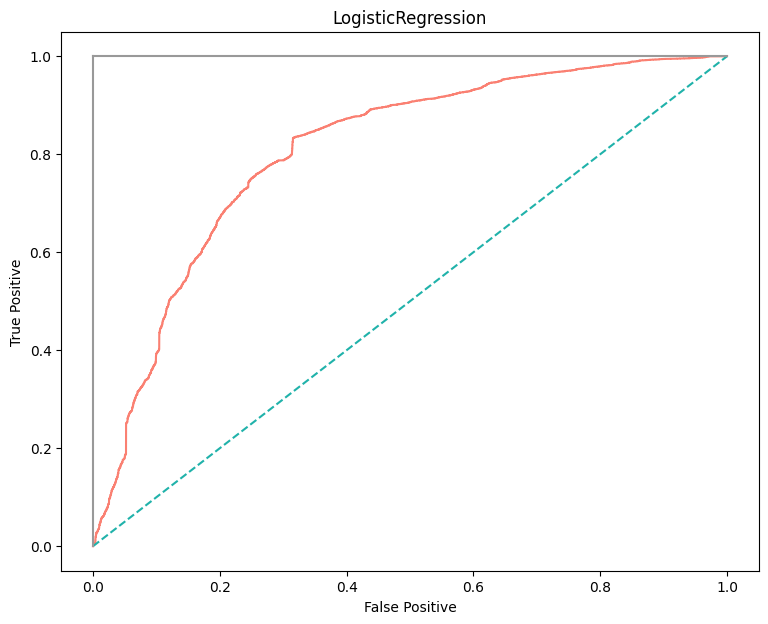

In [287]:
# Logistic Regression Model with the best parameters
logistic_reg, best_parameters_logistic_reg = logistic_reg_grid_search(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

# Print the best parameters
print(f"The best parameters are: 'C': {best_parameters_logistic_reg['C']}, 'solver': {best_parameters_logistic_reg['solver']}.")

# Test the performance of the model
auc_train_logistic_reg, auc_val_logistic_reg, fp_train_logistic_reg, tp_train_logistic_reg, fp_validation_logistic_reg, tp_validation_logistic_reg, pred_logistic_reg_validation = \
    model_examination(logistic_reg, X_train_after_pre_prossesing, y_train_after_pre_prossesing, X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing)

### **Naïve Bayes Classifier**

Naïve Bayes is based on Bayes Theorem, which was proposed by Reverend Thomas Bayes back in the 1760's.<br>
Naive Bayes Classifier is another popular choice for binary classification tasks. Naive Bayes assumes independence between features. It is computationally efficient and can handle high-dimensional data, which is beneficial when dealing with large datasets, like in our case. This model is very simple to train and works reasonably well.

Before applying this model, we need to choose the parameters. <br>
The default is: *, priors=None, var_smoothing=1e-09.

We decided to leave the two parameters as their default values.<br>
The priors are probabilities of the classes. If specified, the priors are not adjusted according to the data. We want it to be adjusted to the data, therefore we will leave it as 'None'.<br>
The var_smoothing parameter is used to add a small amount of variance to the features. We decided to leave it as deafult because this small value is used to ensure numerical stability and to prevent issues that can arise when dealing with feature values that are very close to zero.

The train AUC is 0.765279807616242
The validation AUC is 0.7609653311742615


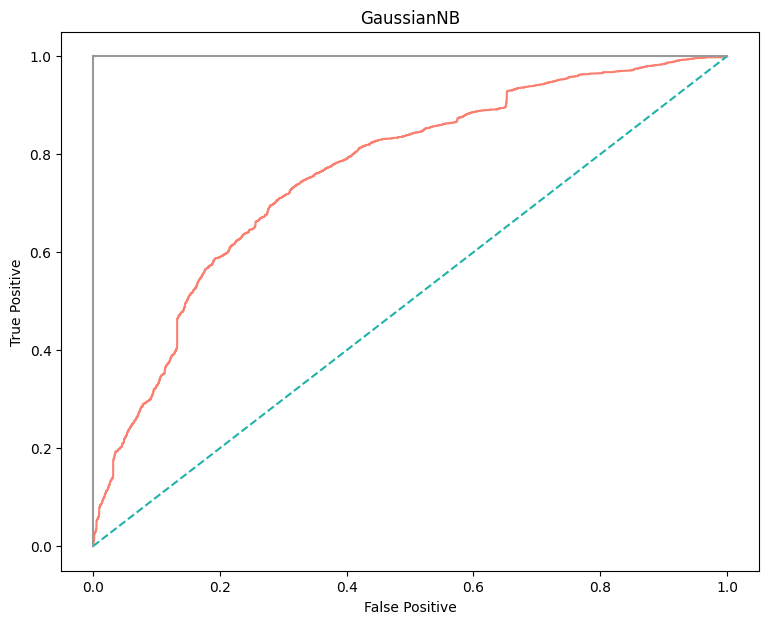

In [288]:
# Naïve Bayes Classifier Model
NB_model = GaussianNB()

# Test the preformans of the model
auc_train_NB_model, auc_val_NB_model, fp_train_NB_model, tp_train_NB_model, fp_validation_NB_model, tp_validation_NB_model, pred_NB_model = model_examination(NB_model, X_train_after_pre_prossesing, y_train_after_pre_prossesing, X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing)

## **Advanced models**

In this part, we apply 2 advanced models on our data. The model selection is: Multi-Layer Percaptron (ANN), Decision Tree, Random Forest / Adaptive Boosting and Support Vectors Machine (SVM).

### **Random Forest**

Random Forest is a popular machine learning algorithm that combines the power of decision trees with ensemble learning.<br>
Random Forest is capable of handling a large number of input features without significant impact on performance. It automatically performs feature selection by evaluating the importance of different features, allowing it to effectively handle high-dimensional datasets.<br>
This model overcomes the problem of correlative features by considering random subsets of split at every splitting decision.

Before applying this model, we need to choose the parameters.<br>
The default is: n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None.

We decided to leave as default all the features except: 'n_estimators', 'max_depth' and 'max_features':<br>
1. **'n_estimators'**- The number of trees in the forest. For large datasets, it is usually common to use a large number of trees.<br>
Having more estimators allows the model to learn more complex relationships in the data, potentially reducing bias. However, adding too many estimators can lead to overfitting and increase the variance.<br>
We will choose the number out of: 100 and 500.
2. **'max_depth'**- The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.<br> 
A deeper tree can fit the training data more closely, which may lead to lower bias. However, excessively deep trees can overfit the data, resulting in higher variance.<br>
We will choose the value between: None, 20.
3. **'max_features'**- The number of features to consider when looking for the best split. Usually when dealing with large datasets, it is recommended to use 'log2' to prevent overfitting.<br>
Having more features available allows the model to capture more complex relationships in the data and potentially reduce bias. However, "max_features" is set to a higher value, the decision trees in the ensemble become more correlated with each other. This can lead to overfitting, resulting in higher variance.<br>
We will choose between: 'sqrt' and 'log2'.

In addition, we decided to set the value of 'cv' in Grid Search to 3 (the default is 5).<br>
'cv' refers to the number of folds used in cross-validation. We decided to lower the number of folds to reduce the computational burden and speed up the Grid Search process.

We will perform grid search to identify the best parameters for 'n_estimators', 'max_depth' and 'max_features'.<br>
Using the best parameters for the model, we will find the train and validation AUC:

In [289]:
def random_forest_grid_search(X, y):

    # Copy the train data
    X_copy = X.copy()
    y_copy = y.copy()

    # Set the parameters to choose from
    random_forest_parameters = {'n_estimators': [100, 500], 'max_depth':[None, 20], 'max_features':['sqrt', 'log2']}

    # Run Grid Search
    grid_search_random_forest= GridSearchCV(RandomForestClassifier(), random_forest_parameters, cv=3)

    # Fit the train data using random forest with the best parameters
    grid_search_random_forest.fit(X_copy, y_copy)

    # Get the best parameters
    best_param_random_forest = grid_search_random_forest.best_params_

    # Random Forest Model with the best parameters
    random_forest = RandomForestClassifier().set_params(**best_param_random_forest)
    
    return random_forest, best_param_random_forest

The best parameters are: 'n_estimators': 500, 'max_depth': None,'max_features': log2.
The train AUC is 0.9999675069820373
The validation AUC is 0.9597156740350861


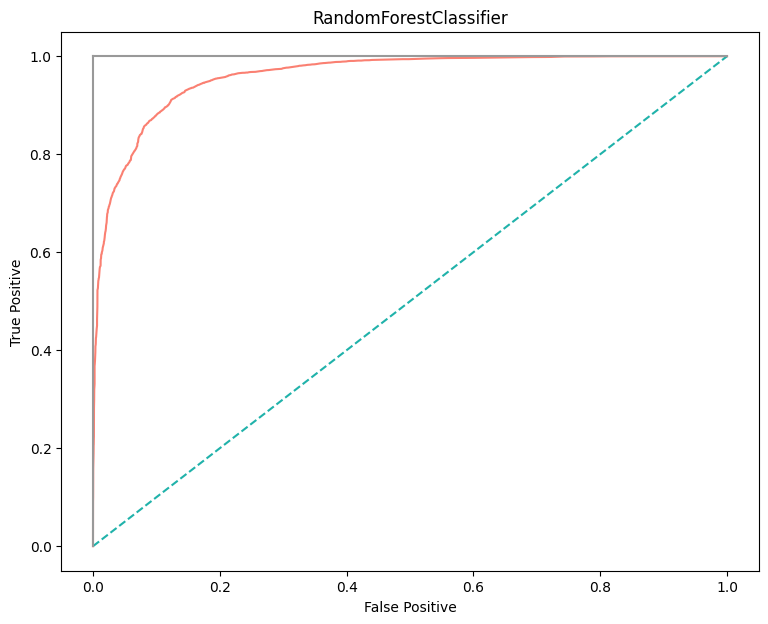

In [290]:
# Random Forest Model with the best parameters
random_forest, best_param_random_forest = random_forest_grid_search(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

# Print the best parameters
print(f"The best parameters are: 'n_estimators': {best_param_random_forest['n_estimators']}, 'max_depth': {best_param_random_forest['max_depth']},'max_features': {best_param_random_forest['max_features']}.")

# Test the performance of the model
auc_train_random_forest, auc_val_random_forest, fp_train_random_forest, tp_train_random_forest, fp_validation_random_forest, tp_validation_random_forest, pred_random_forest = \
    model_examination(random_forest, X_train_after_pre_prossesing, y_train_after_pre_prossesing, X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing)

### **Multi-Layer Perceptron (ANN)**

A Multi-Layer perceptron (MLP) is a type of Artificial Neural Network (ANN) that consists of multiple layers of interconnected artificial neurons or nodes.<br>
This model can learn complex non-linear relationships between input features and the target variable. With multiple hidden layers and non-linear activation functions it can effectively model these complex relationships.<br>
MLPs can handle large datasets. This model has the ability to generalize from the training data to unseen examples, making them capable of handling new patterns.<br>
MLPs can reduce overfitting and improve generalization performance.

Before applying this model, we need to choose the parameters.<br>
The default is: hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000.

We want to find the best values for 'alpha' and 'hidden_layers_sizes'. The rest of the parameters we will use as their default values.<br>
1. **'alpha'**- Strength of the L2 regularization term.<br>
Increasing the value of alpha can increase the bias of the model.<br>
Decreasing the value of alpha can increase the variance of the model.<br>
Large datasets often require models with higher capacity to capture complex patterns. In such cases, using relatively larger alpha values might be appropriate. <br>
We will choose the value out of: 0.0001, 1.
2. **'hidden_layers_sizes'**- The ith element represents the number of neurons in the ith hidden layer.<br>
If the model has insufficient capacity, meaning too few neurons or layers, it may struggle to capture complex patterns in the data, resulting in high bias. In this case there is an under fitting, therefore a small variance.<br>
For smaller numbers of 'hidden_layer_sizes' the learned representations in the network may be more interpretable and there is a lower risk of overfitting. We will check this using the grid search.<br>
We will choose between 20 and 100. 

In addition, we decided to set the value of 'cv' in Grid Search to 3 (the default is 5).<br>
'cv' refers to the number of folds used in cross-validation. We decided to lower the number of folds to reduce the computational burden and speed up the Grid Search process.

We will perform grid search to identify the best parameters for 'alpha' and 'hidden_layer_sizes'.<br>
Using the best parameters for the model, we will find the train and validation AUC:

In [291]:
def MLP_grid_search(X, y):

    # Copy the train data
    X_copy = X.copy()
    y_copy = y.copy()

    # Set the parameters to choose from
    MLP_parameters = {'alpha':[0.0001, 1], 'hidden_layer_sizes':[(20,), (100,)]}

    # Run Grid Search
    grid_search_MLP= GridSearchCV(MLPClassifier(), MLP_parameters, cv=3)

    # Fit the train data using MLP with the best parameters
    grid_search_MLP.fit(X_copy, y_copy)

    # Get the best parameters
    best_param_MLP = grid_search_MLP.best_params_

    # MLP Model with the best parameters
    MLP = MLPClassifier().set_params(**best_param_MLP)
    
    return MLP, best_param_MLP

The best parameters are: 'alpha': 0.0001, 'hidden_layer_sizes': (100,).
The train AUC is 0.9470482859100224
The validation AUC is 0.9286767564954608


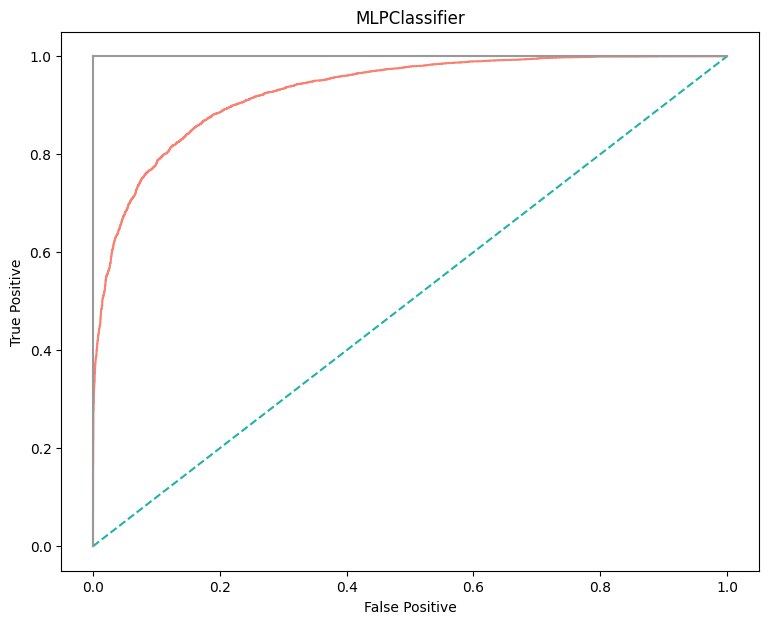

In [292]:
# MLP Model with the best parameters
MLP, best_param_MLP = MLP_grid_search(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

# Print the best parameters
print(f"The best parameters are: 'alpha': {best_param_MLP['alpha']}, 'hidden_layer_sizes': {best_param_MLP['hidden_layer_sizes']}.")

# Test the performance of the model
auc_train_MLP, auc_val_MLP, fp_train_MLP, tp_train_MLP, fp_validation_MLP, tp_validation_MLP, pred_MLP = \
    model_examination(MLP, X_train_after_pre_prossesing, y_train_after_pre_prossesing, X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing)

## **Extra model**

We decided to research and learn about a new model we did not learn during the course.<br>
In this part we will present an explanation about the model. We will also make a prediction on the validation data using the model to check the validation AUC.

### **XGBoost (Extreme Gradient Boosting) Classifier**

Boosting is an ensemble method, meaning it’s a way of combining predictions from several models into one.<br>
Gradient boosting is a specific type of boosting, called like that because it minimises the loss function using a gradient descent algorithm.

XGBoost is a gradient boosting algorithm that uses decision trees as its “weak” predictors. Beyond that, its implementation was specifically engineered for optimal performance and speed.

To understand how XGBoost Classifier works, let's break down its key components and the underlying principles:<br>
- **Loss Function**: XGBoost Classifier uses a loss function to quantify the difference between the predicted and actual labels. The goal is to minimize the loss function by iteratively improving the model.
- **Gradient Boosting**: XGBoost Classifier utilizes the gradient boosting framework. It builds an ensemble of weak models in a sequential manner, where each subsequent model corrects the mistakes made by the previous models. This iterative process improves the ensemble's predictive power.
- **Decision trees as base learners**: XGBoost Classifier employs decision trees as the base learners. These trees are shallow, usually with a small depth, to prevent overfitting. Each decision tree predicts the class labels based on a subset of features. The construction of decision trees is done using the gradient boosting, which involves fitting the tree to the negative gradient of the loss function.
- **Gradient Calculation**: During the training process, XGBoost Classifier calculates the gradient (partial derivative) of the loss function with respect to the predictions made by the ensemble so far. The gradient reflects the direction and magnitude of the improvement needed to minimize the loss function. This calculation is performed for each training instance.
- **Weighted Residuals**: After calculating the gradient, XGBoost Classifier converts it into weighted residuals. The weights are determined based on the loss function and the predicted probabilities or scores from the previous iteration. These weighted residuals represent the "errors" made by the ensemble, and the subsequent weak model (decision tree) aims to correct these errors.
- **Tree Construction**: XGBoost Classifier builds decision trees sequentially, with each tree constructed to minimize the weighted residuals. It uses a technique called "regularized learning" to control the complexity of the trees and prevent overfitting. The regularization terms, such as L1 and L2 regularization, are added to the loss function during tree construction.
- **Ensemble Combination**: The individual decision trees are added to the ensemble one by one, with each tree contributing to the final prediction. The predictions from all the trees are combined through weighted averaging, where the weights are determined based on the performance of the trees on the training data.

The values are typically calculated using the log of odds and probabilities. The output of the tree becomes the new residual for the dataset, which is used to construct another tree. This process is repeated until the residuals stop reducing or for a specified number of times. Each subsequent tree learns from the previous trees and is not assigned equal weight, unlike how Random Forest works.

Historically, XGBoost has performed quite well for structured, tabular data.

To use XGBoost Classifier, we did 2 steps:
1. We installed XGBoost in Anaconda using: "pip install xgboost".
2. We imported XGBoostClassifier (in the start of the project): "from xgboost import XGBClassifier"

Before applying this model, we need to choose the parameters.<br>
The default is: max_depth=6, learning_rate=0.3, n_estimators=100, subsample=1.0, colsample_bytree=1.0, gamma=0.0, reg_alpha=0.0, reg_lambda=1.0, min_child_weight=1, scale_pos_weight=1.0, base_score=0.5, booster="gbtree", random_state=None, verbosity=1, objective="binary:logistic".

We want to find the best values for 'n_estimators', 'max_depth', 'alpha' and 'learning_rate'. We will also set a value for 'random_state'. The rest of the parameters we will use as their default values.<br>
1. **'n_estimators'**- the number decision trees to be built during the training process. Each tree is built sequentially, and subsequent trees try to correct the mistakes made by the previous trees.<br>
Increasing the value of n_estimators can potentially improve the model's performance, but it also increases the training time. Therefore we want to choose between the default, 100, and a greater number, 200.<br>
2. **'max_depth'**- controls the maximum depth allowed for each decision tree in the ensemble. It specifies the maximum number of levels in the tree structure.<br>
A shallow tree with a low max_depth may have fewer splits and nodes, resulting in a simpler model with less complexity. On the other hand, a deeper tree with a higher max_depth can capture more intricate patterns in the data but risks overfitting.<br>
We will choose between the default, 6, and a greater number, 10.<br>
3. **'alpha (reg_alpha)'**- a regularization term that controls L1 regularization on the weights of the model.<br>
A higher value of alpha leads to stronger regularization, meaning that the weights are more heavily penalized, resulting in a sparser model with more zero-valued weights.<br>
We will choose between the default, 0, and a greater number, 0.1.<br>
4. **'learning_rate'**- determines the step size at which the boosting algorithm converges during the training process. It is also commonly known as the "shrinkage" or "eta" parameter.<br>
A lower learning_rate makes the model learn more slowly, reducing the impact of each individual tree. On the other hand, a higher learning_rate allows the model to learn more quickly, but it may lead to overfitting.<br>
We will choose between the default, 0.3, and a smaller number, 0.1.<br>
5. **'random_state'**- set the random seed, which ensures reproducibility of the results.<br>
Setting a specific random_state value allows to obtain the same results every time we run the model. This is particularly important when we need to compare different models.<br>
We will set the value as 42.

In [293]:
def XGBoost_grid_search(X, y):
    # Copy the train data
    X_copy = X.copy()
    y_copy = y.copy()

    # Set the parameters to choose from
    XGBoost_parameters = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'alpha': [0, 0.1], 'learning_rate': [0.1, 0.3], 'random_state':[42]}

    # Run Grid Search
    grid_search_XGBoost = GridSearchCV(XGBClassifier(), XGBoost_parameters, cv=3)

    # Fit the train data using XGBoost with the best parameters
    grid_search_XGBoost.fit(X_copy, y_copy)

    # Get the best parameters
    best_param_XGBoost = grid_search_XGBoost.best_params_

    # XGBoost Model with the best parameters
    XGBoost = XGBClassifier(**best_param_XGBoost)

    return XGBoost, best_param_XGBoost

The best parameters are: 'n_estimators': 200, 'max_depth': 10, 'alpha': 0.1, 'learning_rate': 0.1.
The train AUC is 0.9991032486683562
The validation AUC is 0.9625938706724517


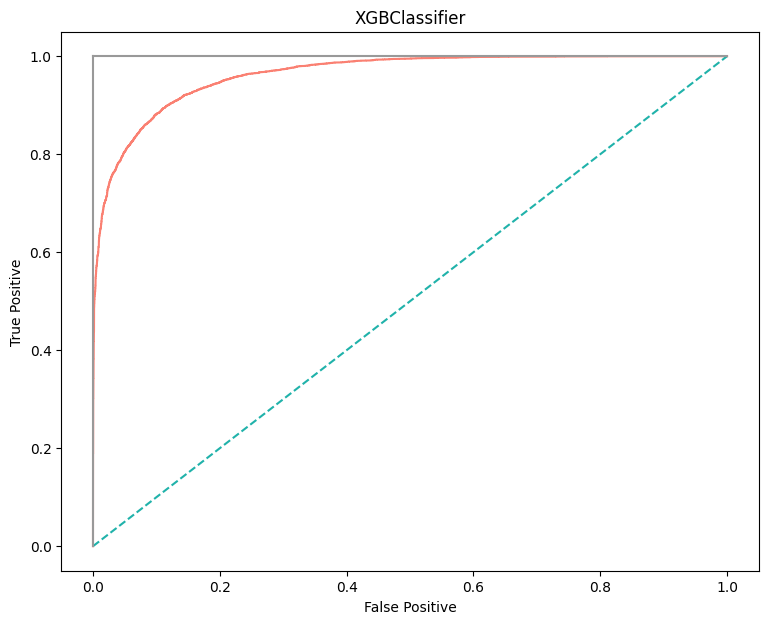

In [295]:
# XGBoost Model with the best parameters
XGBoost, best_param_XGBoost = XGBoost_grid_search(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

# Print the best parameters
print(f"The best parameters are: 'n_estimators': {best_param_XGBoost['n_estimators']}, 'max_depth': {best_param_XGBoost['max_depth']}, 'alpha': {best_param_XGBoost['alpha']}, 'learning_rate': {best_param_XGBoost['learning_rate']}.")

# Test the performance of the model
auc_train_XGBoost, auc_val_XGBoost, fp_train_XGBoost, tp_train_XGBoost, fp_validation_XGBoost, tp_validation_XGBoost, pred_XGBoost = \
    model_examination(XGBoost, X_train_after_pre_prossesing, y_train_after_pre_prossesing, X_Validation_after_pre_prossesing, y_Validation_after_pre_prossesing)

### And our chosen model is...

Out of all the models we used, the model that gave us the highest result in the validation AUC is "XGBoost Classifier".<br>
**Therefore, the model we would like to continue with for the rest of the project is "XGBoost Classifier".**

### Feature importance

The "feature importance" in machine learning refers to a technique that quantifies the contribution or relevance of each feature in the model's predictive performance. It helps us understand the relative importance of different features in the dataset and can provide insights into the underlying relationships between the features and the target variable.

In the following code, we will plot the feature importance in out model (XGBoost Classifier):

In [296]:
def plot_feature_importance(model, X, colors):
    """
    input: a model, data and list of colors
    output: plots the feature importance of the model
    """
    feature_importance = model.feature_importances_
    sorted = np.argsort(feature_importance)
    sorted_feature_importances = feature_importance[sorted]
    sorted_feature_names = np.array(X.columns)[sorted]

    # plot
    pos = np.arange(sorted.shape[0]) + .5
    plt.rcParams["figure.figsize"] = (12,8)
    bars = plt.barh(pos, sorted_feature_importances, align='center', color=colors)
     
    # Adding precentage labels
    for bar, importance in zip(bars, sorted_feature_importances):
        plt.text(bar.get_width() + 0.000005, bar.get_y() + bar.get_height() / 2, f'{importance*100:.2f}%', ha='left', va='center')
    
    plt.yticks(pos, sorted_feature_names)
    plt.title('Feature Importance in XGBoost Classifier')
    plt.show()

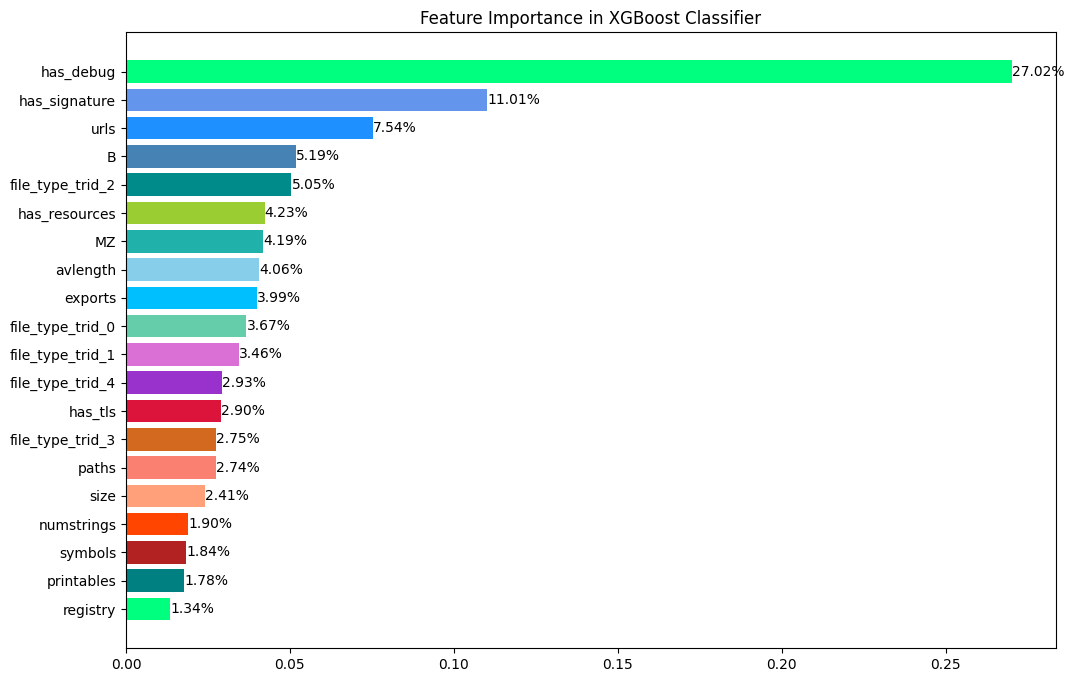

In [297]:
plot_feature_importance(XGBoost, X_train_after_pre_prossesing, colors[:19])

We decided to analyze the features that explain together 70% of the model. If the top few features contribute to a cumulative importance of 70% or more, it suggests that these features capture the majority of the predictive power in the dataset.<br>
The first 9 features have the highest importance in the model and explain together more than 70% of the model. This features are (in a descending order of importance):<br>

1. **'has_debug'**<br>
Whether a file has a debug section.<br>
The correlation between 'has_debug' and the label is -0.31%. This is the strongest correlation with the label. Therefore, we are not surprised that this feature is on the top of the feature importance.<br>
Malicious files may attempt to disguise their true nature by masquerading as legitimate files. One way they can do this is by omitting or removing the debug section, as it is typically unnecessary for the execution of the malicious payload. Thus, the absence of a debug section may raise suspicions that a file could be malicious. One the other hand, some sophisticated malware may intentionally include a debug section to mislead and to make the file look not malicious.<br><br>

2. **'has_signature'**<br>
Whether a file has a signature.<br>
The correlation between 'has_signature' and the label is -0.28%. This is the third strongest correlation with the label, therefore we assumed that it will be meaningful in the feature importance, as it is here.<br>
Digital signatures are cryptographic mechanisms used to verify the authenticity and integrity of files. Legitimate software developers often sign their files with digital signatures to ensure that the files have not been tampered with and can be trusted. Therefore, the presence of a digital signature in a file can indicate that it has been verified by the software developer and is more likely to be non-malicious.<br><br>

3. **'urls'**<br>
Number of occurrences of http:// or https:// (case insensitive) that may indicate a URL.<br>
The correlation between 'urls' and the label is -0.05%.<br>
Malicious files can also be associated with URLs that are used for phishing attacks or directing users to malicious websites. By examining the presence and frequency of URLs within a file, we can gain insights into the potential for the file to be part of a larger malicious campaign or used for spreading malware through URLs.<br><br>

4. **'B'**<br>
An anonymous feature.<br>
The correlation between 'B' and the label is 0.29%. This correlation is the second highest correlation with the label. Although this is an anonymous feature, we learn that it is the a signficiant feature and has a strong correlation with the label. Therefore, we understand that this is an important and meaningful feature.<br><br>

5. **'file_type_trid_2**<br>
The file type with the highest probability, given by TRID.<br>
The correlation between 'file_type_trid_2' and the label is -0.03%.<br>
This feature is one of the features we did to make the categorical feature 'file_type_trid' a numeric feature. We used binary method to do it.
The "TRID" (TRI File Identifier) is a utility used to identify file types based on their binary signatures or characteristics. It analyzes the binary structure of a file and compares it to a database of known file signatures to determine the file type with the highest probability.<br>
The connection between a file being malicious or not malicious and the TRID utility lies in the fact that certain file types are commonly associated with malicious behavior. Security researchers and antivirus companies maintain databases that associate certain file types or signatures with known malicious files.<br><br>

6. **'has_resources'**<br>
Whether a file has resources.<br>
The correlation between 'has_resources' and the label is -0.12%.<br>
The connection between a file being malicious or not malicious and the 'has_resources' feature lies in the observation that malicious files often contain additional resources that enable their harmful behavior. Malware authors may use resources to store malicious code, exploit vulnerabilities, or hide their activities within legitimate-looking files.<br><br>

7. **'MZ'**<br>
The number of occurrences of the short string MZ that may provide weak evidence of a Windows PE dropper or bundled executables.<br>
The correlation between 'MZ' and the label is -0.03%.<br>
'MZ' helps identify files that can be executed by the operating system. Malicious files, including various types of malware, can also be in the form of executable files. Therefore, the presence of the 'MZ' signature suggests that a file has the potential to contain executable code, which is relevant when analyzing files for potential threats.<br><br>

8. **'avlength'**<br>
Represents the average string length in a file.<br>
The correlation between 'avlength' and the label is 0.05%. Although the correlation is not high, we learn that this feature was very important in the model.<br>
Malicious files often exhibit certain unusual characteristics that can be detected through analysis of file attributes. By considering the average length of file attributes, we may be able to identify deviations from expected values or patterns.<br><br>

9. **'exports'**<br>
Number of exported functions.<br>
The correlation between 'exports' and the label is -0.19%.
Malicious files can have a varying number of exported functions, and legitimate files can also have a significant number of exports. This explains why this feature is not higher up in the feature importance.

As we mentioned, there are relatively many features with theoretical significance to the label, so it can be seen that there is one significant feature in the feature importance.

# __*Part 4- Model Evaluation*__

### **Confusion Matrix**

The confusion matrix is an important tool in machine learning projects, particularly in the evaluation and assessment of classification models.<br>
It provides a comprehensive summary of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.<br>
The confusion matrix allows for a more detailed analysis of the model's predictive capabilities, helping to assess it's strengths and weaknesses.

First, let's fit out model on the train data and get the prediction on the validation data.

Now we will plot the confusion matrix for the validation data:

In [298]:
def plot_confusion_matrix(test_labels, test_pred):
    """
    input: test labels and test predictions
    output: plots the model's confusion matrix
    """
    cm = confusion_matrix(test_labels, test_pred)
    tn, fp, fn, tp = cm.ravel()
    cm = np.array([[tp,fp],[fn,tn]])
    ax = sns.heatmap(cm, annot=True,fmt='g', cmap='Greens', xticklabels = ['True malicious','True not malicious'], yticklabels = ['Predicted malicious','Predicted not malicious'])
    ax.set(xlabel='True label', ylabel='Predicted label')
    plt.show()

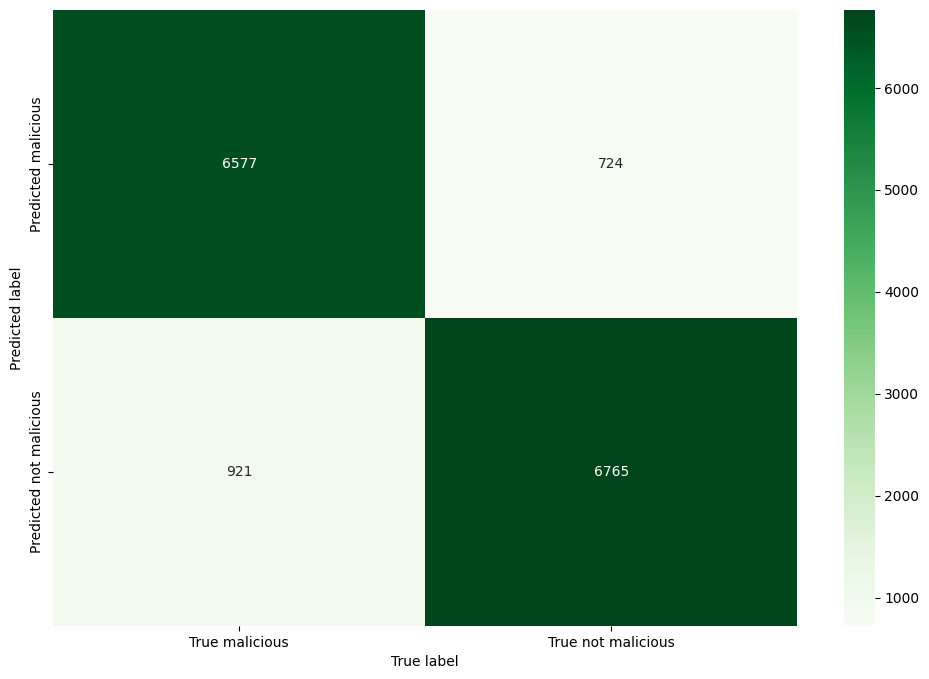

In [299]:
plot_confusion_matrix(y_Validation_after_pre_prossesing.copy(), pred_XGBoost)

#### Confusion Matrix analysis

Now that we have the confusion matrix for the validation data, we want to analize the preformance of the model:<br>
- **True positive (top left)**- Each sample is a malicious file and was predicted as one.
- **False positive (top right)**- Each sample is not a malicious file but was predicted as a malicious file.
- **True negative (bottom left)**- Each sample is a malicious file but was predicted as not malicious.
- **False negative (bottom right)**- Each sample is not a malicious file as was predicted as one.

True positive and true negative indicate that the model predicted the samples correctly. This means that our model was correct significantly more then when it was incorrect. Therefore, it means that overall our model predicted well the validation set.

When classifying files as malicious or not, it is better to classify a not malicious file as a malicious file than the other way around. It is better to be safe and more cautious than to classify a malicious file as not malicious and be exposed to danger.<br>
When analizing the confusion matrix, we notice that true negative has more samples than false positive. This means that we have relatively a significant number of malicious files that were classified as not malicious. Although we see that our model predicted, for the most part, the samples correctly, this is it's Achilles' heel.

### **K-Fold Cross Validation**

K-fold cross validation is an essential technique in machine learning projects for evaluating and selecting models. It provides a robust and reliable estimate of the model's performance by partitioning the data into multiple subsets and systematically validating the model on different combinations of training and validation sets.

In this part we will preform K-fold cross validation on our model. We will plot a ROC plot for each of the models in the K-fold cross validation. We will preform it on each of the models we did in part 3.<br>
The common choice for k in k-fold cross validation is 5 or 10. For large datasets, like in our project, it is acceptable to use smaller number of folds. Therefore, we decided to preform 5-fold cross validation.

In [300]:
def k_fold_roc_by_fold(models, X, y, k, colors):
    """
    Plot ROC curves for each fold of each model in k-fold cross-validation.
    input: the models we performed, data and lables, the number of k-fold and a list of colors
    otput: results of mean fpr, mean tpr and mean auc for each model
    """
    results = []  # Store the results for mean_roc_curve
    
    for model_idx, model in enumerate(models):
        plt.figure()
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        kf = KFold(n_splits=k, random_state=None, shuffle=False)
        
        for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            
            fpr, tpr, threshold = roc_curve(y_test, y_scores)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = roc_auc_score(y_test, y_scores)
            aucs.append(roc_auc)
            
            # Plot ROC curve for each fold with different color
            plt.plot(fpr, tpr, color=colors[fold_idx], alpha=0.7, label=f"AUC: {roc_auc}")
            plt.legend(loc='lower right')
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curves for {k}-fold cross-validation - {model.__class__.__name__}')
        plt.show()
        
        results.append((mean_fpr, mean_tpr, mean_auc))
    
    return results

In [301]:
def mean_roc_curve(models, results, k, colors):
    """
    Plot the mean ROC curve for each model in k-fold cross-validation in a single plot.
    input: the models we performed, the results from k_fold_roc_by_fold, the number of k_fold and colors
    """ 
    plt.figure()
    
    for model_idx, (mean_fpr, mean_tpr, mean_auc) in enumerate(results):
        plt.plot(mean_fpr, mean_tpr, color=colors[model_idx], linewidth=2, label=f'Mean AUC {models[model_idx].__class__.__name__} = {mean_auc:.5f}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC curves for {k}-fold cross-validation')
    plt.legend(loc='lower right')
    plt.show()

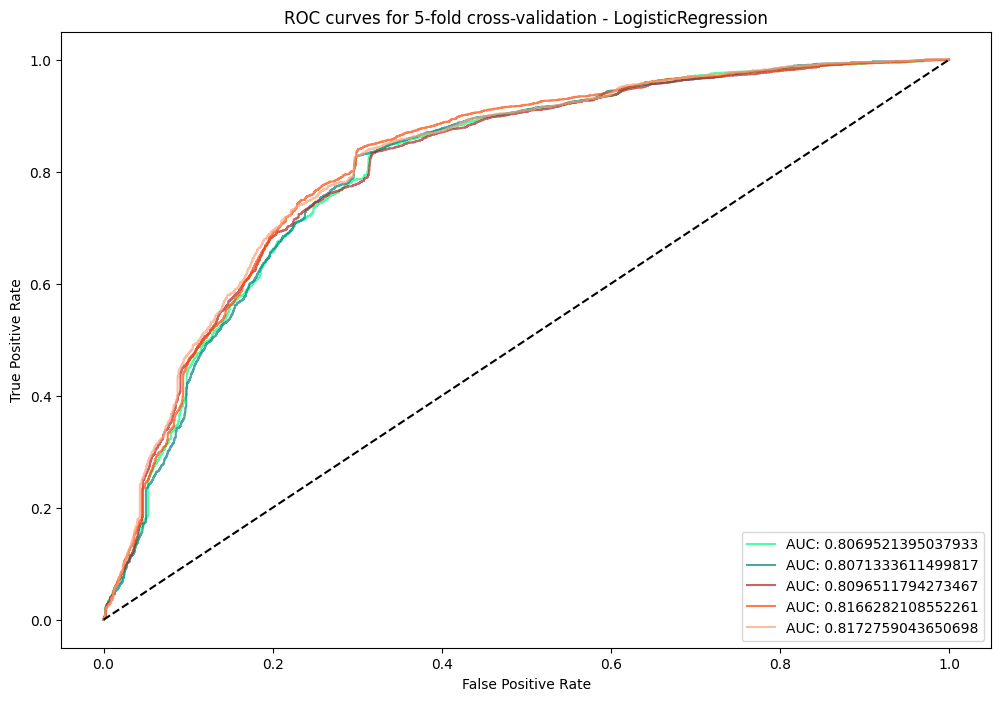

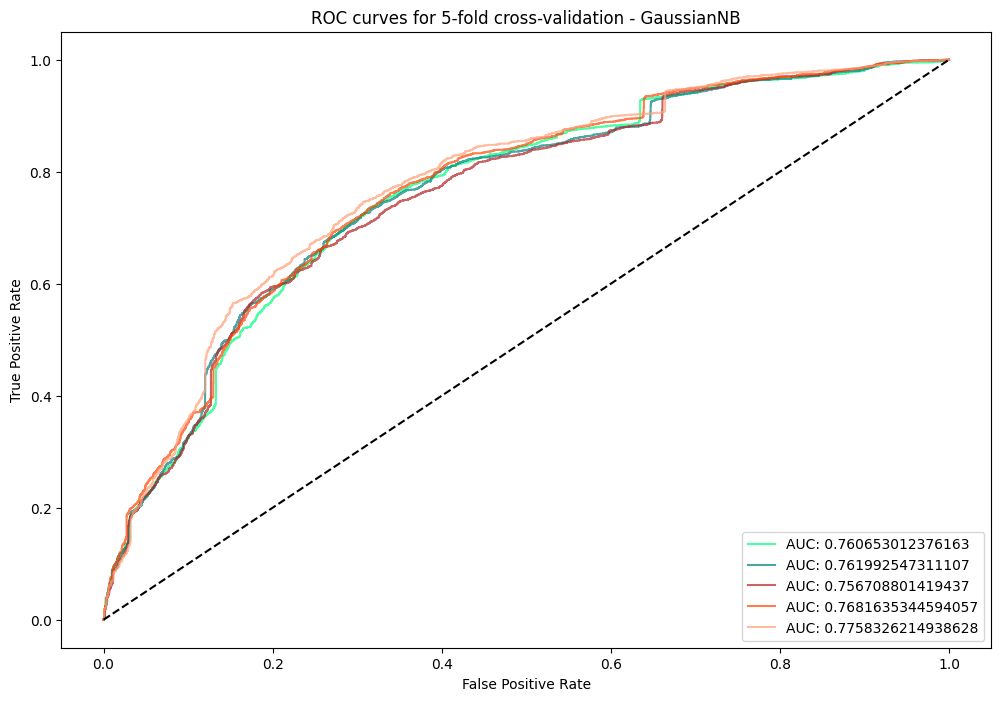

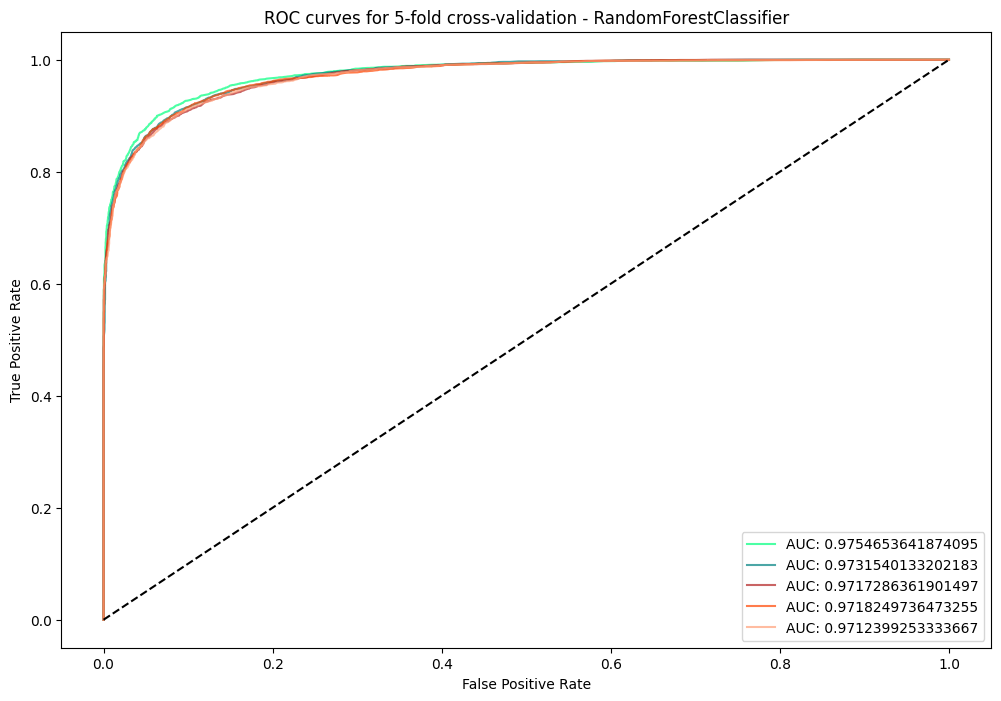

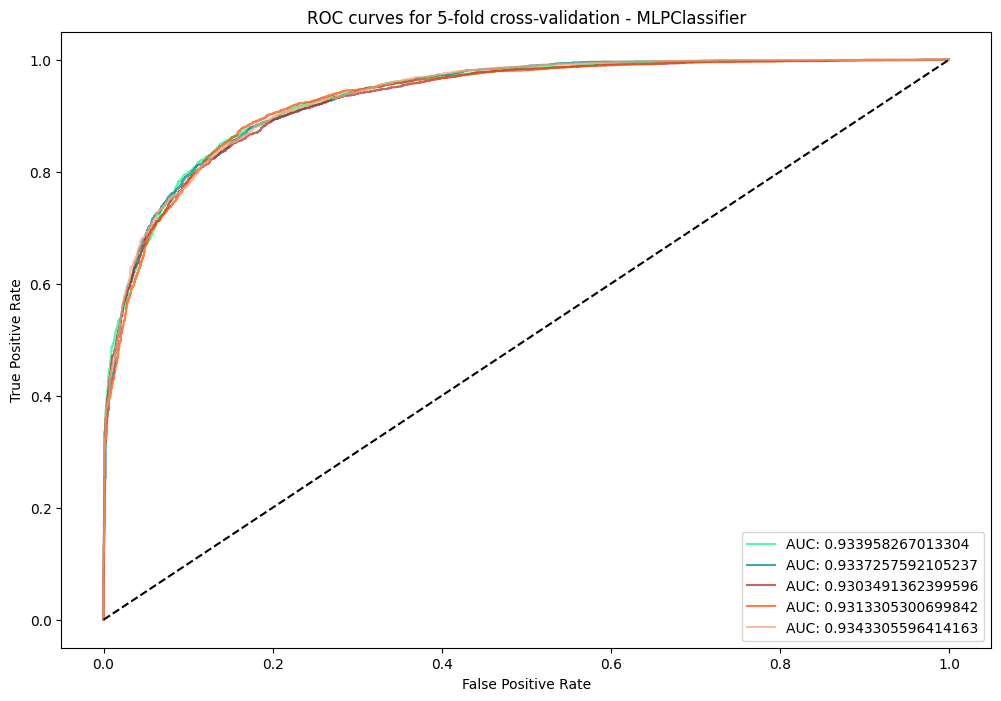

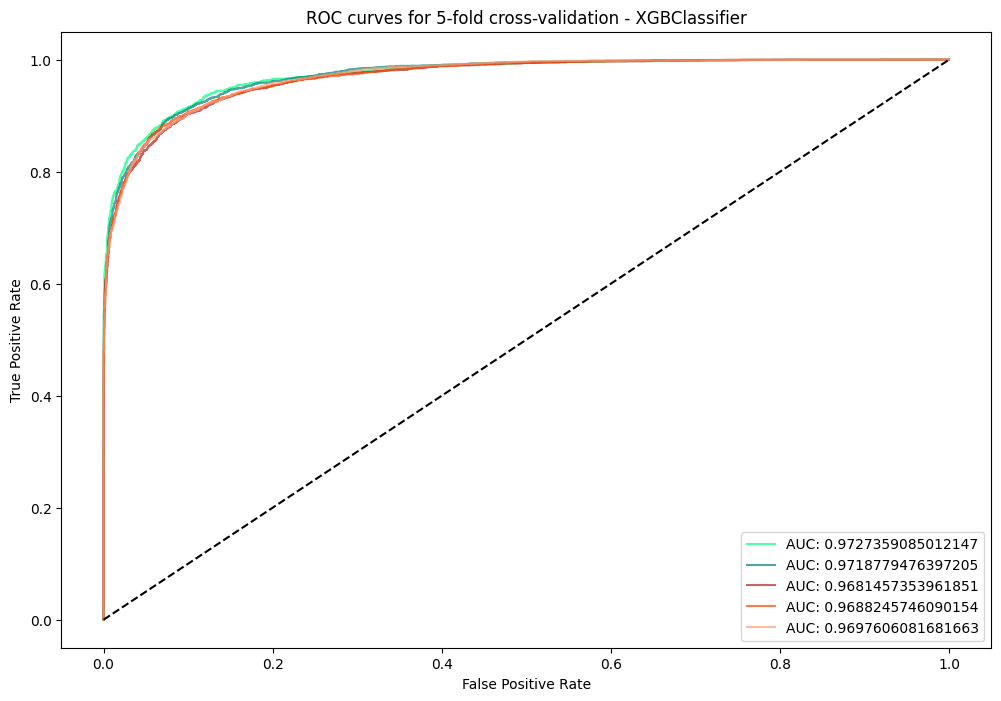

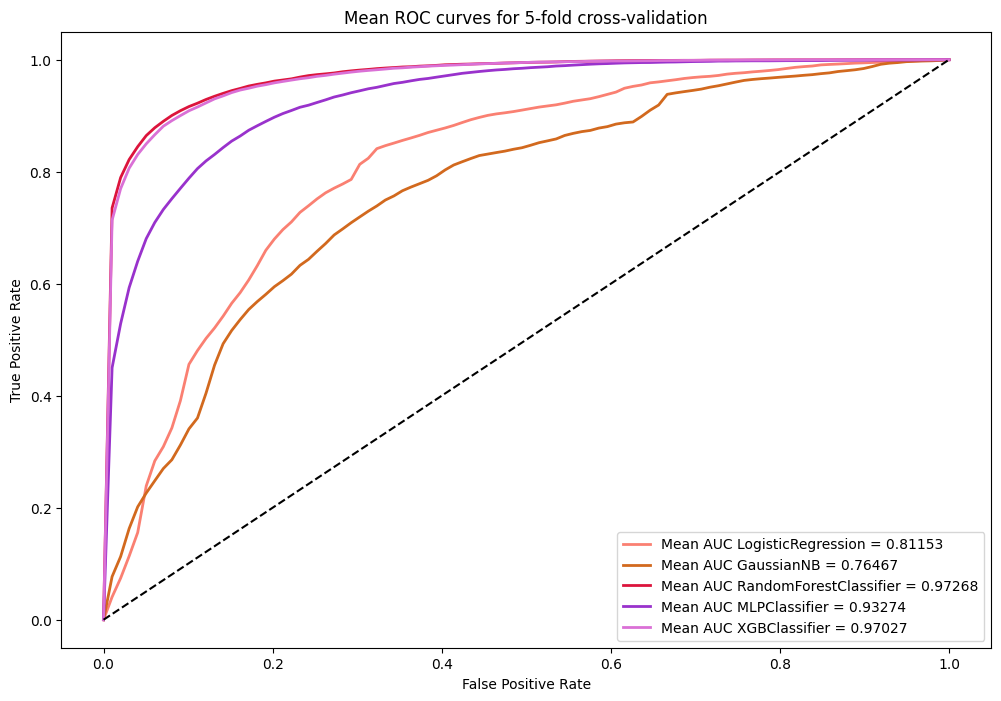

In [302]:
X_train_copy = X_train_after_pre_prossesing.copy()
y_train_copy = y_train_after_pre_prossesing.copy()
models = [logistic_reg, NB_model, random_forest, MLP, XGBoost]
k = 5

# Plot ROC curves for each fold of each model
results = k_fold_roc_by_fold(models, X_train_copy, y_train_copy, k, colors[0:5])

# Plot the mean ROC curve for each model in a single plot
mean_roc_curve(models, results, k, colors[5:10])

When working with a large data set and aiming to obtain the best test area under the ROC curve (AUC), it is generally recommended to prioritize the model with the highest validation AUC rather than the highest k-fold score.<br>
Although Random Forest has a greater mean AUC in the k-fold cross validation than XGBoost Classifier, that had the highest validation AUC, we will still choose our main model to be XGBoost Classifier because it is recommended to choose the model with a higher validation AUC when we prioritize performance on unseen data, like in this project.

#### **Performance gaps between train and validation & overfitting**

We are interested in comparing the validation performance and the train performance. We will show the differences the two using the next plot:

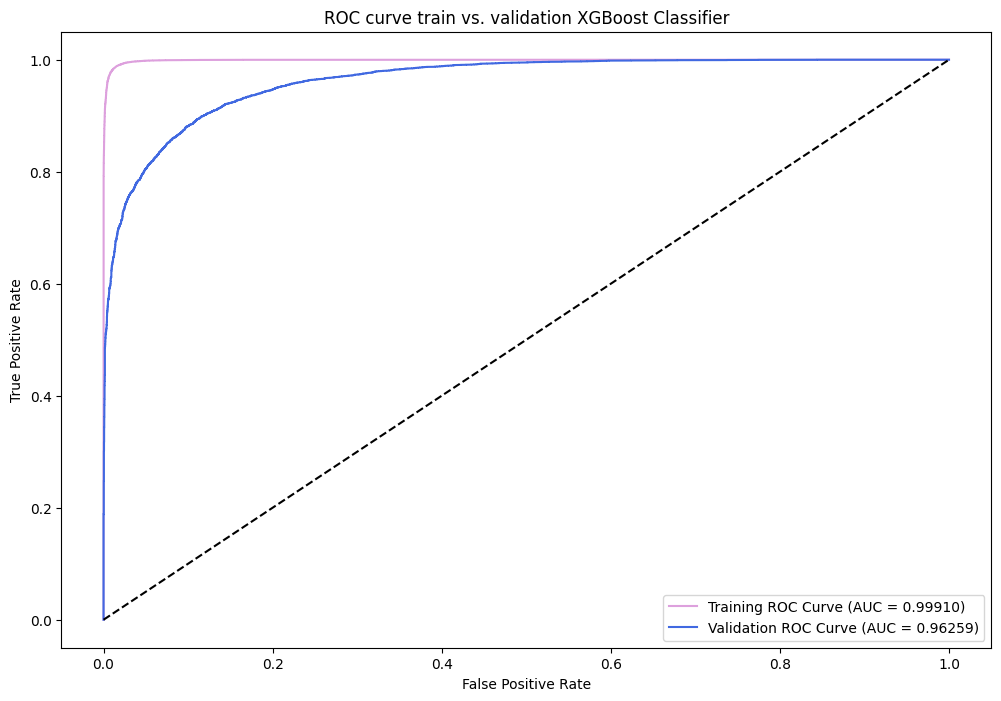

In [303]:
plt.plot(fp_train_XGBoost, tp_train_XGBoost, label='Training ROC Curve (AUC = {:.5f})'.format(auc_train_XGBoost), color=colors[-9])
plt.plot(fp_validation_XGBoost, tp_validation_XGBoost, label='Validation ROC Curve (AUC = {:.5f})'.format(auc_val_XGBoost), color=colors[-10])
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve train vs. validation XGBoost Classifier')
plt.legend()
plt.show()

##### Conclusions:

- **AUC Comparison-** A higher AUC indicates better model performance. In our model, both the train AUC and validaion AUC are higher then 0.9. We can notice that the validation AUC is close to the train AUC, indicating good generalization of the model.
- **Shape of the curves-** In an ideal scenario, both curves should be close to the top-left corner, indicating high true positive rates and low false positive rates. As we can notice from the plot, the training curve is closer to the top-left corner than the validation curve, suggesting potential overfitting.
- **Proximity to the diagonal line-** The diagonal line represents random guessing, where the true positive rate equals the false positive rate. From the plot we can see that both curves are far away from the diagonal line, it indicates good model performance.

##### Is our model overfitted?

We do not have a concrete answer to this question, but we will show both sides of the coin:<br>
On the one hand, the validation AUC is very close to the train AUC and both are high. When the training and validation AUC values are high and similar, it indicates that the model has learned patterns and relationships from the training data that can be effectively applied to unseen data. This suggests that the model has good generalization capabilities and is likely to perform well on new, unseen examples. Also, when the training AUC and validation AUC are close, it suggests that the model is not overfitting or underfitting.<br>
On the other hand, we suspect an overfitting in our model for two reasons:<br>
First, we notice that the training AUC is very close to 1. While a training AUC close to 1 indicates good performance on the training data, it is important to be cautious about potential overfitting. Overfitting occurs when the model becomes too specialized in the training data.<br>
Second, from the plot above we can see that the training ROC curve is very close to the top-left corner. While a training ROC curve close to the top left corner may seem impressive, it raises concerns about the model's ability to generalize to new, unseen data.

To sum up, we suspect that our model is overfitted.

##### What **did we do** in order to increase the generalizability of the model?

- Collecting more data can help the model to generalize better and reduce overfitting. Having a larger dataset can provide more representative patterns for the model to learn from.<br>
In our project, we received a large training datatset and split it to 75% train and 25% validation, leaving us with training dataset with 44,960 samples after the pre prossesing. This large training dataset can help the model to generalize better.
- Pre processing techniques can help to make the data more consistent and representative, which can improve generalization.<br>
In this project we put a lot of emphasis on pre processing and cleaned the data using this techniques: handling missing values, removing outliers, feature selection and standardizing the data.
- Increase the number of trees in XGBoost Classifier- this model relies on an ensemble of decision trees. Increasing the number of trees can improve the model's generalization capabilities. More trees allow for better aggregation of predictions, reducing the impact of individual tree biases.<br>
The default number of trees in XGBoost Classifier is 100, but we increased it to 200. Therefore, this step in a technique to increase the generalizability of the model.
- Ensemble methods- XGBoost Classifier, the model we chose, combines both bagging and boosting techniques to create an ensemble of decision trees. It uses gradient boosting algorithms that optimize an objective function by iteratively adding new trees to the ensemble. Ensemble methods help to capture diverse perspectives and improve overall performance.
- Hyperparameter tuning- optimize the hyperparameters of the model to find the best configuration can maximize generalization. Hyperparameters influence the model's behavior. We chose the values of the hyperparameters in the model by using grid search and therefore we enhanced the generalization.

##### What **can we do** in order to increase the generalizability of the model?

We can keep a close eye on our model's performance during development and testing phases. From the ROC curve that compares the train and the validation, we observed a large gap between training and validation performance. This might indicate overfitting. Regularly diagnosing and assessing the model's behavior will allow us to take appropriate actions to handle overfitting.

# __*Part 5- Prediction*__

In this final part, we will predict each sample in the test data.

In part 2 we applied the pre prossesing function and methods on the test data. Therefore, now we have a clean and prossesed test data (according to our choices on the train data) we can predict on.<br>
Let's see a glimpse of the test data:

In [304]:
test_data_after_pre_prossesing.head()

size   exports  has_debug  has_resources  has_signature  has_tls  \
0  0.160748  0.000000        0.0            1.0            0.0      0.0   
1  0.018003  0.000000        1.0            1.0            0.0      0.0   
2  0.518696  0.000046        0.0            1.0            0.0      0.0   
3  0.208714  0.000000        1.0            1.0            0.0      0.0   
4  0.354786  0.000000        0.0            1.0            0.0      0.0   

   symbols  numstrings     paths  urls  registry        MZ  printables  \
0      0.0    0.027654  0.000000   0.0       0.0  0.012524    0.010455   
1      0.0    0.002129  0.000669   0.0       0.0  0.003854    0.003215   
2      0.0    0.093280  0.008027   0.0       0.0  0.007707    0.069197   
3      0.0    0.044863  0.000000   1.0       0.0  0.000963    0.056366   
4      0.0    0.019576  0.002676   0.0       0.0  0.000963    0.009814   

       avlength         B  file_type_trid_0  file_type_trid_1  \
0  3.139114e-07  0.982367               0.0               0.0   
1  6.254976e-02  0.419235               0.0               0.0   
2  2.285657e-02  0.721584               0.0               1.0   
3  5.523795e-02  0.325227               0.0               0.0   
4  7.769453e-03  0.574046               0.0               0.0   

   file_type_trid_2  file_type_trid_3  file_type_trid_4  
0               1.0               0.0               0.0  
1               0.0               1.0               0.0  
2               1.0               1.0               0.0  
3               1.0               0.0               0.0  
4               1.0               1.0               1.0

Now we will combine all the improtant function for the model in a pipeline. In this pipeline we will apply pre prossesing on the train data, fit the XGBoost Classifier model on it and predict the test data.

In [307]:
def pipeline (train_file, test_file):
    """
    input: train file csv, test file csv, the model we chose to use
    output: data frame that has the names of samples in the test data and the prediction probabilities for each sample
    """

    # Import the train and test data
    train_data, test_data = load_files(train_file, test_file)

    # Drop duplicates from the train data
    train_data = drop_duplicates_train(train_data)

    # Creating X and y out of the train data
    X_train = train_data.iloc[:,:-1]
    y_train = train_data.iloc[:,-1]

    # Pre prossesing on all of the train data (without splitting to validation)
    X_train_after_pre_prossesing, y_train_after_pre_prossesing, features_to_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C = pre_prossesing_on_train(X_train, y_train)
    
    # Pre prossesing on the test data
    test_data_after_pre_prossesing, test_data_file_names = pre_prossesing_functions(test_data_copy, features_to_reduce_dimention, values_to_fill_binary_features, values_to_fill_mean, values_to_fill_median, encoder_file_type_trid, encoder_C, None, 1) 

    # Get the XGBoost Classifier model with the best parameters
    model, best_param = XGBoost_grid_search(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

    # Fit the model on the train data
    model.fit(X_train_after_pre_prossesing, y_train_after_pre_prossesing)

    # Get probabilities for a file to be malicious in the test data
    predictions_test_data = model.predict_proba(test_data_after_pre_prossesing)[:, 1]

    # Create a Data Frame for predictions on the test data
    test_prediction_data_frame = pd.DataFrame(index = test_data_file_names, data = predictions_test_data)

    # Set headlines to the predictions column
    test_prediction_data_frame.columns = ['predict_proba']

    # Export the test predictions to a csv file
    test_prediction_data_frame.to_csv('results_3.csv')

    return test_prediction_data_frame

In [308]:
test_predictions = pipeline("train.csv", "test.csv")

Let's see a glimpse into the test predictions:

In [309]:
test_predictions.head()

predict_proba
sha256                                                           
023928c14abe04196d45bb4578b8fa0eb02189898ce93b3...       0.989866
6436083d4eed84436768d66829b961927eeb9de2e6657f1...       0.258345
038e71f41fdc5edb3a7afc112fb0679a4a5d6d945120559...       0.691242
be913ef29b4566e7817a5ab2c4a4289a455e9b562e1da08...       0.021567
e78f83f0af4f1fbcf8fffd562b4734701483818078bf0ef...       0.009340

We want to learn about the percentage of files that were classified as malicious and not malicious:

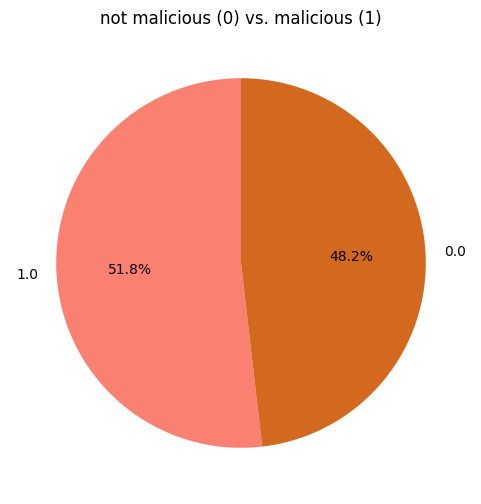

In [310]:
# Count malicious and not malicious files in test prediction
value_counts = test_predictions.round()['predict_proba'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors = colors[5:7])

# Add a title
plt.title('not malicious (0) vs. malicious (1)')

# Display the chart
plt.show()

From the plot we learn that the classification of the samples in the test data is close to a uniform distribution, meaning that about half of the files (samples) were classified as malicious.

# __*Part 6- New tools we used*__

During this project, specifically in the pre processing (part 2), we used two new tools we did not learn during the Machine Learning course:<br>
1. **Winsorization-** When we dealt with outliers, we used the Winsorization technique. Winsorization is the transformation that limits extreme values in the data to reduce the effect of possibly spurious outliers. This technique is used to address outliers in non-normal features by capping or truncating extreme values at a predefined threshold. Instead of completely removing outliers, this technique replaces them with less extreme values. This approach retains the information provided by the outliers while reducing their impact on the analysis.<br>
2. **Binary Encoding-** When dealing with categorical features, specifically with 'file_type_trid' that has a large number of categories, we used the binary encoding technique. Binary encoding represents each category with binary code. It first encodes each category as an integer, then converts the integer to binary code, and finally creates binary features based on the binary representation. The binary encoding method creates a set of binary columns, with each column representing a unique category in the original categorical variable. If there are n unique categories, then binary encoding results in the only $\log_2(n)$ features. We decided to use this technique because if we used regular dummies we would have received a very large number of features.
3. **XGBoost Classifier-** This is the model we chose to use in this project as our final and main model. XGBoost is a gradient boosting algorithm that uses decision trees as its “weak” predictors. In part 3 we presented the model's abilities and it's benefits to our project.